# ASAS-SN Catalog EDA (Extended)

**Comprehensive exploratory data analysis of the ASAS-SN catalog**

`asassn_index_masked_concat_cleaned_20250919_154524_brotli.parquet`

This notebook provides deep analysis to inform filtering strategies in `pre_filter.py` and understand the data for transient/AGN detection pipeline.

---

## Table of Contents
1. Setup and Data Loading
2. Basic Data Inspection
3. Cross-Catalog Coverage Analysis
4. Multi-Band Photometry Analysis
5. Color-Color Diagrams and Stellar Populations
6. Gaia-Specific Analysis (HR Diagram, Variability, Extinction)
7. Proper Motion and Kinematics
8. Parallax and Distance Analysis
9. Photometric Quality Metrics
10. Magnitude Bin Analysis (12-15 mag)
11. Extinction Analysis
12. Galactic Coordinates and Coverage
13. Contamination Risk Assessment
14. Data Quality and Filtering Recommendations
15. Advanced Diagnostics
16. Summary and Export

## 1. Setup and Data Loading

In [20]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from astropy.coordinates import SkyCoord
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [21]:
# Load the parquet file
DATA_PATH = Path('../output/asassn_index_masked_concat_cleaned_20250919_154524_brotli.parquet')

print(f"Loading data from: {DATA_PATH}")
print(f"File size: {DATA_PATH.stat().st_size / 1024**2:.1f} MB")
df = pd.read_parquet(DATA_PATH)
print(f"\nLoaded {len(df):,} rows x {len(df.columns)} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Loading data from: ../output/asassn_index_masked_concat_cleaned_20250919_154524_brotli.parquet
File size: 1146.3 MB

Loaded 16,999,525 rows x 47 columns
Memory usage: 7103.4 MB


## 2. Basic Data Inspection

In [22]:
# List all columns grouped by category
print("COLUMN INVENTORY")
print("="*80)

col_groups = {
    'ID Columns': [c for c in df.columns if 'id' in c.lower()],
    'Coordinates': [c for c in df.columns if any(x in c.lower() for x in ['ra', 'dec', 'lon', 'lat'])],
    'Proper Motion': [c for c in df.columns if 'pm' in c.lower()],
    'Parallax': [c for c in df.columns if 'plx' in c.lower()],
    'Gaia Photometry': [c for c in df.columns if 'gaia' in c.lower() and 'mag' in c.lower()],
    'Pan-STARRS Photometry': [c for c in df.columns if 'pstarrs' in c.lower()],
    'Extinction/Reddening': [c for c in df.columns if any(x in c.lower() for x in ['extinc', 'rp_', 'sfd'])],
    'Gaia Properties': [c for c in df.columns if 'gaia' in c.lower() and 'mag' not in c.lower()],
}

assigned = set(col for cols in col_groups.values() for col in cols)
col_groups['Other'] = [c for c in df.columns if c not in assigned]

for group, cols in col_groups.items():
    if cols:
        print(f"\n{group} ({len(cols)}):")
        for col in sorted(cols):
            print(f"  - {col}")


COLUMN INVENTORY

ID Columns (9):
  - allwise_id
  - asas_sn_id
  - gaia_id
  - hip_id
  - refcat_id
  - sdss_id
  - tic_id
  - tmass_id
  - tyc_id

Coordinates (6):
  - dec_deg
  - pm_dec
  - pm_dec_d
  - pm_ra
  - pm_ra_d
  - ra_deg

Proper Motion (4):
  - pm_dec
  - pm_dec_d
  - pm_ra
  - pm_ra_d

Parallax (2):
  - plx
  - plx_d

Gaia Photometry (6):
  - gaia_b_mag
  - gaia_b_mag_d
  - gaia_mag
  - gaia_mag_d
  - gaia_r_mag
  - gaia_r_mag_d

Pan-STARRS Photometry (16):
  - pstarrs_g_mag
  - pstarrs_g_mag_chi
  - pstarrs_g_mag_contrib
  - pstarrs_g_mag_d
  - pstarrs_i_mag
  - pstarrs_i_mag_chi
  - pstarrs_i_mag_contrib
  - pstarrs_i_mag_d
  - pstarrs_r_mag
  - pstarrs_r_mag_chi
  - pstarrs_r_mag_contrib
  - pstarrs_r_mag_d
  - pstarrs_z_mag
  - pstarrs_z_mag_chi
  - pstarrs_z_mag_contrib
  - pstarrs_z_mag_d

Extinction/Reddening (5):
  - gaia_g_extinc
  - rp_00_1
  - rp_01
  - rp_10
  - sfd_g_extinc

Gaia Properties (4):
  - gaia_eff_temp
  - gaia_g_extinc
  - gaia_id
  - gaia_var

O

In [23]:
# Data types summary
dtype_counts = df.dtypes.value_counts()
print("Data Type Distribution:")
print(dtype_counts)
print(f"\nFirst few rows:")
df.head()

Data Type Distribution:
float64    34
int64      10
object      3
Name: count, dtype: int64

First few rows:


asas_sn_id      ra_deg    dec_deg          refcat_id  \
0  395137802047  166.540806 -12.806437  92631665408062645   
1  292059029648  122.779119 -12.653716  92811227791195911   
2  292058107236  126.517920 -12.715071  92741265179202285   
3  309238193423  310.431158 -12.937021  92473104311575944   
4  292058568170   99.079957 -12.839079  92590990799563475   

               gaia_id  hip_id        tyc_id          tmass_id  sdss_id  \
0  3564313717372918912     NaN          None  11060982-1248231      NaN   
1  5727501685656471936     NaN  5434-03045-1  08110698-1239134      NaN   
2  5723968581136608896     NaN          None  08260431-1242543      NaN   
3  6900147952125995264     NaN  5764-01139-1  20414348-1256131      NaN   
4  2951823824457659392     NaN  5373-02209-1  06361919-1250206      NaN   

            allwise_id  ...  pstarrs_r_mag_contrib  pstarrs_i_mag  \
0  J110609.80-124823.1  ...                    123         11.292   
1  J081106.98-123913.3  ...                    121         11.964   
2  J082604.30-124254.2  ...                    121         11.766   
3  J204143.48-125613.2  ...                    121         11.752   
4  J063619.19-125020.6  ...                    121         12.172   

   pstarrs_i_mag_d  pstarrs_i_mag_chi  pstarrs_i_mag_contrib  pstarrs_z_mag  \
0            0.009               0.62                    123         11.214   
1            0.012               0.39                    121         12.033   
2            0.012               1.07                    121         11.779   
3            0.012               0.47                    121         11.774   
4            0.015               1.19                    121         12.245   

   pstarrs_z_mag_d  pstarrs_z_mag_chi  pstarrs_z_mag_contrib  nstat  
0            0.012               0.03                     11      0  
1            0.020               0.06                      9      0  
2            0.020               0.01                      9      0  
3            0.020               0.03                      9      0  
4            0.021               0.00                      9      0  

[5 rows x 47 columns]

Missing Data Summary:
Total columns: 47
Columns with missing data: 6
Columns completely filled: 41

Top 20 columns with most missing data:
               count    percent
hip_id      16999368  99.999076
tyc_id      16893932  99.378847
sdss_id     16472176  96.897860
allwise_id  14678558  86.346871
tmass_id    14647669  86.165166
tic_id       2032443  11.955881
asas_sn_id         0   0.000000
refcat_id          0   0.000000
gaia_id            0   0.000000
ra_deg             0   0.000000
dec_deg            0   0.000000
plx                0   0.000000
plx_d              0   0.000000
pm_ra              0   0.000000
pm_ra_d            0   0.000000
pm_dec             0   0.000000
pm_dec_d           0   0.000000
gaia_mag           0   0.000000
gaia_mag_d         0   0.000000
gaia_b_mag         0   0.000000


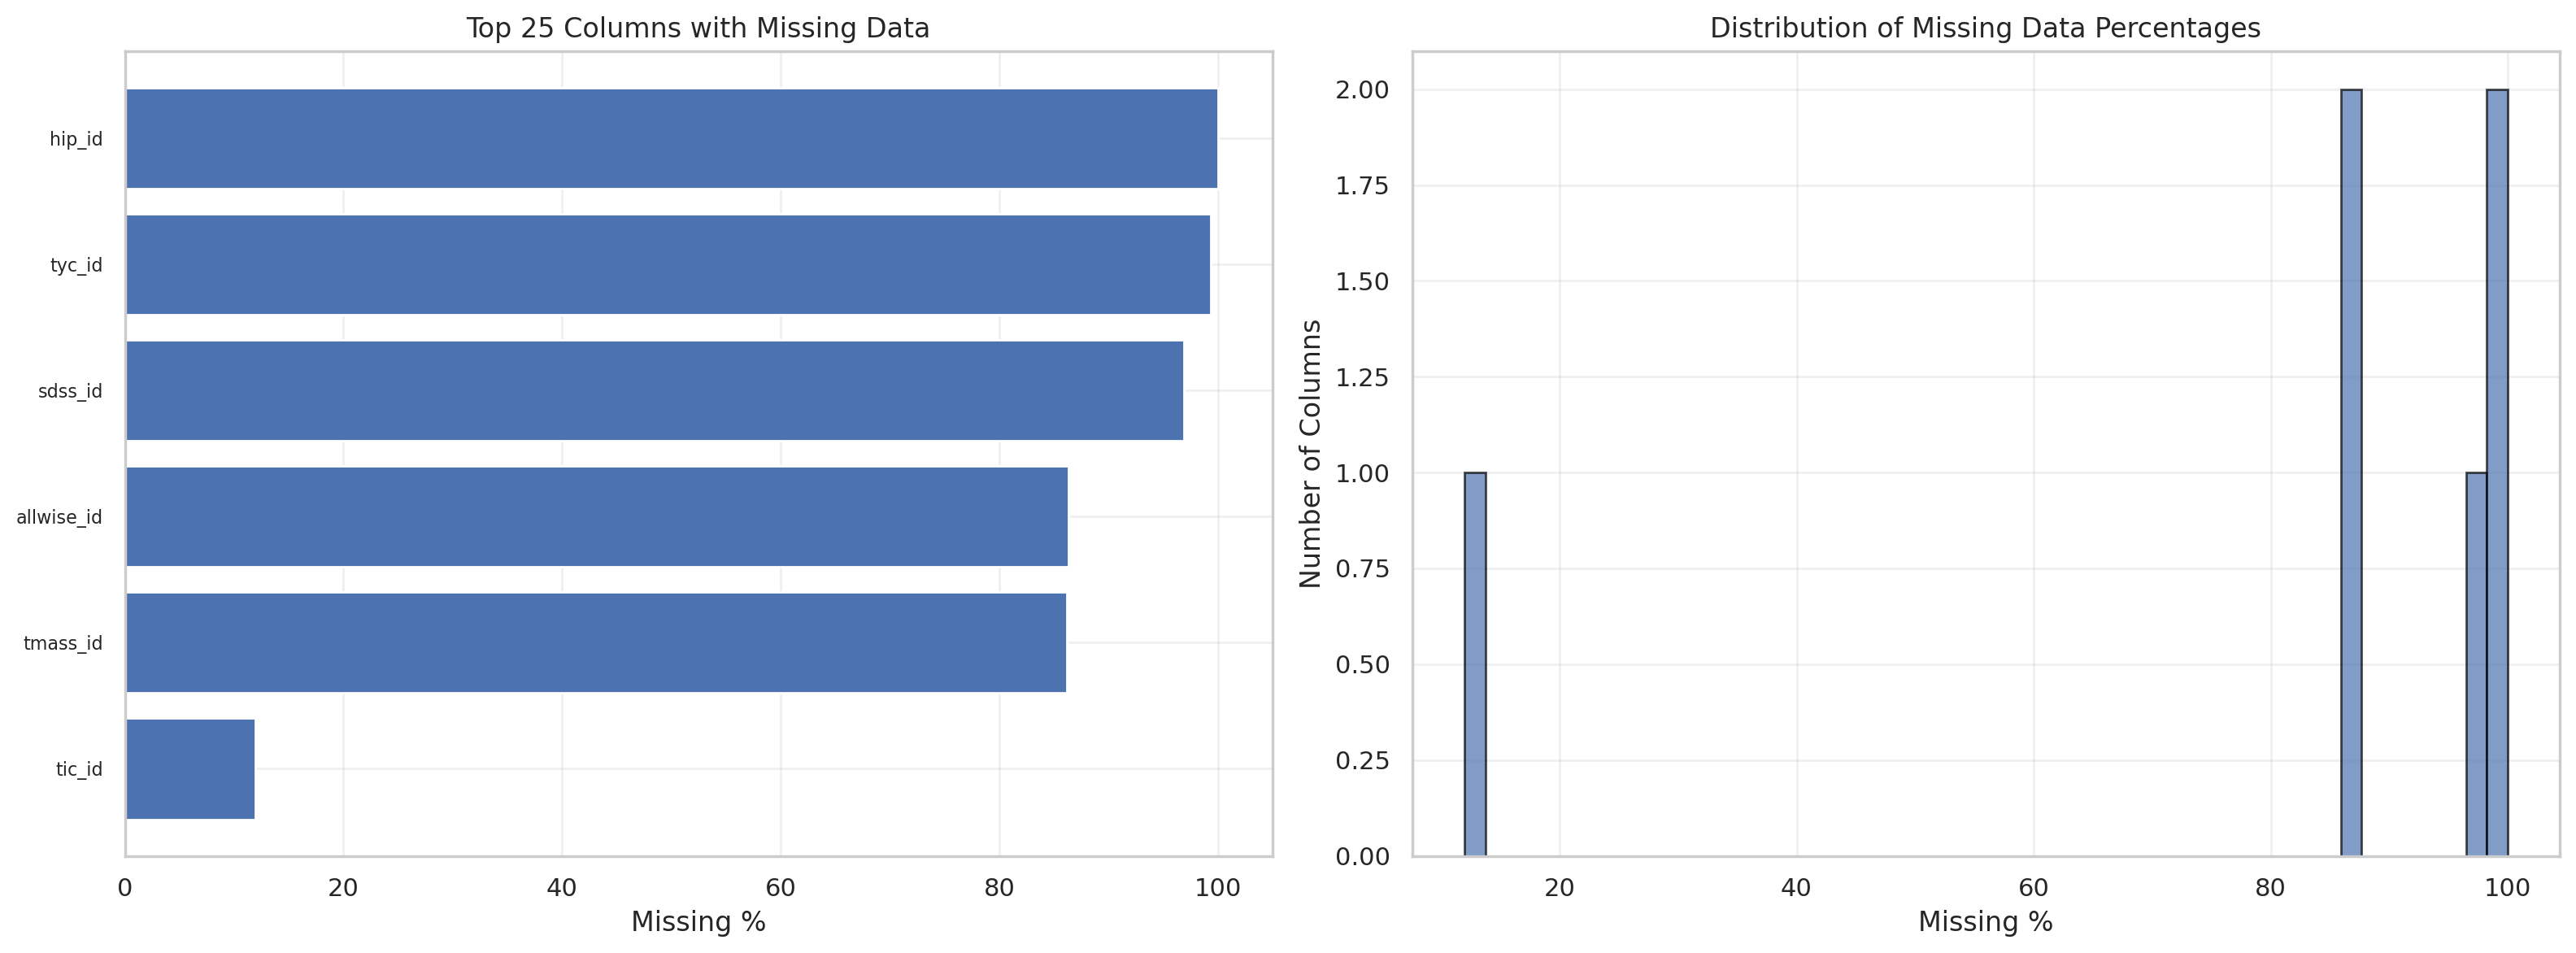

In [24]:
# Comprehensive missing data analysis
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'count': missing,
    'percent': missing_pct
}).sort_values('percent', ascending=False)

print("Missing Data Summary:")
print(f"Total columns: {len(df.columns)}")
print(f"Columns with missing data: {(missing > 0).sum()}")
print(f"Columns completely filled: {(missing == 0).sum()}")
print(f"\nTop 20 columns with most missing data:")
print(missing_df.head(20))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of top missing
top_missing = missing_df[missing_df['count'] > 0].head(25)
if len(top_missing) > 0:
    axes[0].barh(range(len(top_missing)), top_missing['percent'])
    axes[0].set_yticks(range(len(top_missing)))
    axes[0].set_yticklabels(top_missing.index, fontsize=8)
    axes[0].set_xlabel('Missing %')
    axes[0].set_title('Top 25 Columns with Missing Data')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3)

# Histogram of missing percentages
axes[1].hist(missing_pct[missing_pct > 0], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Missing %')
axes[1].set_ylabel('Number of Columns')
axes[1].set_title('Distribution of Missing Data Percentages')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Cross-Catalog Coverage Analysis

Cross-Catalog Coverage:
                count     percent
ASAS-SN    16999525.0  100.000000
Gaia       16999525.0  100.000000
TIC        14967082.0   88.044119
2MASS       2351856.0   13.834834
AllWISE     2320967.0   13.653129
SDSS         527349.0    3.102140
Tycho        105593.0    0.621153
Hipparcos       157.0    0.000924


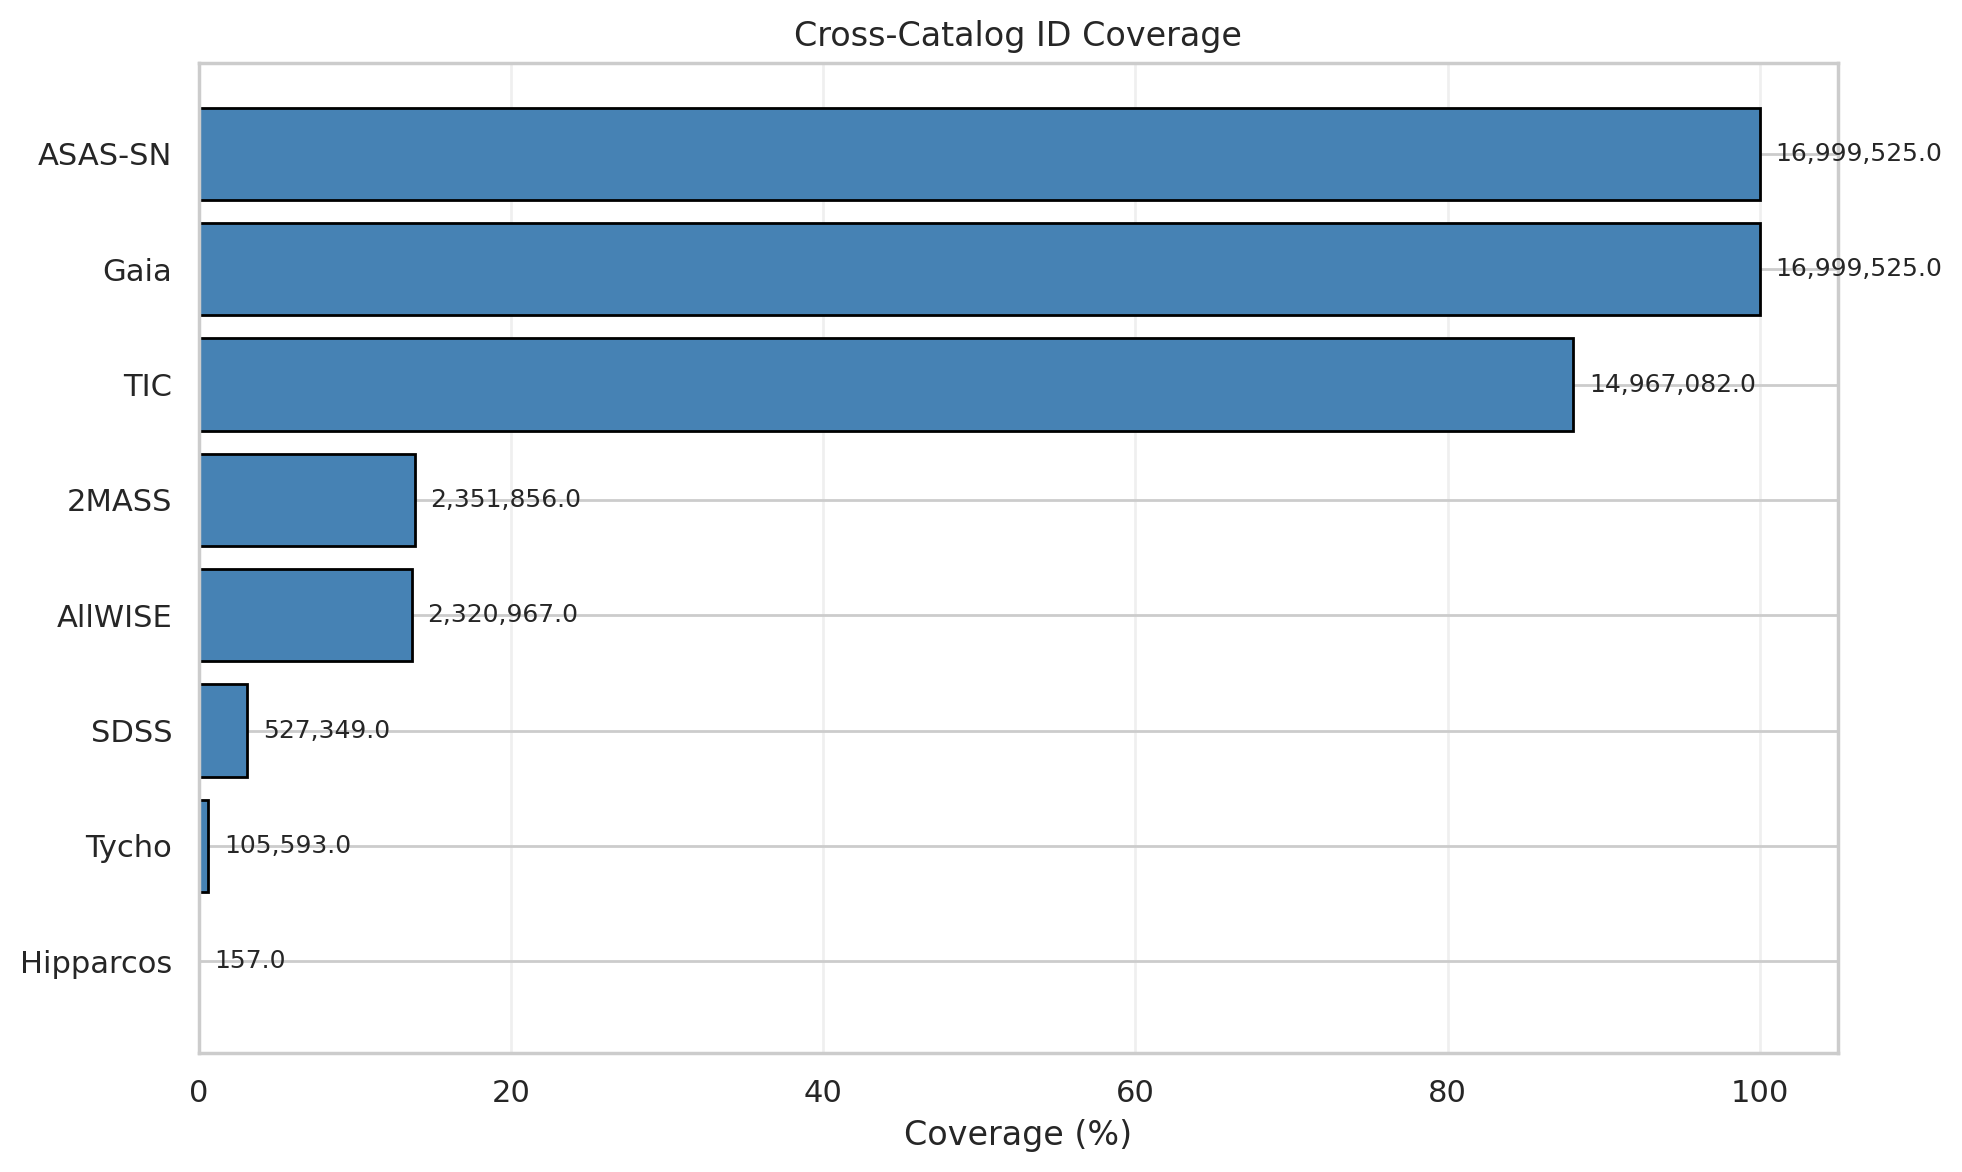

In [25]:
# Analyze cross-catalog ID coverage
catalog_ids = {
    'ASAS-SN': 'asas_sn_id',
    'Gaia': 'gaia_id',
    'Hipparcos': 'hip_id',
    'Tycho': 'tyc_id',
    '2MASS': 'tmass_id',
    'SDSS': 'sdss_id',
    'AllWISE': 'allwise_id',
    'TIC': 'tic_id',
}

coverage = {}
for cat_name, col_name in catalog_ids.items():
    if col_name in df.columns:
        n_valid = df[col_name].notna().sum()
        coverage[cat_name] = {
            'count': n_valid,
            'percent': 100 * n_valid / len(df)
        }

coverage_df = pd.DataFrame(coverage).T.sort_values('percent', ascending=False)
print("Cross-Catalog Coverage:")
print(coverage_df)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(coverage_df.index, coverage_df['percent'], color='steelblue', edgecolor='black')
ax.set_xlabel('Coverage (%)')
ax.set_title('Cross-Catalog ID Coverage')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
for i, (idx, row) in enumerate(coverage_df.iterrows()):
    ax.text(row['percent'] + 1, i, f"{row['count']:,}", va='center', fontsize=9)
plt.tight_layout()
plt.show()

## 4. Multi-Band Photometry Analysis

In [26]:
# Analyze photometric coverage across all bands
phot_cols = {
    'Gaia G': 'gaia_mag',
    'Gaia BP': 'gaia_b_mag',
    'Gaia RP': 'gaia_r_mag',
    'PS1 g': 'pstarrs_g_mag',
    'PS1 r': 'pstarrs_r_mag',
    'PS1 i': 'pstarrs_i_mag',
    'PS1 z': 'pstarrs_z_mag',
}

phot_stats = {}
for band_name, col_name in phot_cols.items():
    if col_name in df.columns:
        data = df[col_name].dropna()
        if len(data) > 0:
            phot_stats[band_name] = {
                'N': len(data),
                'coverage_%': 100 * len(data) / len(df),
                'min': data.min(),
                'p05': data.quantile(0.05),
                'p50': data.median(),
                'p95': data.quantile(0.95),
                'max': data.max(),
                'std': data.std()
            }

phot_stats_df = pd.DataFrame(phot_stats).T
print("Multi-Band Photometry Statistics:")
print(phot_stats_df.round(2))

Multi-Band Photometry Statistics:
                  N  coverage_%    min    p05    p50    p95    max   std
Gaia G   16999525.0       100.0   6.48  11.84  13.53  14.48  20.78  0.84
Gaia BP  16999525.0       100.0   0.00  12.36  14.03  14.86  20.97  0.87
Gaia RP  16999525.0       100.0   0.00  11.10  12.91  13.97  18.98  0.98
PS1 g    16999525.0       100.0  12.00  12.45  14.14  14.93  15.00  0.78
PS1 r    16999525.0       100.0   8.64  11.88  13.53  14.47  19.79  0.81
PS1 i    16999525.0       100.0   6.01  11.52  13.28  14.33  20.26  0.89
PS1 z    16999525.0       100.0   4.56  11.28  13.18  14.29  22.50  0.96


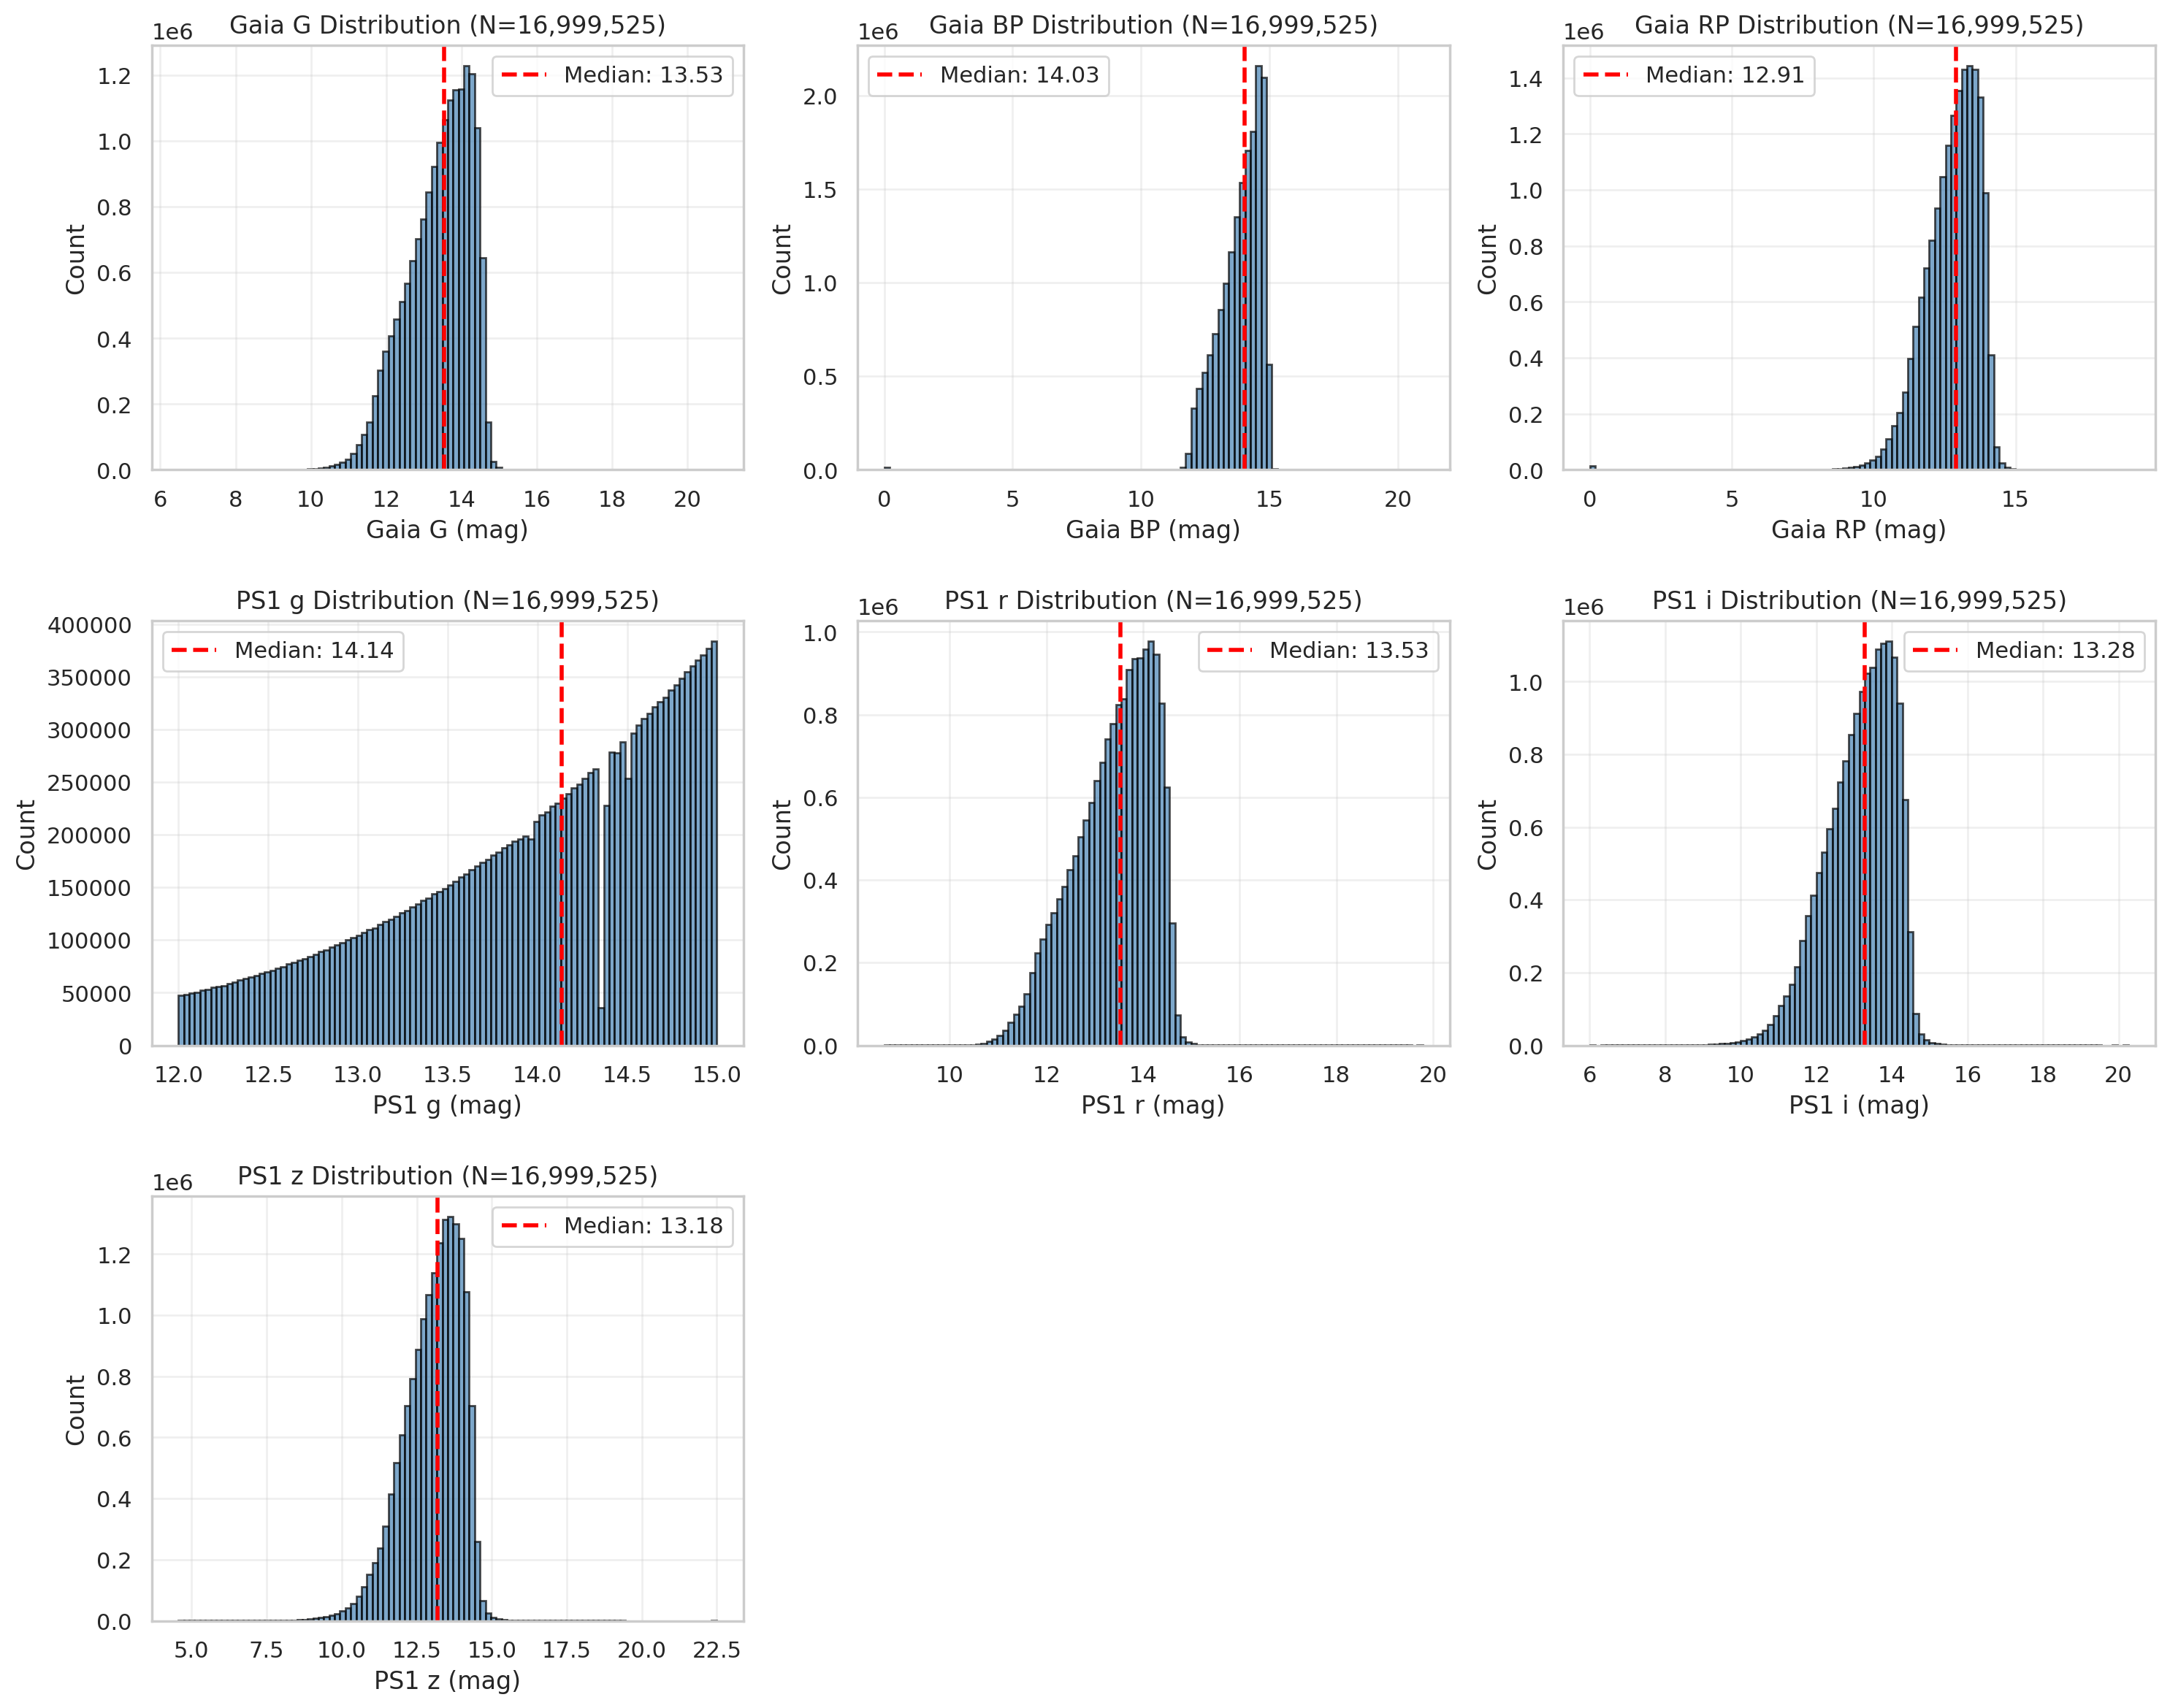

In [27]:
# Magnitude distributions for all available bands
available_mags = [col for col in phot_cols.values() if col in df.columns]

if available_mags:
    n_plots = len(available_mags)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.ravel() if n_plots > 1 else [axes]
    
    for i, col in enumerate(available_mags):
        data = df[col].dropna()
        band_label = [k for k, v in phot_cols.items() if v == col][0]
        
        axes[i].hist(data, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
        axes[i].axvline(data.median(), color='red', linestyle='--', linewidth=2, 
                       label=f'Median: {data.median():.2f}')
        axes[i].set_xlabel(f'{band_label} (mag)')
        axes[i].set_ylabel('Count')
        axes[i].set_title(f'{band_label} Distribution (N={len(data):,})')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## 5. Color-Color Diagrams and Stellar Populations

In [28]:
# Compute all available colors
print("Computing colors...")

# Gaia colors
if 'gaia_b_mag' in df.columns and 'gaia_r_mag' in df.columns:
    df_temp = df.copy()
    df_temp['BP_RP'] = df['gaia_b_mag'] - df['gaia_r_mag']
    print(f"BP-RP: {df_temp['BP_RP'].notna().sum():,} sources")

# Pan-STARRS colors
if 'pstarrs_g_mag' in df.columns and 'pstarrs_r_mag' in df.columns:
    df_temp['g_r'] = df['pstarrs_g_mag'] - df['pstarrs_r_mag']
    print(f"g-r: {df_temp['g_r'].notna().sum():,} sources")

if 'pstarrs_r_mag' in df.columns and 'pstarrs_i_mag' in df.columns:
    df_temp['r_i'] = df['pstarrs_r_mag'] - df['pstarrs_i_mag']
    print(f"r-i: {df_temp['r_i'].notna().sum():,} sources")

if 'pstarrs_i_mag' in df.columns and 'pstarrs_z_mag' in df.columns:
    df_temp['i_z'] = df['pstarrs_i_mag'] - df['pstarrs_z_mag']
    print(f"i-z: {df_temp['i_z'].notna().sum():,} sources")

# Cross-survey color
if 'gaia_mag' in df.columns and 'pstarrs_g_mag' in df.columns:
    df_temp['Gmag_psg'] = df['gaia_mag'] - df['pstarrs_g_mag']
    print(f"G-g(PS): {df_temp['Gmag_psg'].notna().sum():,} sources")

Computing colors...
BP-RP: 16,999,525 sources
g-r: 16,999,525 sources
r-i: 16,999,525 sources
i-z: 16,999,525 sources
G-g(PS): 16,999,525 sources


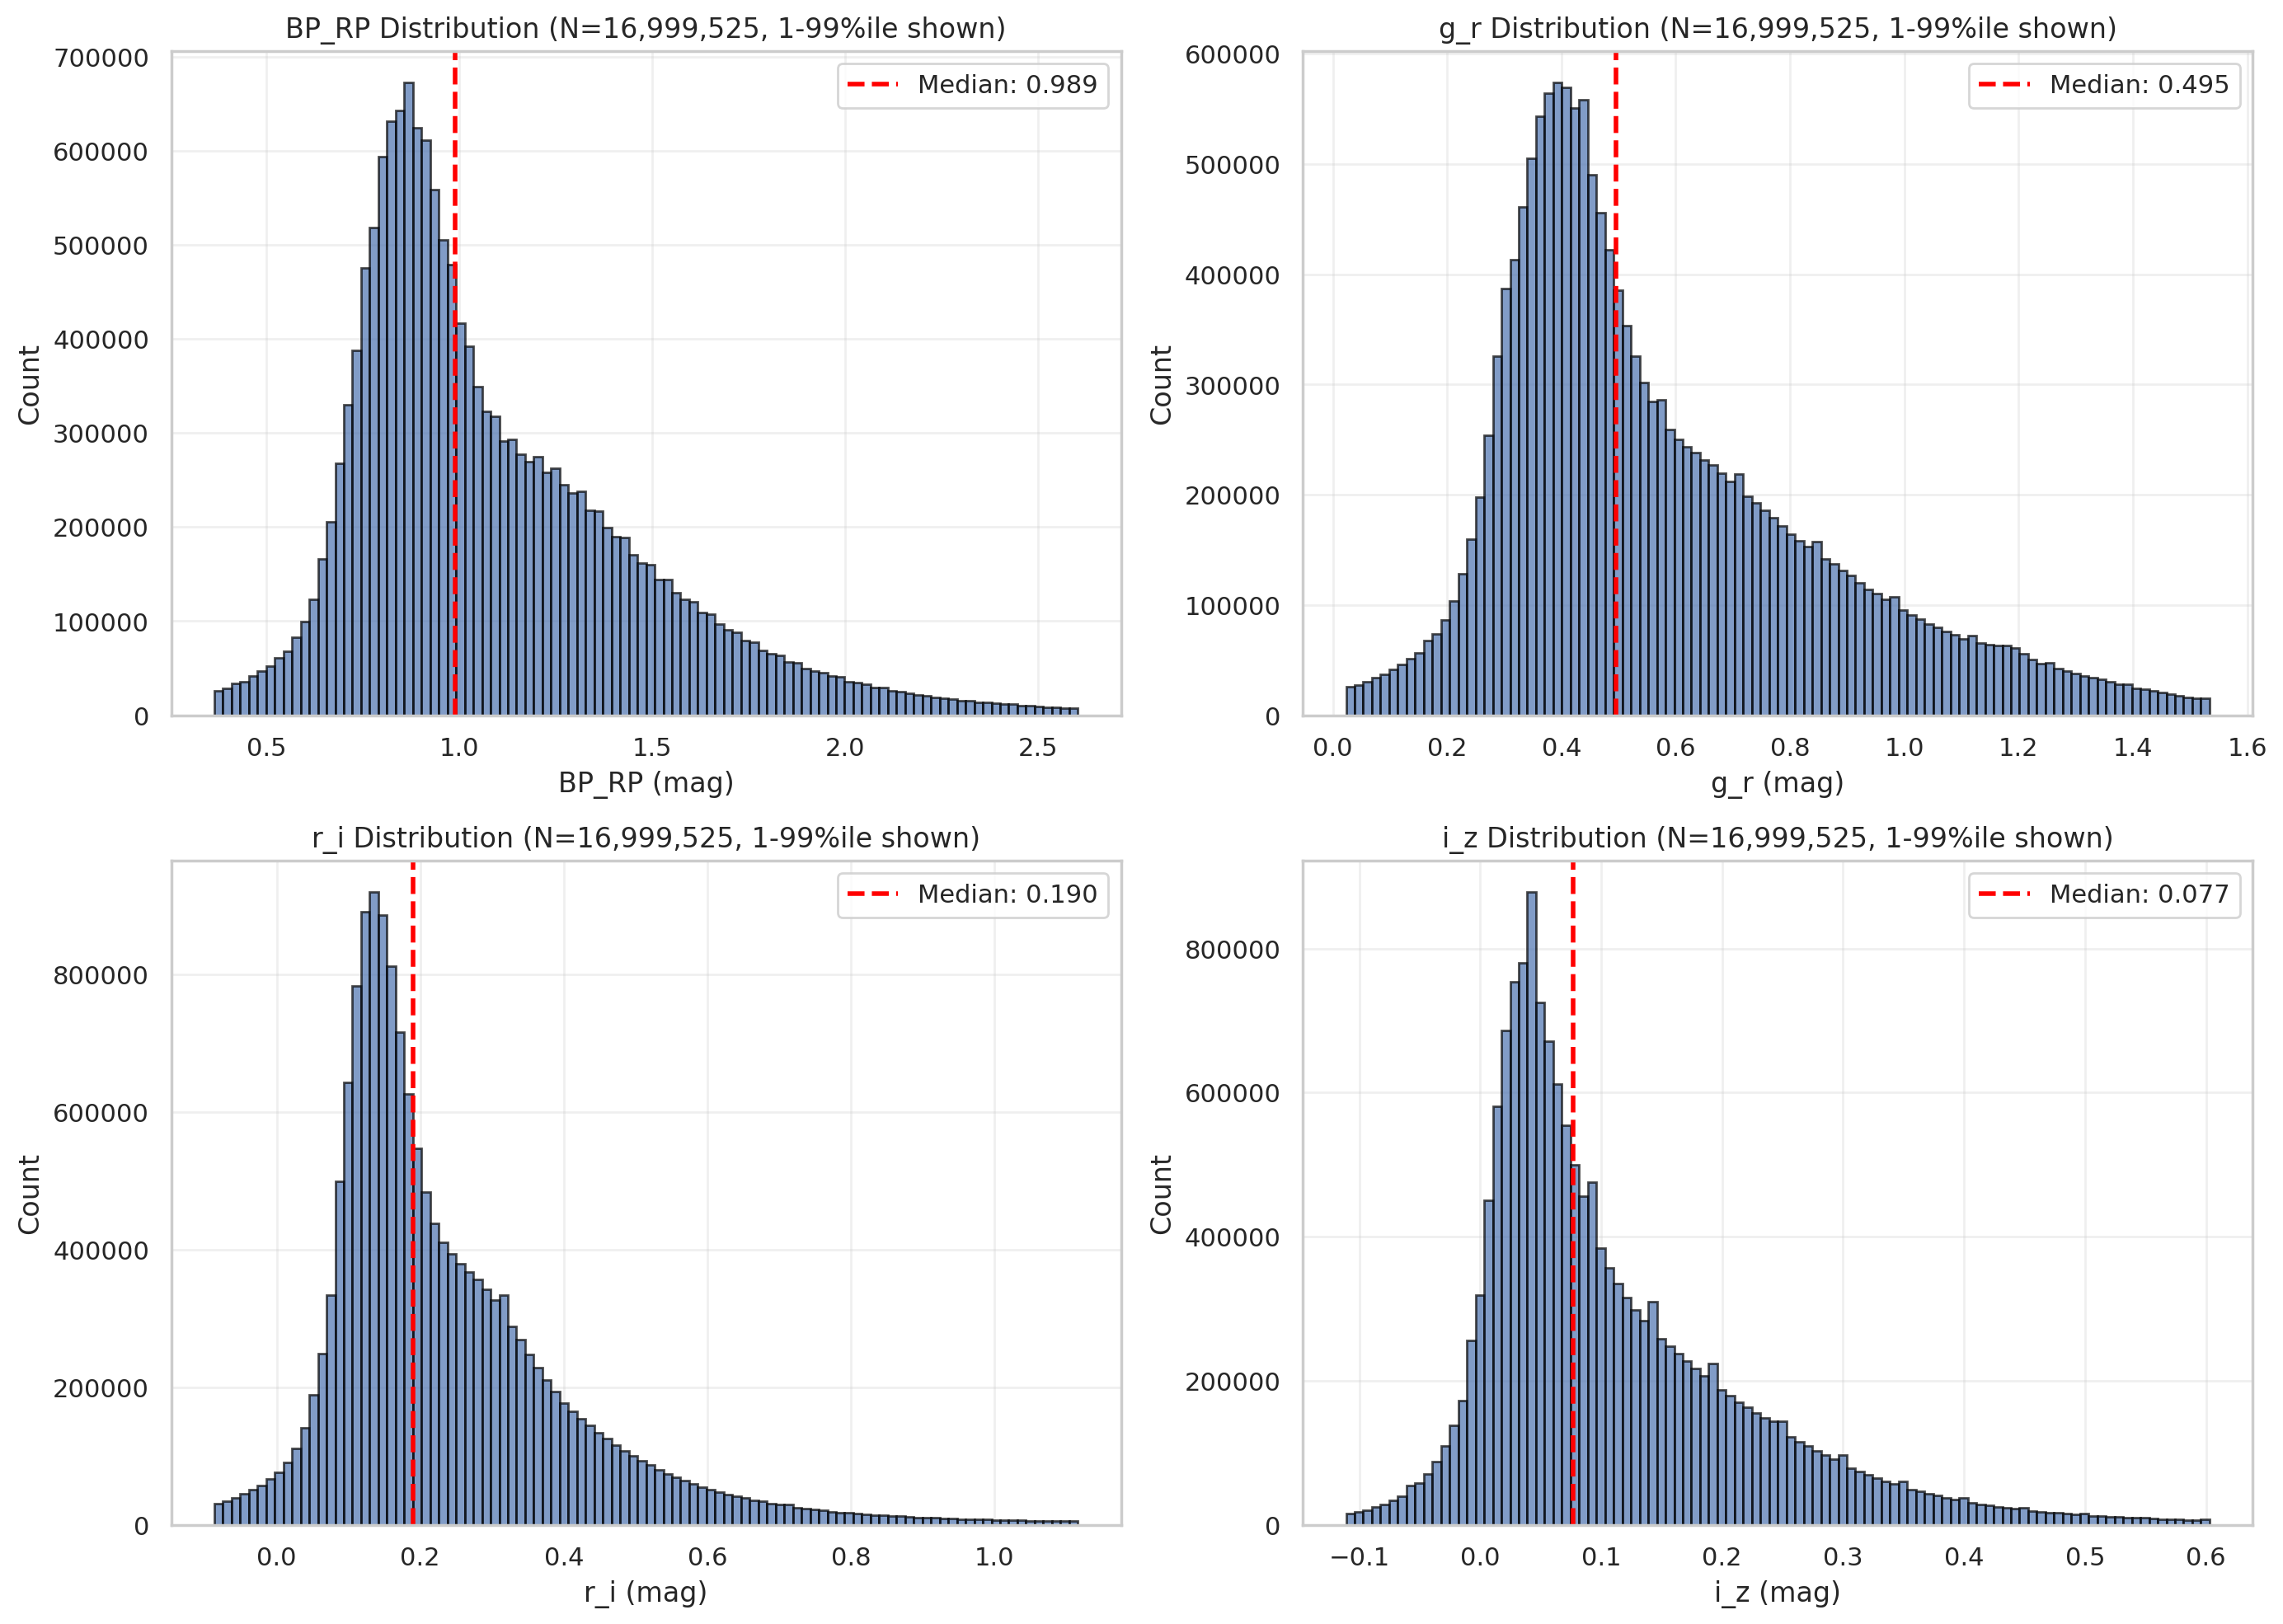

In [29]:
# Color distributions
color_cols = [c for c in df_temp.columns if c in ['BP_RP', 'g_r', 'r_i', 'i_z']]

if color_cols:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(color_cols[:4]):
        data = df_temp[col].dropna()
        if len(data) > 0:
            # Remove extreme outliers for visualization
            q01, q99 = data.quantile([0.01, 0.99])
            data_clipped = data[(data >= q01) & (data <= q99)]
            
            axes[i].hist(data_clipped, bins=100, edgecolor='black', alpha=0.7)
            axes[i].axvline(data.median(), color='red', linestyle='--', linewidth=2,
                           label=f'Median: {data.median():.3f}')
            axes[i].set_xlabel(f'{col} (mag)')
            axes[i].set_ylabel('Count')
            axes[i].set_title(f'{col} Distribution (N={len(data):,}, 1-99%ile shown)')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

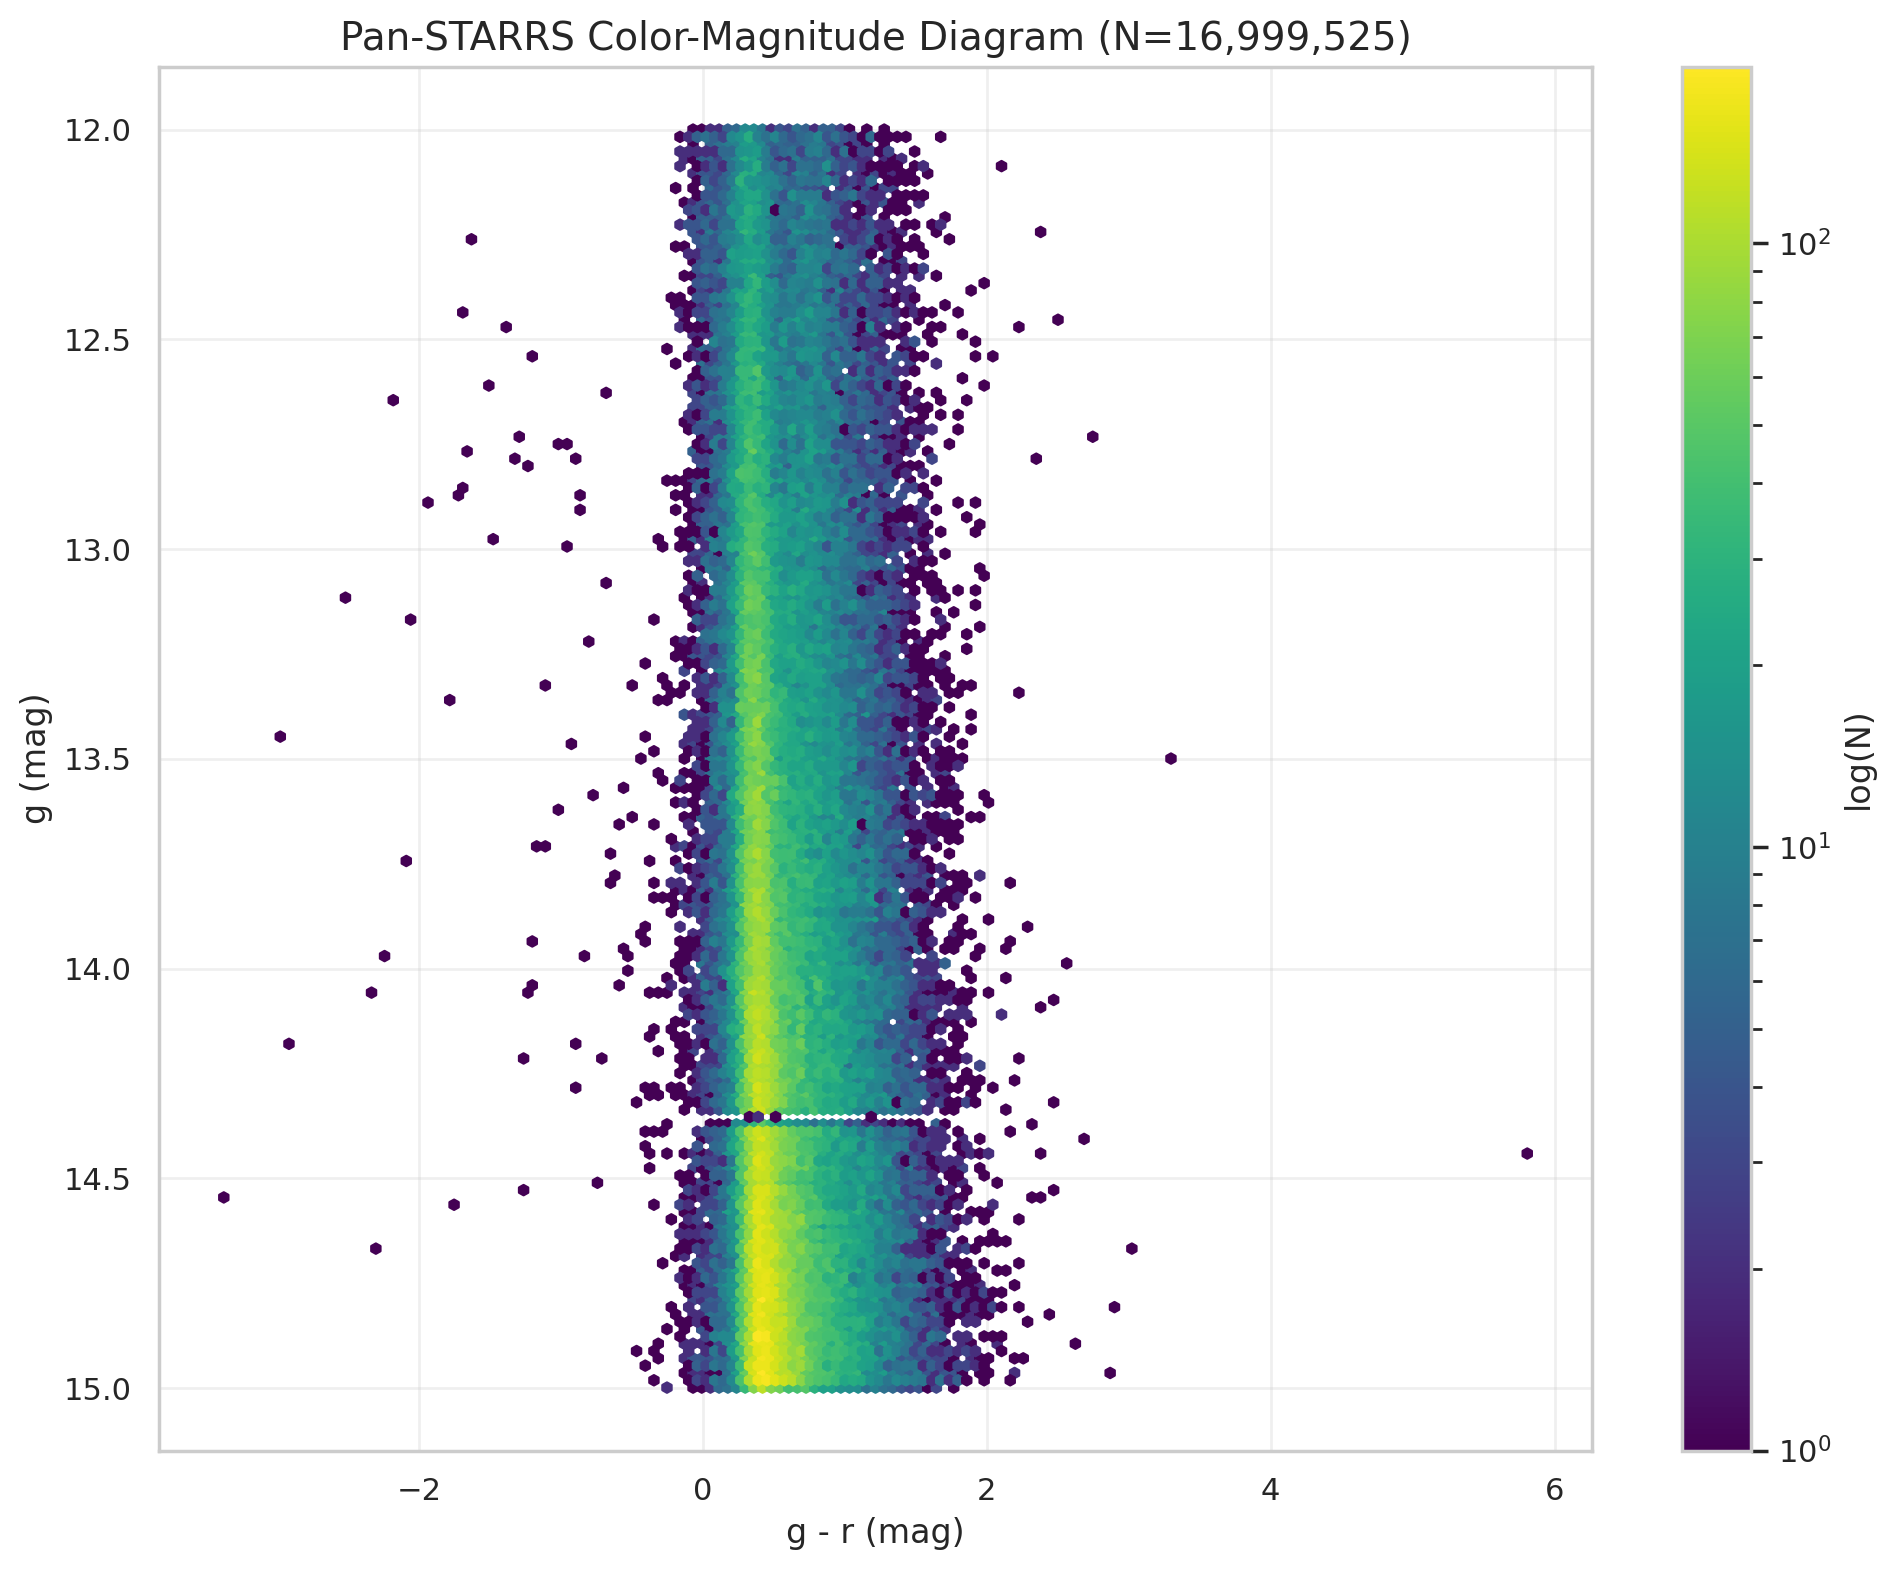


CMD Statistics:
  g-r range: [-6.81, 5.81]
  g range: [12.00, 15.00]


In [30]:
# Color-Magnitude Diagrams
if 'g_r' in df_temp.columns and 'pstarrs_g_mag' in df.columns:
    # Pan-STARRS CMD
    df_cmd = df_temp[['g_r', 'pstarrs_g_mag']].dropna()
    sample = df_cmd.sample(min(100000, len(df_cmd)))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    h = ax.hexbin(sample['g_r'], sample['pstarrs_g_mag'], 
                  gridsize=150, cmap='viridis', mincnt=1, bins='log')
    ax.set_xlabel('g - r (mag)', fontsize=12)
    ax.set_ylabel('g (mag)', fontsize=12)
    ax.set_title(f'Pan-STARRS Color-Magnitude Diagram (N={len(df_cmd):,})', fontsize=14)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3)
    cbar = plt.colorbar(h, ax=ax)
    cbar.set_label('log(N)', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print(f"\nCMD Statistics:")
    print(f"  g-r range: [{df_cmd['g_r'].min():.2f}, {df_cmd['g_r'].max():.2f}]")
    print(f"  g range: [{df_cmd['pstarrs_g_mag'].min():.2f}, {df_cmd['pstarrs_g_mag'].max():.2f}]")

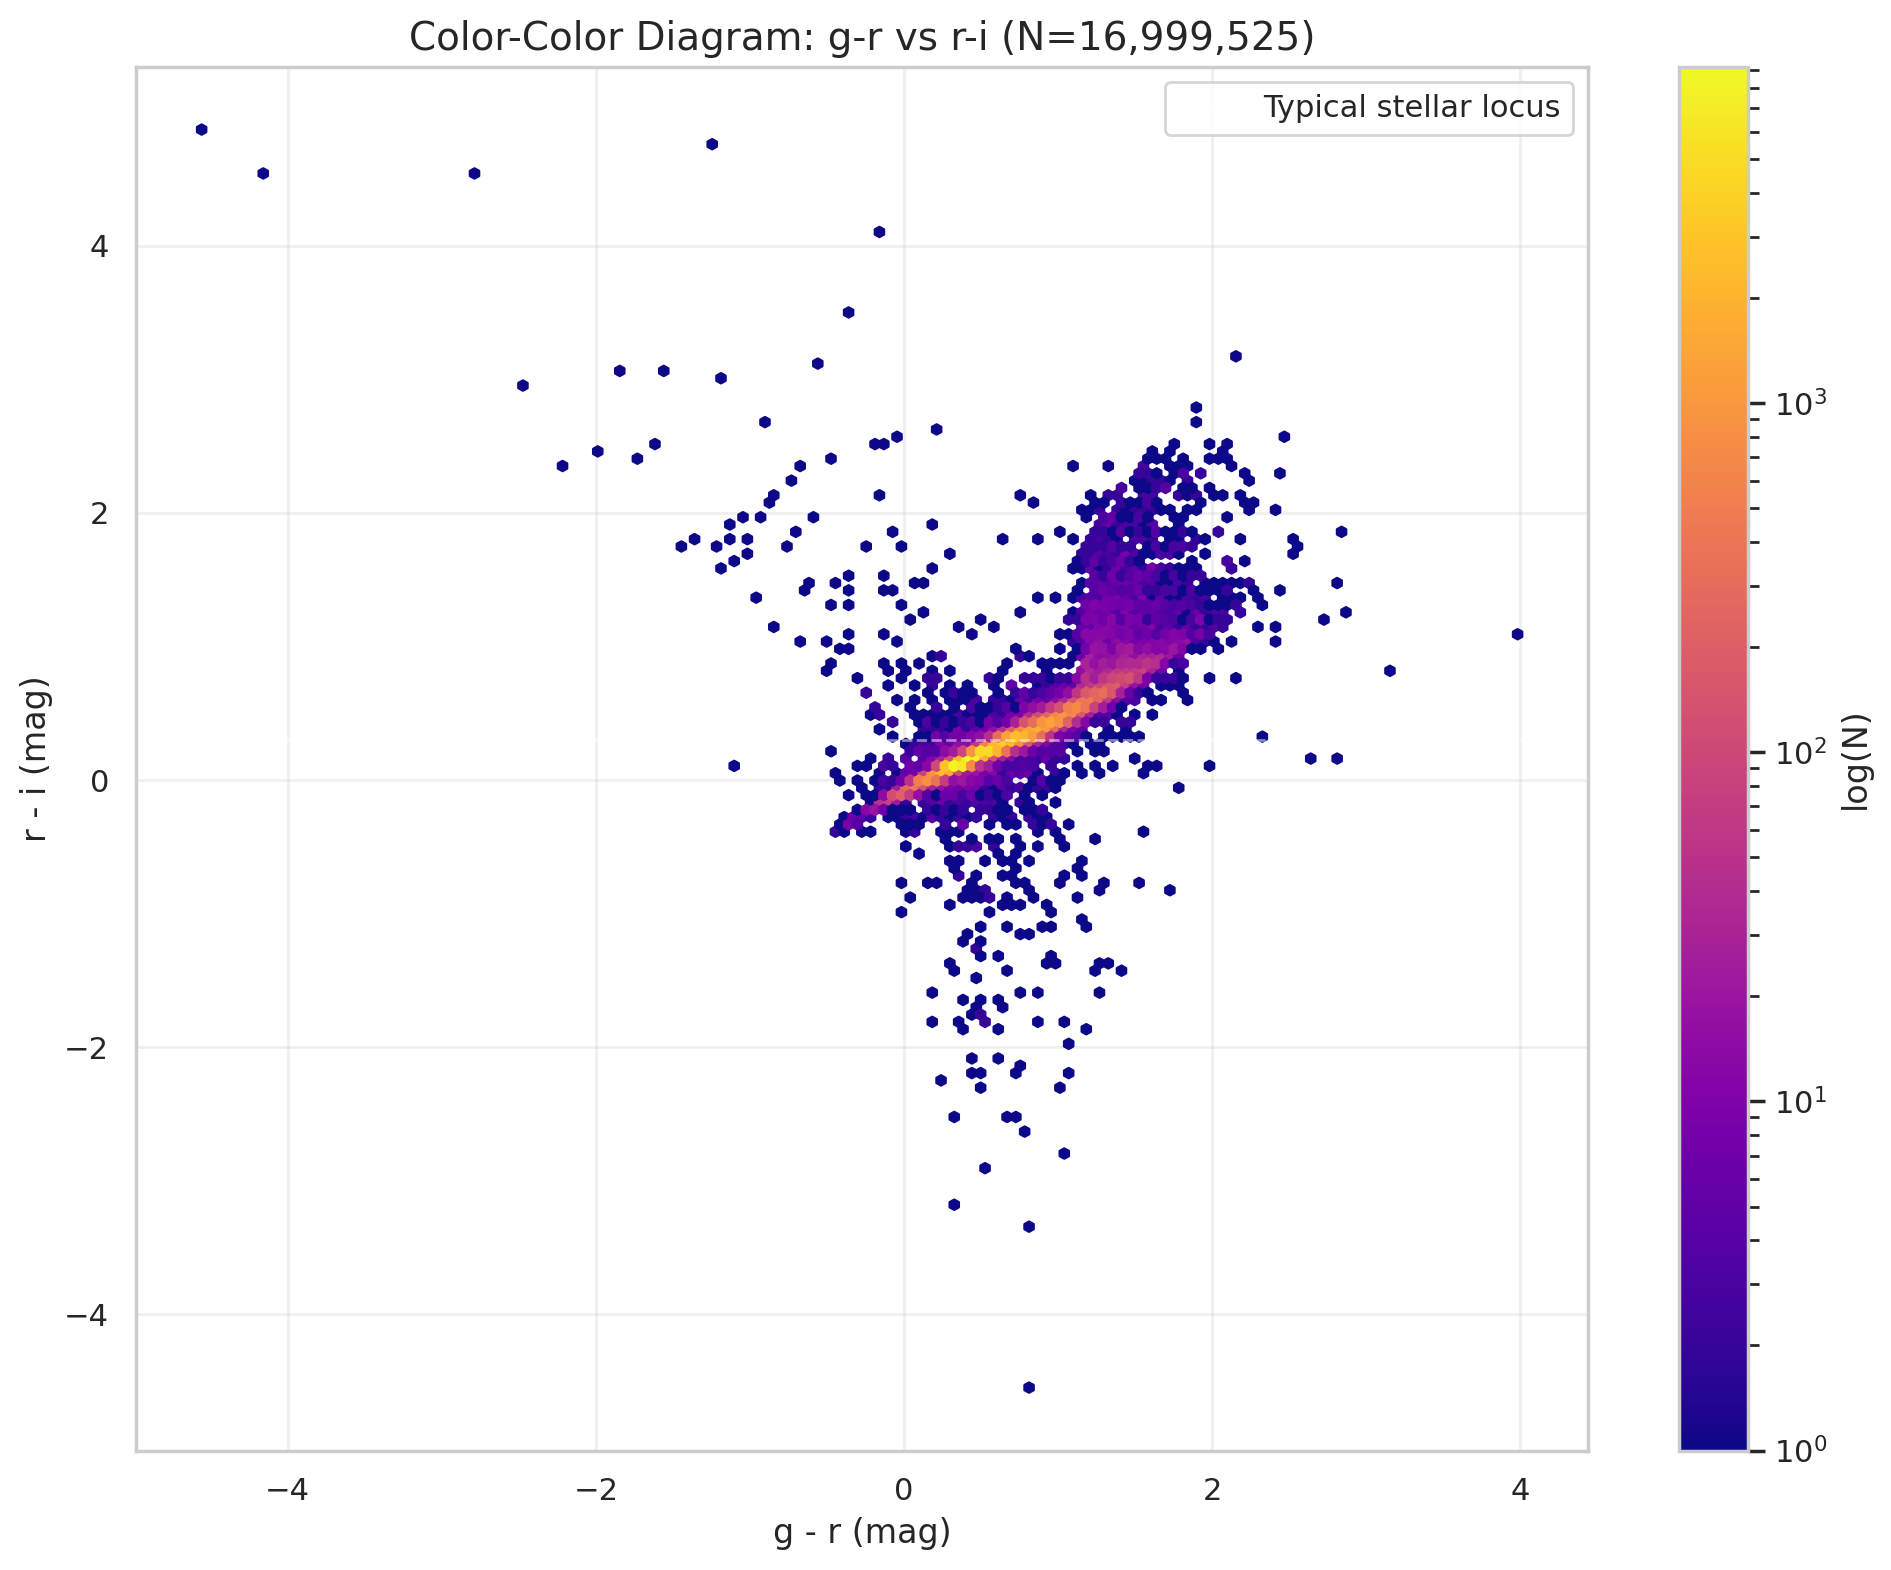

In [31]:
# Color-Color Diagrams for stellar population analysis
if 'g_r' in df_temp.columns and 'r_i' in df_temp.columns:
    df_cc = df_temp[['g_r', 'r_i']].dropna()
    sample = df_cc.sample(min(100000, len(df_cc)))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    h = ax.hexbin(sample['g_r'], sample['r_i'], 
                  gridsize=150, cmap='plasma', mincnt=1, bins='log')
    ax.set_xlabel('g - r (mag)', fontsize=12)
    ax.set_ylabel('r - i (mag)', fontsize=12)
    ax.set_title(f'Color-Color Diagram: g-r vs r-i (N={len(df_cc):,})', fontsize=14)
    ax.grid(True, alpha=0.3)
    cbar = plt.colorbar(h, ax=ax)
    cbar.set_label('log(N)', fontsize=12)
    
    # Add stellar sequence guide lines (approximate)
    ax.axhline(0.3, color='white', linestyle='--', alpha=0.5, linewidth=1, label='Typical stellar locus')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

## 6. Gaia-Specific Analysis

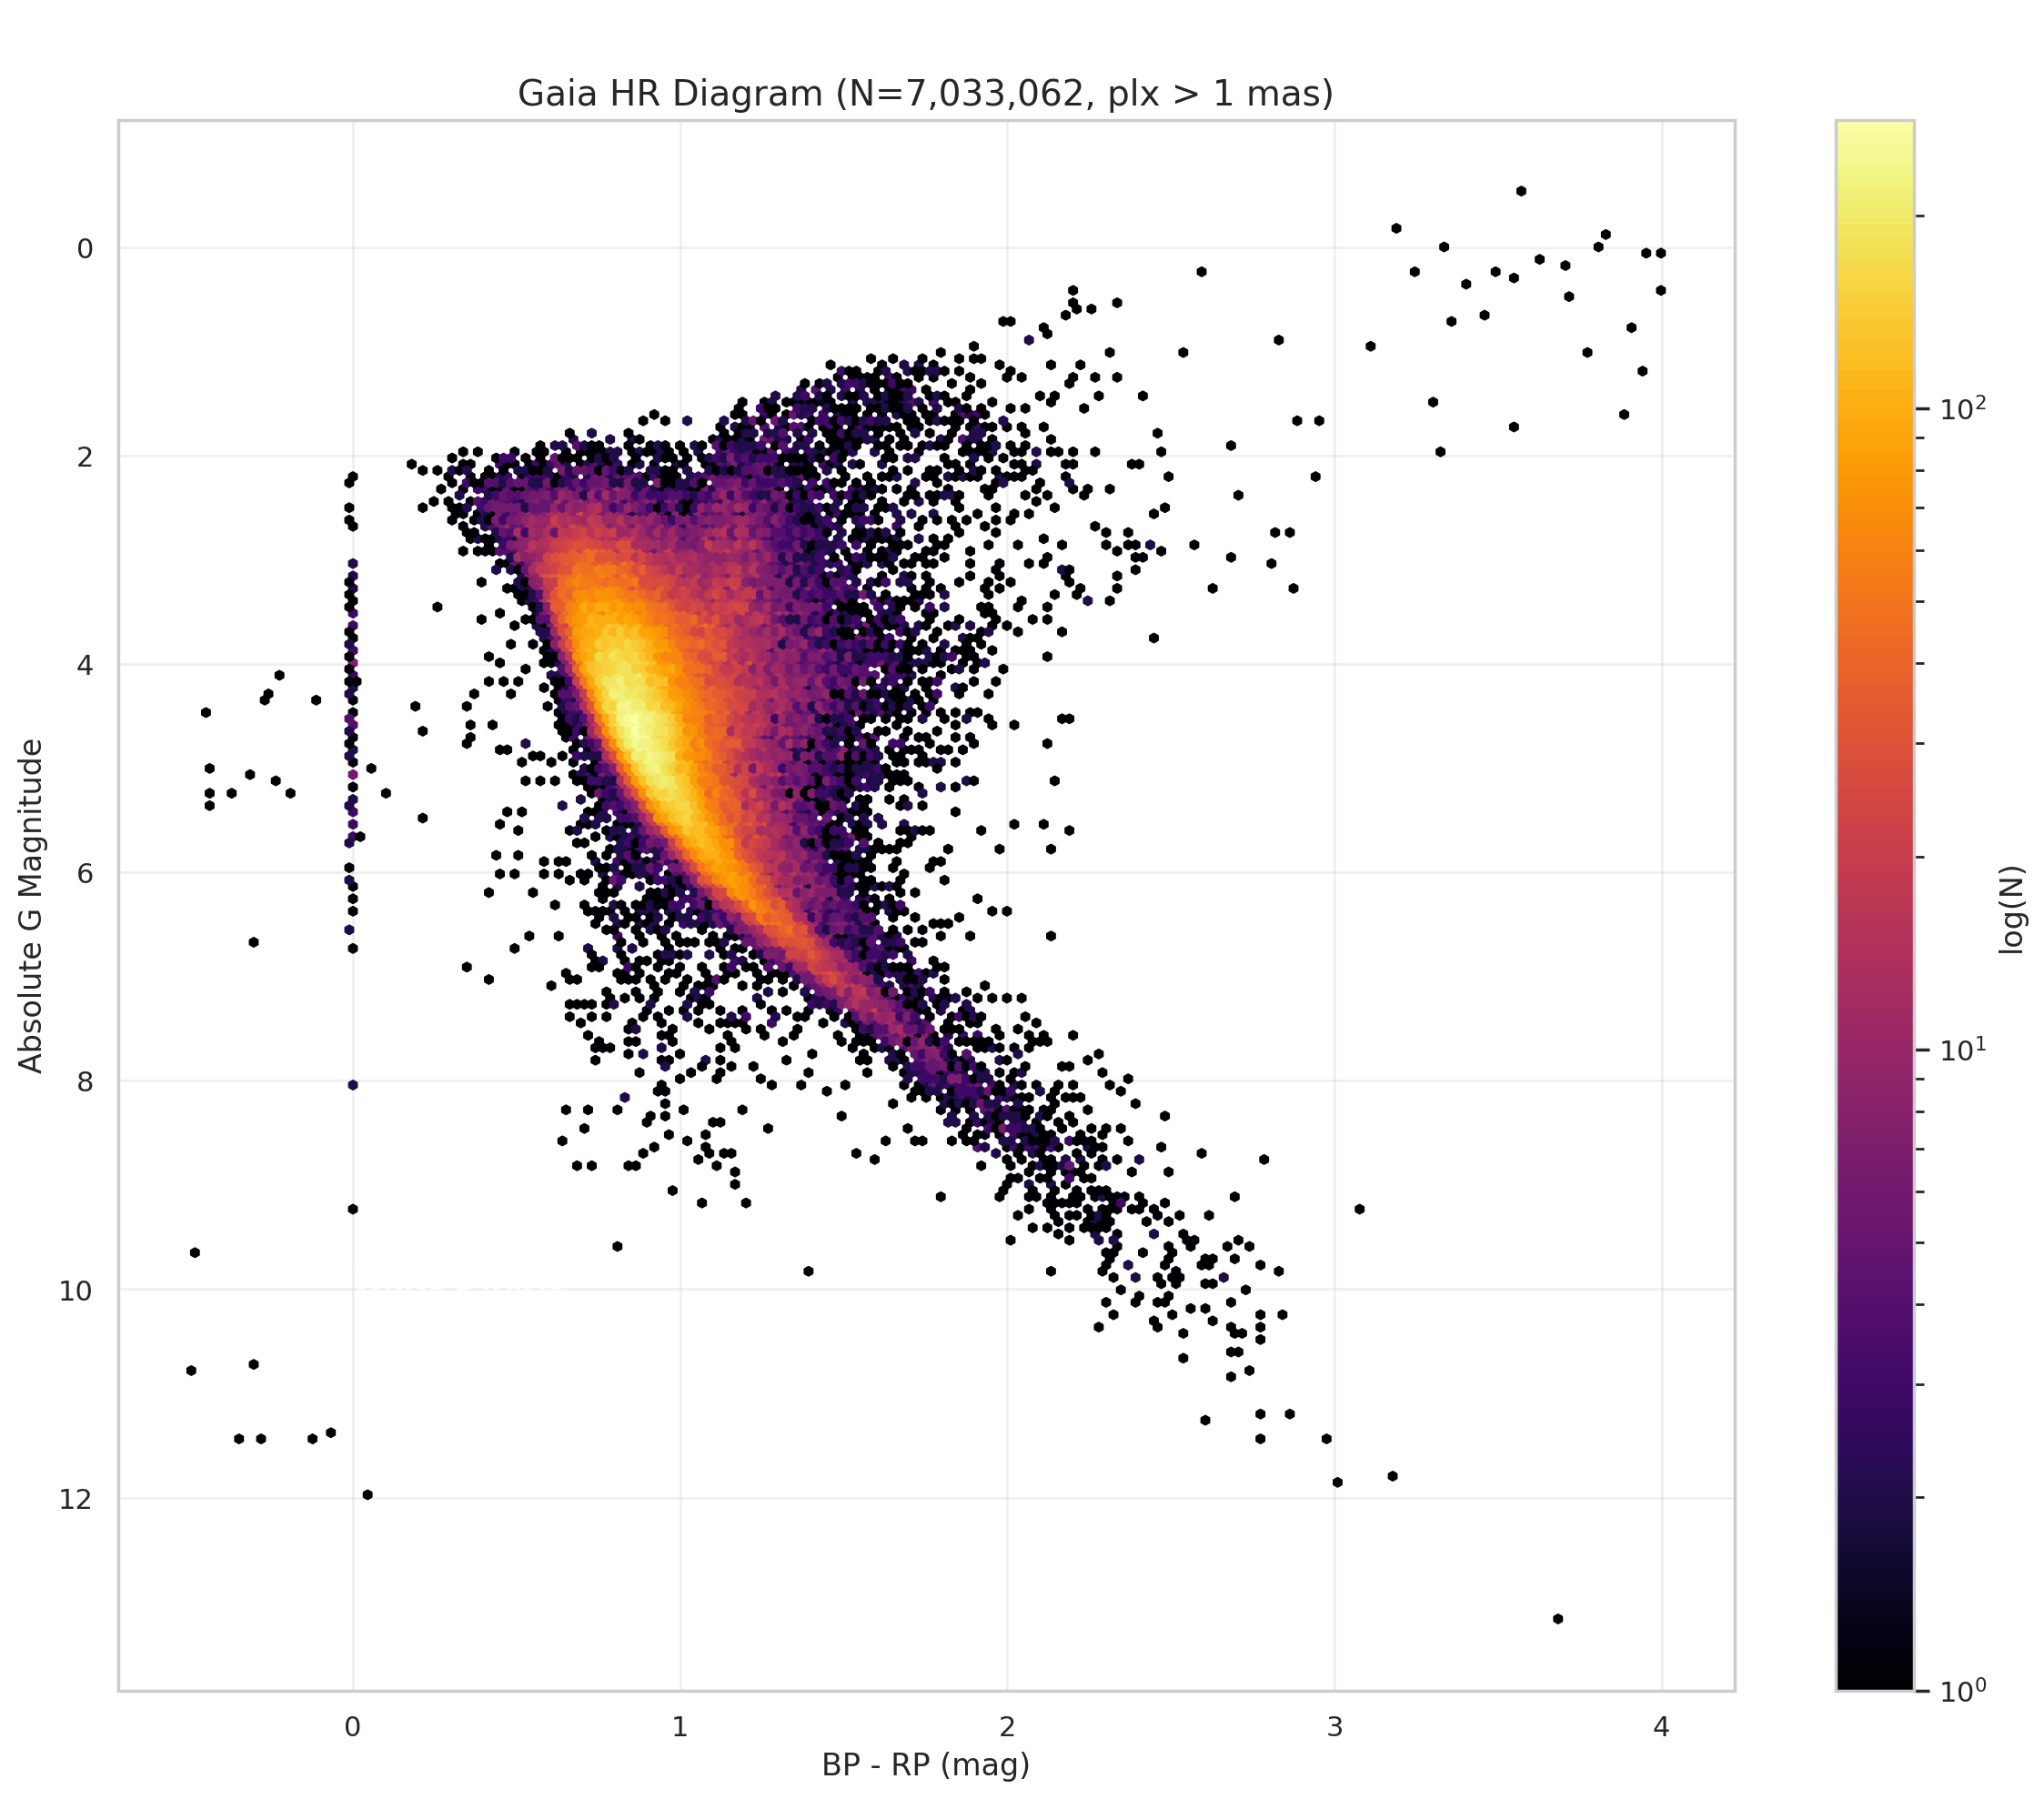

HR Diagram constructed with 7,033,062 sources
BP-RP range: [-0.50, 4.00]
Abs G range: [-1.63, 14.82]


In [32]:
# Gaia HR Diagram (BP-RP vs absolute G magnitude)
if all(c in df.columns for c in ['gaia_b_mag', 'gaia_r_mag', 'gaia_mag', 'plx']):
    # Compute absolute magnitude from parallax
    df_hr = df[['gaia_b_mag', 'gaia_r_mag', 'gaia_mag', 'plx']].dropna()
    # Only use sources with good parallax (>1 mas, SNR>5)
    if 'plx_d' in df.columns:
        df_hr = df.loc[df_hr.index].copy()
        df_hr = df_hr[(df_hr['plx'] > 1) & (df_hr['plx'] / df_hr['plx_d'] > 5)]
    else:
        df_hr = df_hr[df_hr['plx'] > 1]
    
    if len(df_hr) > 0:
        df_hr['BP_RP'] = df_hr['gaia_b_mag'] - df_hr['gaia_r_mag']
        df_hr['abs_G'] = df_hr['gaia_mag'] + 5 * np.log10(df_hr['plx'] / 100)  # Distance modulus
        
        # Remove extreme outliers
        df_hr = df_hr[(df_hr['abs_G'] > -5) & (df_hr['abs_G'] < 15) & 
                      (df_hr['BP_RP'] > -0.5) & (df_hr['BP_RP'] < 4)]
        
        sample = df_hr.sample(min(100000, len(df_hr)))
        
        fig, ax = plt.subplots(figsize=(12, 10))
        h = ax.hexbin(sample['BP_RP'], sample['abs_G'], 
                      gridsize=200, cmap='inferno', mincnt=1, bins='log')
        ax.set_xlabel('BP - RP (mag)', fontsize=12)
        ax.set_ylabel('Absolute G Magnitude', fontsize=12)
        ax.set_title(f'Gaia HR Diagram (N={len(df_hr):,}, plx > 1 mas)', fontsize=14)
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3)
        cbar = plt.colorbar(h, ax=ax)
        cbar.set_label('log(N)', fontsize=12)
        
        # Add labels for stellar populations
        ax.text(0.5, -2, 'Main Sequence', fontsize=11, color='white', weight='bold')
        ax.text(1.5, -2, 'Red Giants', fontsize=11, color='white', weight='bold')
        ax.text(0.0, 10, 'White Dwarfs', fontsize=11, color='white', weight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print(f"HR Diagram constructed with {len(df_hr):,} sources")
        print(f"BP-RP range: [{df_hr['BP_RP'].min():.2f}, {df_hr['BP_RP'].max():.2f}]")
        print(f"Abs G range: [{df_hr['abs_G'].min():.2f}, {df_hr['abs_G'].max():.2f}]")
    else:
        print("Insufficient parallax data for HR diagram")
else:
    print("Required columns for HR diagram not available")

Gaia Variability Classification:
gaia_var
2    15221718
6     1729263
1       38507
5       10037
Name: count, dtype: int64

Variable sources: 16,999,525 (100.00%)


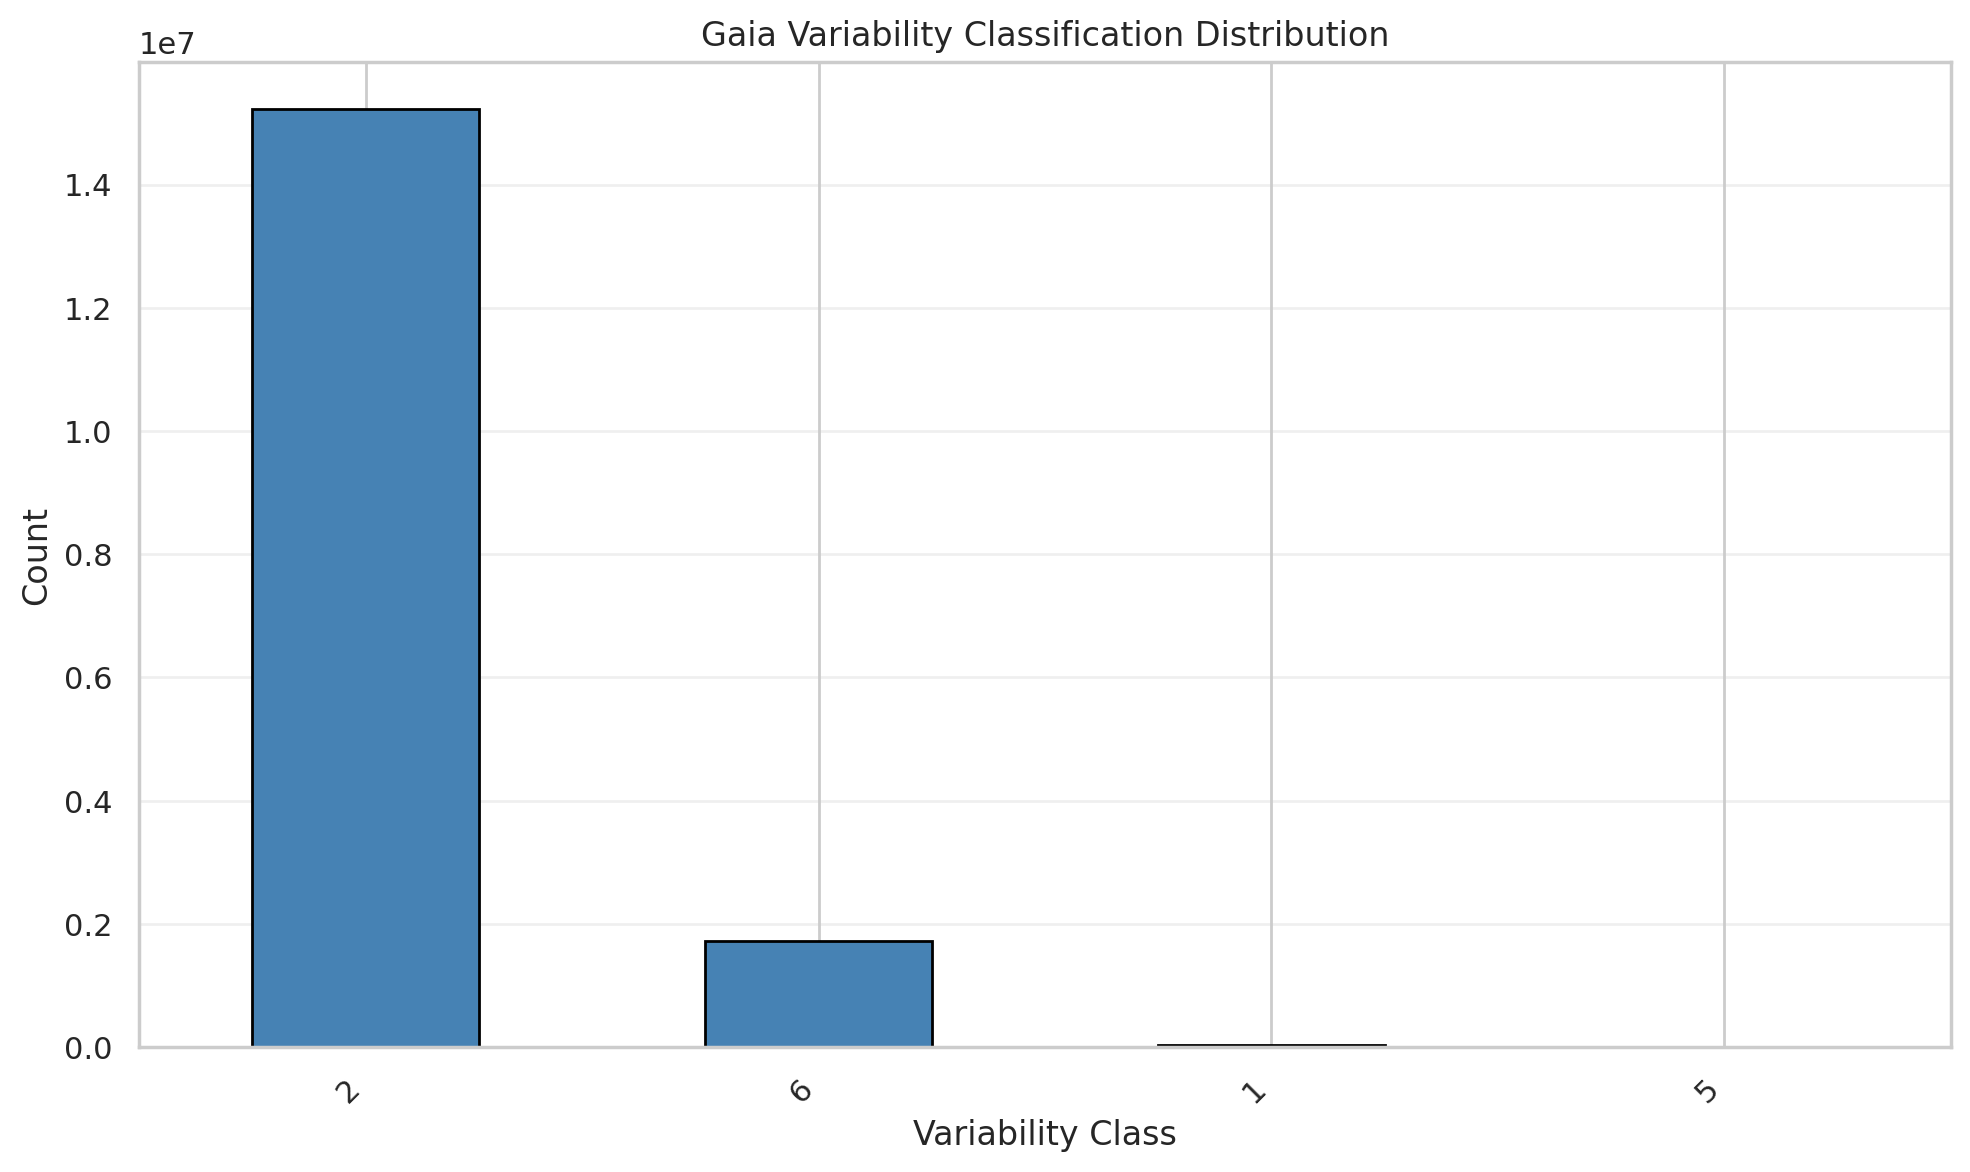

In [33]:
# Gaia variability classification analysis
if 'gaia_var' in df.columns:
    var_counts = df['gaia_var'].value_counts(dropna=False)
    print("Gaia Variability Classification:")
    print(var_counts)
    print(f"\nVariable sources: {df['gaia_var'].notna().sum():,} ({100*df['gaia_var'].notna().sum()/len(df):.2f}%)")
    
    if df['gaia_var'].notna().sum() > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        var_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
        ax.set_ylabel('Count')
        ax.set_xlabel('Variability Class')
        ax.set_title('Gaia Variability Classification Distribution')
        ax.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
else:
    print("No Gaia variability classification column found")

Effective Temperature Coverage: 16,999,525 (100.00%)

Teff Statistics (K):
count    1.699952e+07
mean     5.324329e+03
std      8.578375e+02
min      0.000000e+00
5%       4.046000e+03
25%      4.875000e+03
50%      5.327000e+03
75%      5.798000e+03
95%      6.759000e+03
max      9.755000e+03
Name: gaia_eff_temp, dtype: float64


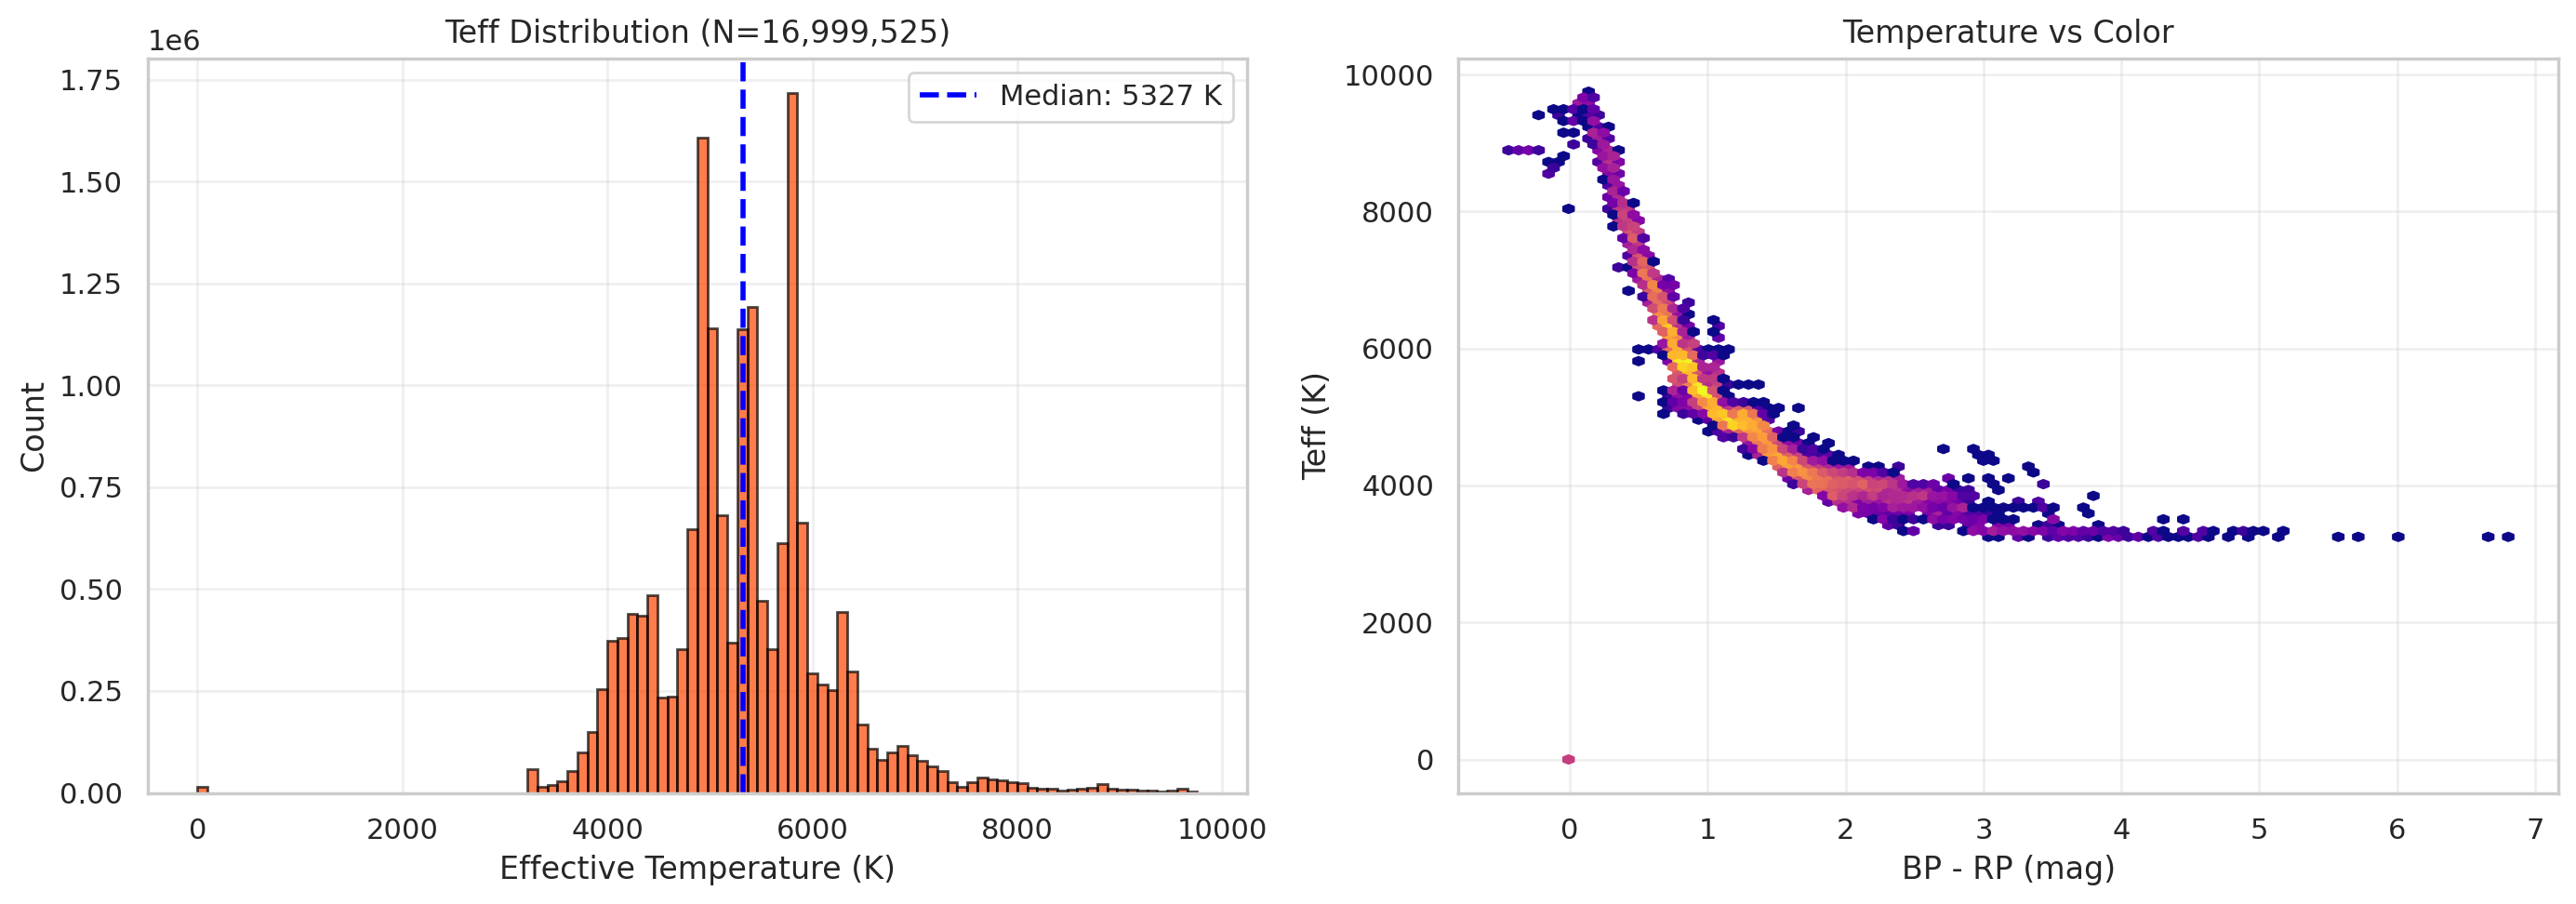

In [34]:
# Effective temperature analysis
if 'gaia_eff_temp' in df.columns:
    teff = df['gaia_eff_temp'].dropna()
    
    if len(teff) > 0:
        print(f"Effective Temperature Coverage: {len(teff):,} ({100*len(teff)/len(df):.2f}%)")
        print(f"\nTeff Statistics (K):")
        print(teff.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Distribution
        axes[0].hist(teff, bins=100, edgecolor='black', alpha=0.7, color='orangered')
        axes[0].set_xlabel('Effective Temperature (K)')
        axes[0].set_ylabel('Count')
        axes[0].set_title(f'Teff Distribution (N={len(teff):,})')
        axes[0].axvline(teff.median(), color='blue', linestyle='--', linewidth=2,
                       label=f'Median: {teff.median():.0f} K')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Teff vs BP-RP color
        if 'BP_RP' in df_temp.columns:
            df_teff_color = df_temp.loc[teff.index, ['BP_RP']].join(df['gaia_eff_temp']).dropna()
            sample = df_teff_color.sample(min(50000, len(df_teff_color)))
            axes[1].hexbin(sample['BP_RP'], sample['gaia_eff_temp'],
                          gridsize=100, cmap='plasma', mincnt=1, bins='log')
            axes[1].set_xlabel('BP - RP (mag)')
            axes[1].set_ylabel('Teff (K)')
            axes[1].set_title('Temperature vs Color')
            axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("No Gaia effective temperature data available")

## 7. Proper Motion and Galactic Kinematics

In [35]:
# Comprehensive proper motion analysis
if 'pm_ra' in df.columns and 'pm_dec' in df.columns:
    df_pm = df[['pm_ra', 'pm_dec']].dropna()
    df_pm['pm_total'] = np.sqrt(df_pm['pm_ra']**2 + df_pm['pm_dec']**2)
    
    print(f"Proper Motion Coverage: {len(df_pm):,} ({100*len(df_pm)/len(df):.2f}%)")
    print(f"\nProper Motion Statistics (mas/yr):")
    print(df_pm.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]))
    
    # Identify high proper motion sources
    high_pm_threshold = df_pm['pm_total'].quantile(0.95)
    high_pm = df_pm[df_pm['pm_total'] > high_pm_threshold]
    print(f"\nHigh PM sources (>95th percentile, >{high_pm_threshold:.1f} mas/yr): {len(high_pm):,}")
else:
    print("No proper motion data available")

Proper Motion Coverage: 16,999,525 (100.00%)

Proper Motion Statistics (mas/yr):
              pm_ra        pm_dec      pm_total
count  1.699952e+07  1.699952e+07  1.699952e+07
mean  -1.806874e+00 -3.523562e+00  1.084211e+01
std    1.332653e+01  1.292079e+01  1.557794e+01
min   -3.781300e+03 -5.096180e+03  0.000000e+00
1%    -3.545000e+01 -4.101000e+01  8.944272e-02
5%    -1.669000e+01 -1.944000e+01  1.338208e+00
10%   -1.116000e+01 -1.314000e+01  2.108673e+00
25%   -5.580000e+00 -6.700000e+00  4.008054e+00
50%   -1.600000e+00 -2.430000e+00  7.222243e+00
75%    1.710000e+00  1.180000e+00  1.275320e+01
90%    7.330000e+00  5.410000e+00  2.209098e+01
95%    1.306000e+01  9.140000e+00  3.103554e+01
99%    3.216000e+01  2.147000e+01  6.200629e+01
max    3.385820e+03  3.314400e+03  5.209140e+03

High PM sources (>95th percentile, >31.0 mas/yr): 849,977


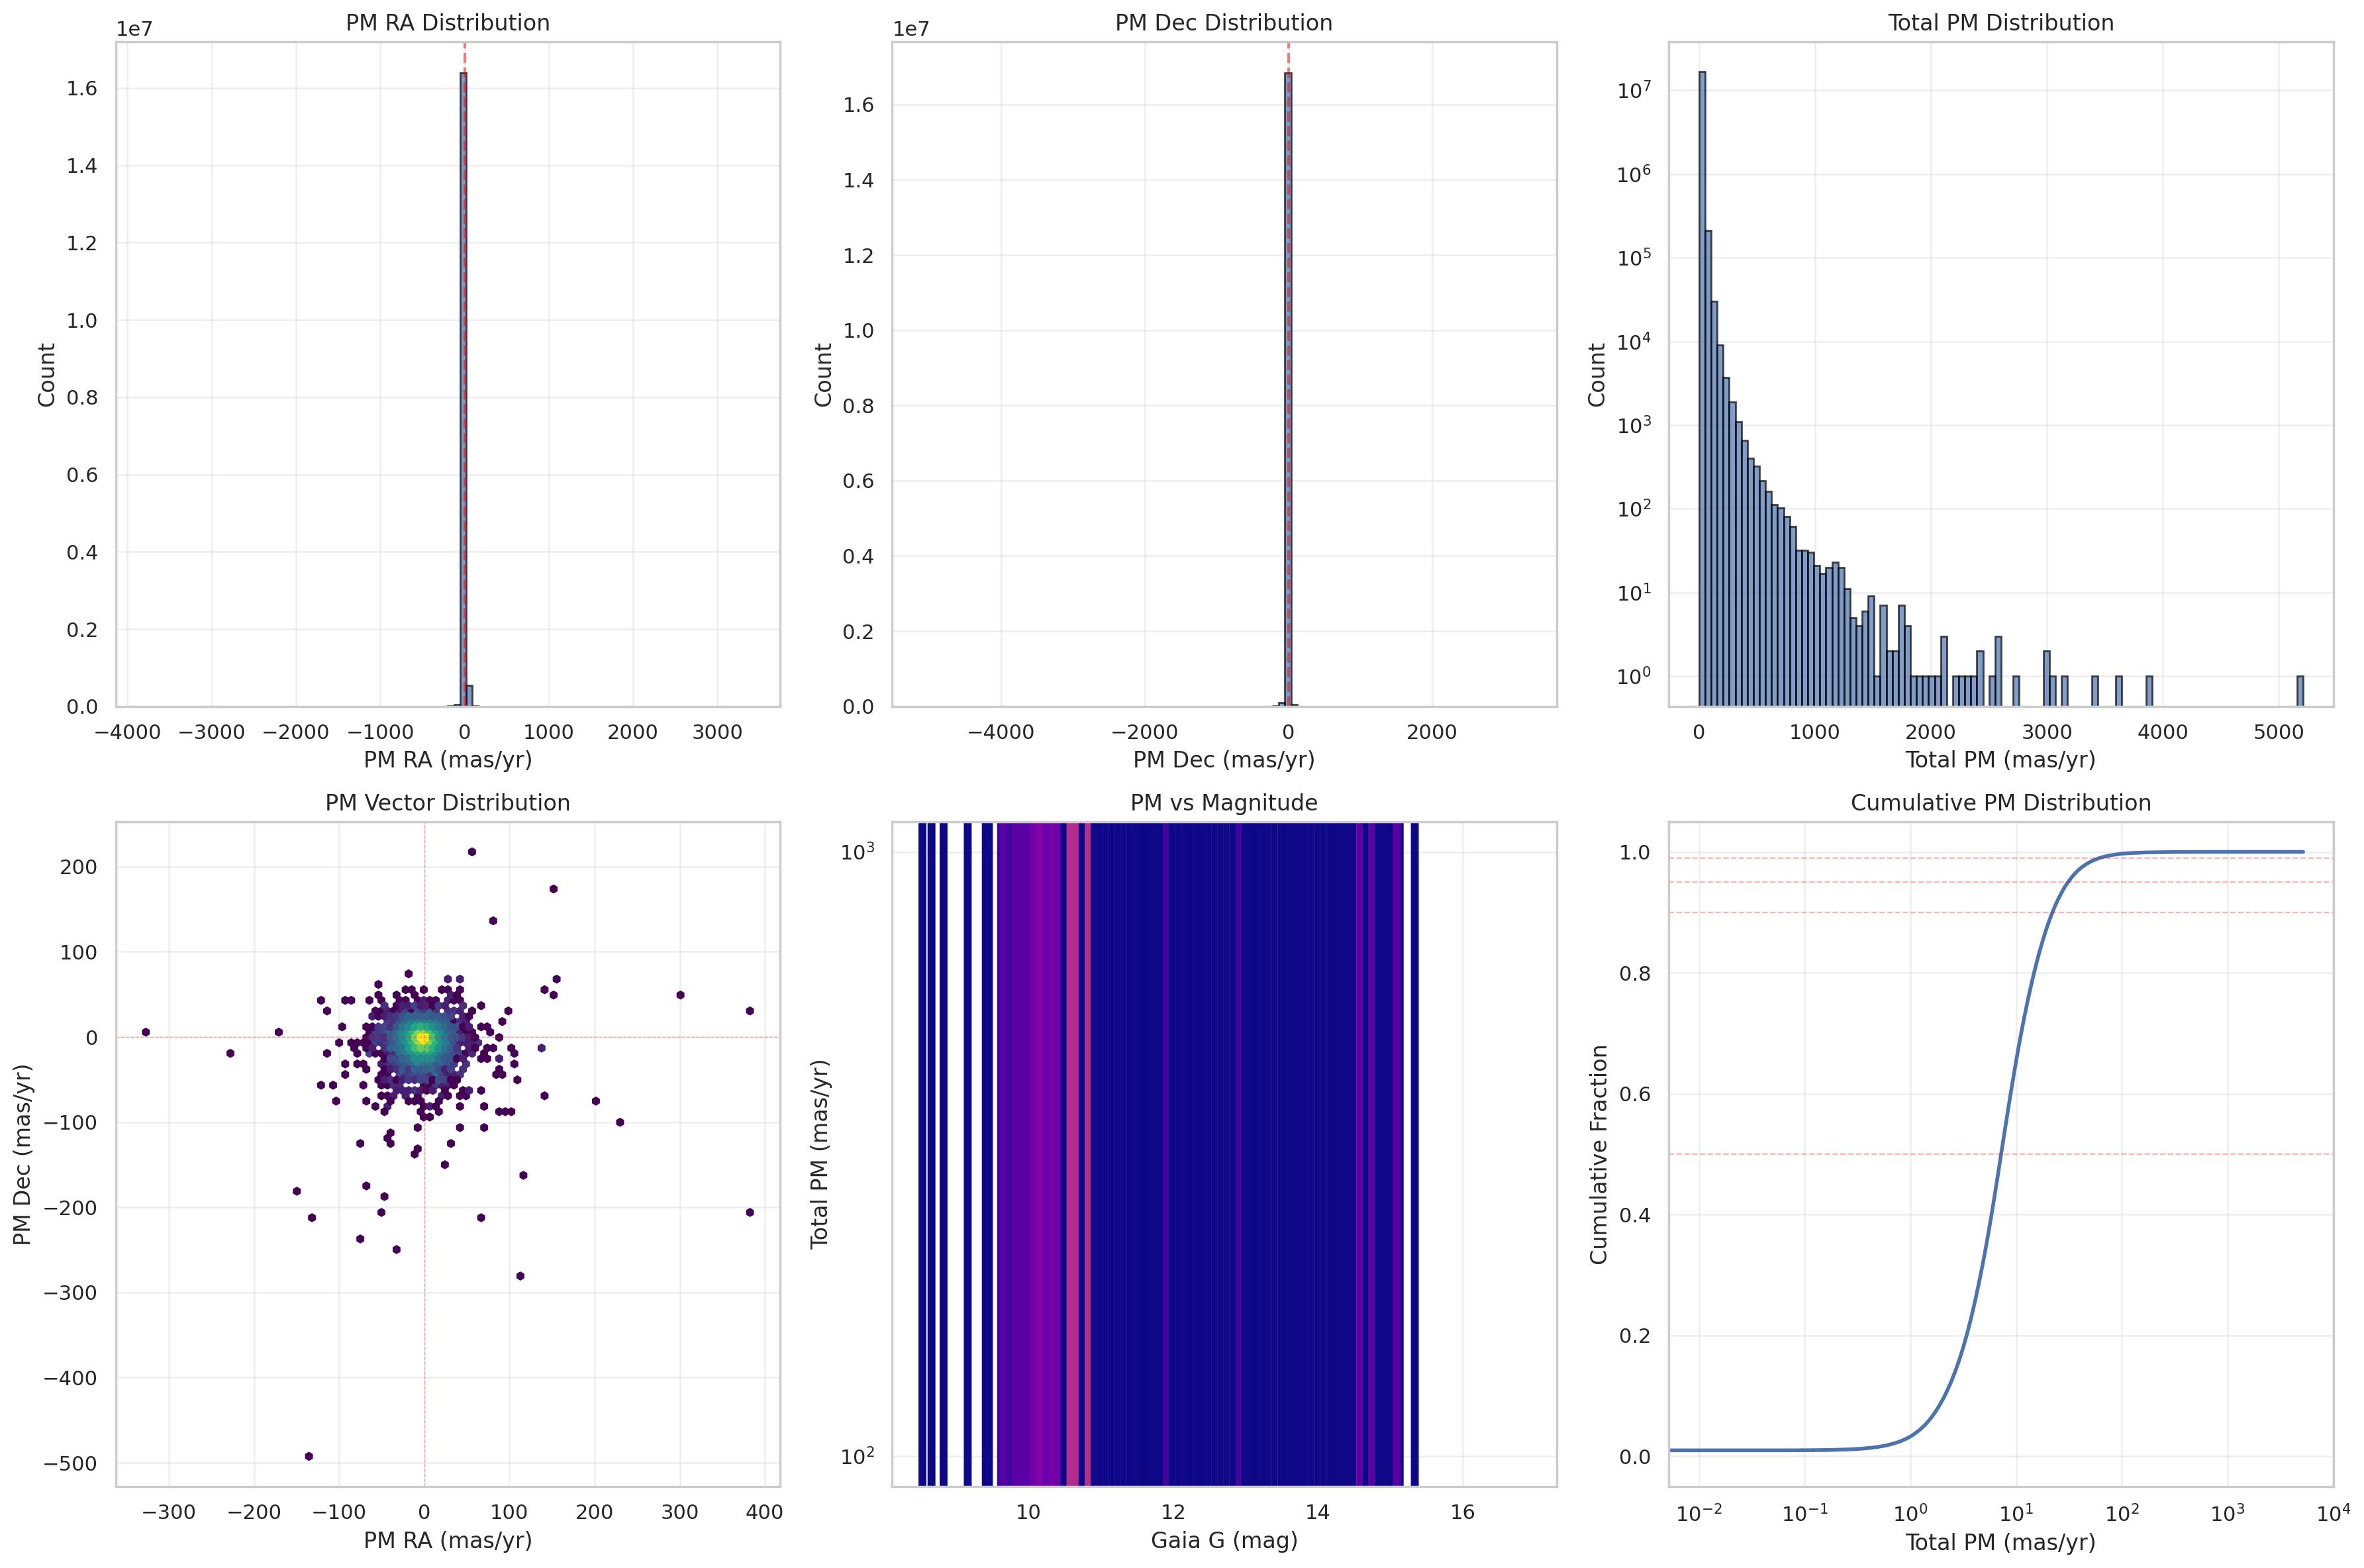

In [36]:
# Detailed proper motion visualizations
if 'pm_ra' in df.columns and 'pm_dec' in df.columns:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # PM RA
    axes[0, 0].hist(df_pm['pm_ra'], bins=100, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('PM RA (mas/yr)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('PM RA Distribution')
    axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.5)
    axes[0, 0].grid(True, alpha=0.3)
    
    # PM Dec
    axes[0, 1].hist(df_pm['pm_dec'], bins=100, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('PM Dec (mas/yr)')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('PM Dec Distribution')
    axes[0, 1].axvline(0, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Total PM
    axes[0, 2].hist(df_pm['pm_total'], bins=100, edgecolor='black', alpha=0.7)
    axes[0, 2].set_xlabel('Total PM (mas/yr)')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].set_title('Total PM Distribution')
    axes[0, 2].set_yscale('log')
    axes[0, 2].grid(True, alpha=0.3)
    
    # PM vector plot
    sample = df_pm.sample(min(20000, len(df_pm)))
    axes[1, 0].hexbin(sample['pm_ra'], sample['pm_dec'],
                     gridsize=100, cmap='viridis', mincnt=1, bins='log')
    axes[1, 0].set_xlabel('PM RA (mas/yr)')
    axes[1, 0].set_ylabel('PM Dec (mas/yr)')
    axes[1, 0].set_title('PM Vector Distribution')
    axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.3, linewidth=0.5)
    axes[1, 0].axvline(0, color='red', linestyle='--', alpha=0.3, linewidth=0.5)
    axes[1, 0].grid(True, alpha=0.3)
    
    # PM vs magnitude (if available)
    if 'gaia_mag' in df.columns:
        df_pm_mag = df.loc[df_pm.index, ['gaia_mag']].join(df_pm['pm_total']).dropna()
        sample = df_pm_mag.sample(min(50000, len(df_pm_mag)))
        axes[1, 1].hexbin(sample['gaia_mag'], sample['pm_total'],
                         gridsize=100, cmap='plasma', mincnt=1, bins='log')
        axes[1, 1].set_xlabel('Gaia G (mag)')
        axes[1, 1].set_ylabel('Total PM (mas/yr)')
        axes[1, 1].set_title('PM vs Magnitude')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)
    
    # Cumulative distribution
    sorted_pm = np.sort(df_pm['pm_total'])
    cumulative = np.arange(1, len(sorted_pm) + 1) / len(sorted_pm)
    axes[1, 2].plot(sorted_pm, cumulative, linewidth=2)
    axes[1, 2].set_xlabel('Total PM (mas/yr)')
    axes[1, 2].set_ylabel('Cumulative Fraction')
    axes[1, 2].set_title('Cumulative PM Distribution')
    axes[1, 2].set_xscale('log')
    axes[1, 2].grid(True, alpha=0.3)
    for level in [0.5, 0.9, 0.95, 0.99]:
        axes[1, 2].axhline(level, color='red', linestyle='--', alpha=0.3, linewidth=0.8)
    
    plt.tight_layout()
    plt.show()


## 8. Parallax and Distance Analysis

Parallax Coverage: 16,999,525 (100.00%)
Positive parallaxes: 16,700,834 (98.24%)
High-quality parallax (SNR>5): 15,978,889 (95.68%)

Distance Statistics (pc):
count    1.597889e+07
mean     1.539988e+03
std      1.354483e+03
min      1.301236e+00
5%       3.267974e+02
25%      6.849315e+02
50%      1.111111e+03
75%      1.923077e+03
95%      4.166667e+03
max      1.666667e+04
Name: plx, dtype: float64

Nearby sources (<100 pc): 43,446


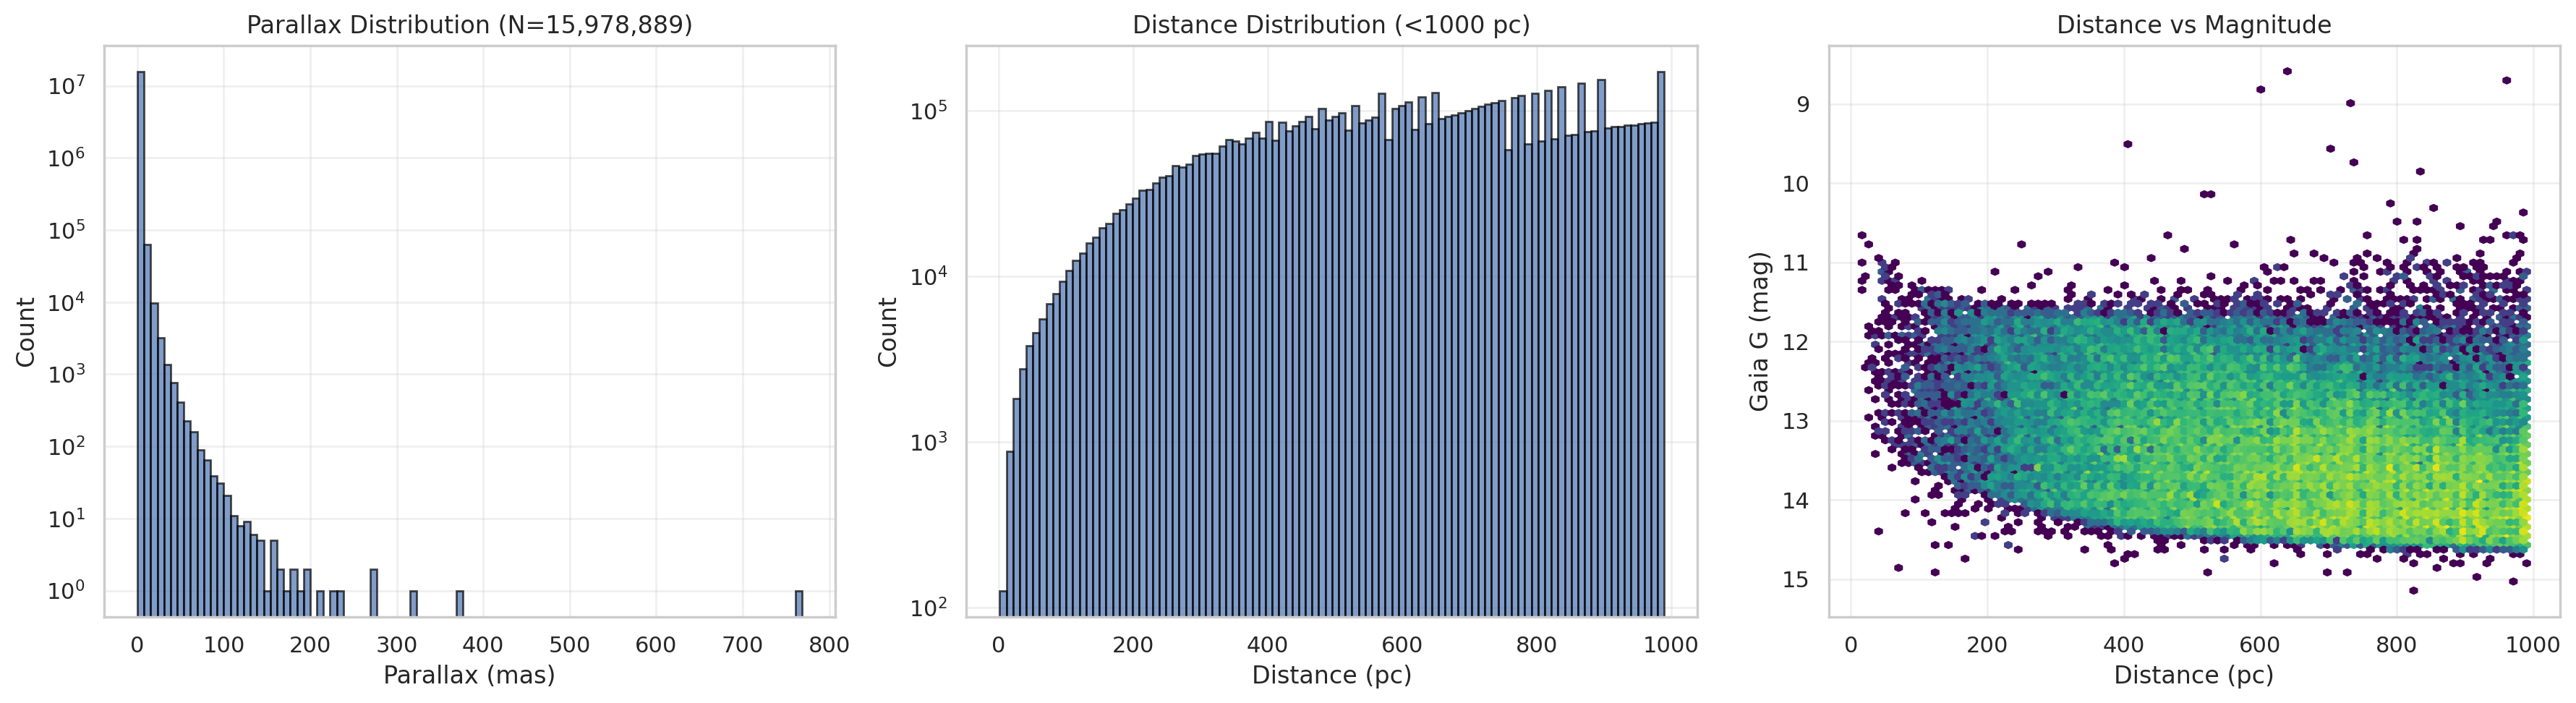

In [37]:
# Parallax analysis
if 'plx' in df.columns:
    plx_data = df['plx'].dropna()
    
    print(f"Parallax Coverage: {len(plx_data):,} ({100*len(plx_data)/len(df):.2f}%)")
    
    if len(plx_data) > 0:
        # Filter for positive parallaxes
        plx_pos = plx_data[plx_data > 0]
        print(f"Positive parallaxes: {len(plx_pos):,} ({100*len(plx_pos)/len(plx_data):.2f}%)")
        
        if 'plx_d' in df.columns:
            plx_error = df.loc[plx_pos.index, 'plx_d']
            plx_snr = plx_pos / plx_error
            good_plx = plx_pos[plx_snr > 5]
            print(f"High-quality parallax (SNR>5): {len(good_plx):,} ({100*len(good_plx)/len(plx_pos):.2f}%)")
        else:
            good_plx = plx_pos
        
        # Compute distances
        distances = 1000 / good_plx  # Distance in parsecs
        
        print(f"\nDistance Statistics (pc):")
        print(distances.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
        
        # Nearby sources
        nearby = distances[distances < 100]
        print(f"\nNearby sources (<100 pc): {len(nearby):,}")
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Parallax distribution
        axes[0].hist(good_plx, bins=100, edgecolor='black', alpha=0.7)
        axes[0].set_xlabel('Parallax (mas)')
        axes[0].set_ylabel('Count')
        axes[0].set_title(f'Parallax Distribution (N={len(good_plx):,})')
        axes[0].set_yscale('log')
        axes[0].grid(True, alpha=0.3)
        
        # Distance distribution
        axes[1].hist(distances[distances < 1000], bins=100, edgecolor='black', alpha=0.7)
        axes[1].set_xlabel('Distance (pc)')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Distance Distribution (<1000 pc)')
        axes[1].set_yscale('log')
        axes[1].grid(True, alpha=0.3)
        
        # Distance vs magnitude
        if 'gaia_mag' in df.columns:
            df_dist_mag = df.loc[distances.index, ['gaia_mag']].join(pd.DataFrame({'distance': distances}))
            df_dist_mag = df_dist_mag[df_dist_mag['distance'] < 1000].dropna()
            sample = df_dist_mag.sample(min(50000, len(df_dist_mag)))
            axes[2].hexbin(sample['distance'], sample['gaia_mag'],
                          gridsize=100, cmap='viridis', mincnt=1, bins='log')
            axes[2].set_xlabel('Distance (pc)')
            axes[2].set_ylabel('Gaia G (mag)')
            axes[2].set_title('Distance vs Magnitude')
            axes[2].invert_yaxis()
            axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("No parallax data available")

## 9. Photometric Quality Metrics

In [38]:
# Pan-STARRS photometric quality analysis
ps_quality_cols = {
    'g': ['pstarrs_g_mag', 'pstarrs_g_mag_d', 'pstarrs_g_mag_chi', 'pstarrs_g_mag_contrib'],
    'r': ['pstarrs_r_mag', 'pstarrs_r_mag_d', 'pstarrs_r_mag_chi', 'pstarrs_r_mag_contrib'],
    'i': ['pstarrs_i_mag', 'pstarrs_i_mag_d', 'pstarrs_i_mag_chi', 'pstarrs_i_mag_contrib'],
    'z': ['pstarrs_z_mag', 'pstarrs_z_mag_d', 'pstarrs_z_mag_chi', 'pstarrs_z_mag_contrib'],
}

for band, cols in ps_quality_cols.items():
    mag_col, err_col, chi_col, contrib_col = cols
    
    if all(c in df.columns for c in [mag_col, err_col, chi_col]):
        df_qual = df[[mag_col, err_col, chi_col]].dropna()
        
        if len(df_qual) > 0:
            print(f"\n{band}-band Photometric Quality (N={len(df_qual):,}):")
            print(f"  Error (mag): median={df_qual[err_col].median():.4f}, mean={df_qual[err_col].mean():.4f}")
            print(f"  Chi-squared: median={df_qual[chi_col].median():.2f}, mean={df_qual[chi_col].mean():.2f}")
            
            # High chi-squared sources (potentially variable)
            high_chi = df_qual[df_qual[chi_col] > 2]
            print(f"  High χ² sources (>2): {len(high_chi):,} ({100*len(high_chi)/len(df_qual):.2f}%)")


g-band Photometric Quality (N=16,999,525):
  Error (mag): median=0.0110, mean=0.0128
  Chi-squared: median=0.56, mean=1.41
  High χ² sources (>2): 3,186,777 (18.75%)

r-band Photometric Quality (N=16,999,525):
  Error (mag): median=0.0120, mean=0.0136
  Chi-squared: median=0.61, mean=1.50
  High χ² sources (>2): 3,428,182 (20.17%)

i-band Photometric Quality (N=16,999,525):
  Error (mag): median=0.0120, mean=0.0141
  Chi-squared: median=0.64, mean=1.58
  High χ² sources (>2): 3,680,968 (21.65%)

z-band Photometric Quality (N=16,999,525):
  Error (mag): median=0.0150, mean=0.0357
  Chi-squared: median=0.02, mean=0.27
  High χ² sources (>2): 484,525 (2.85%)


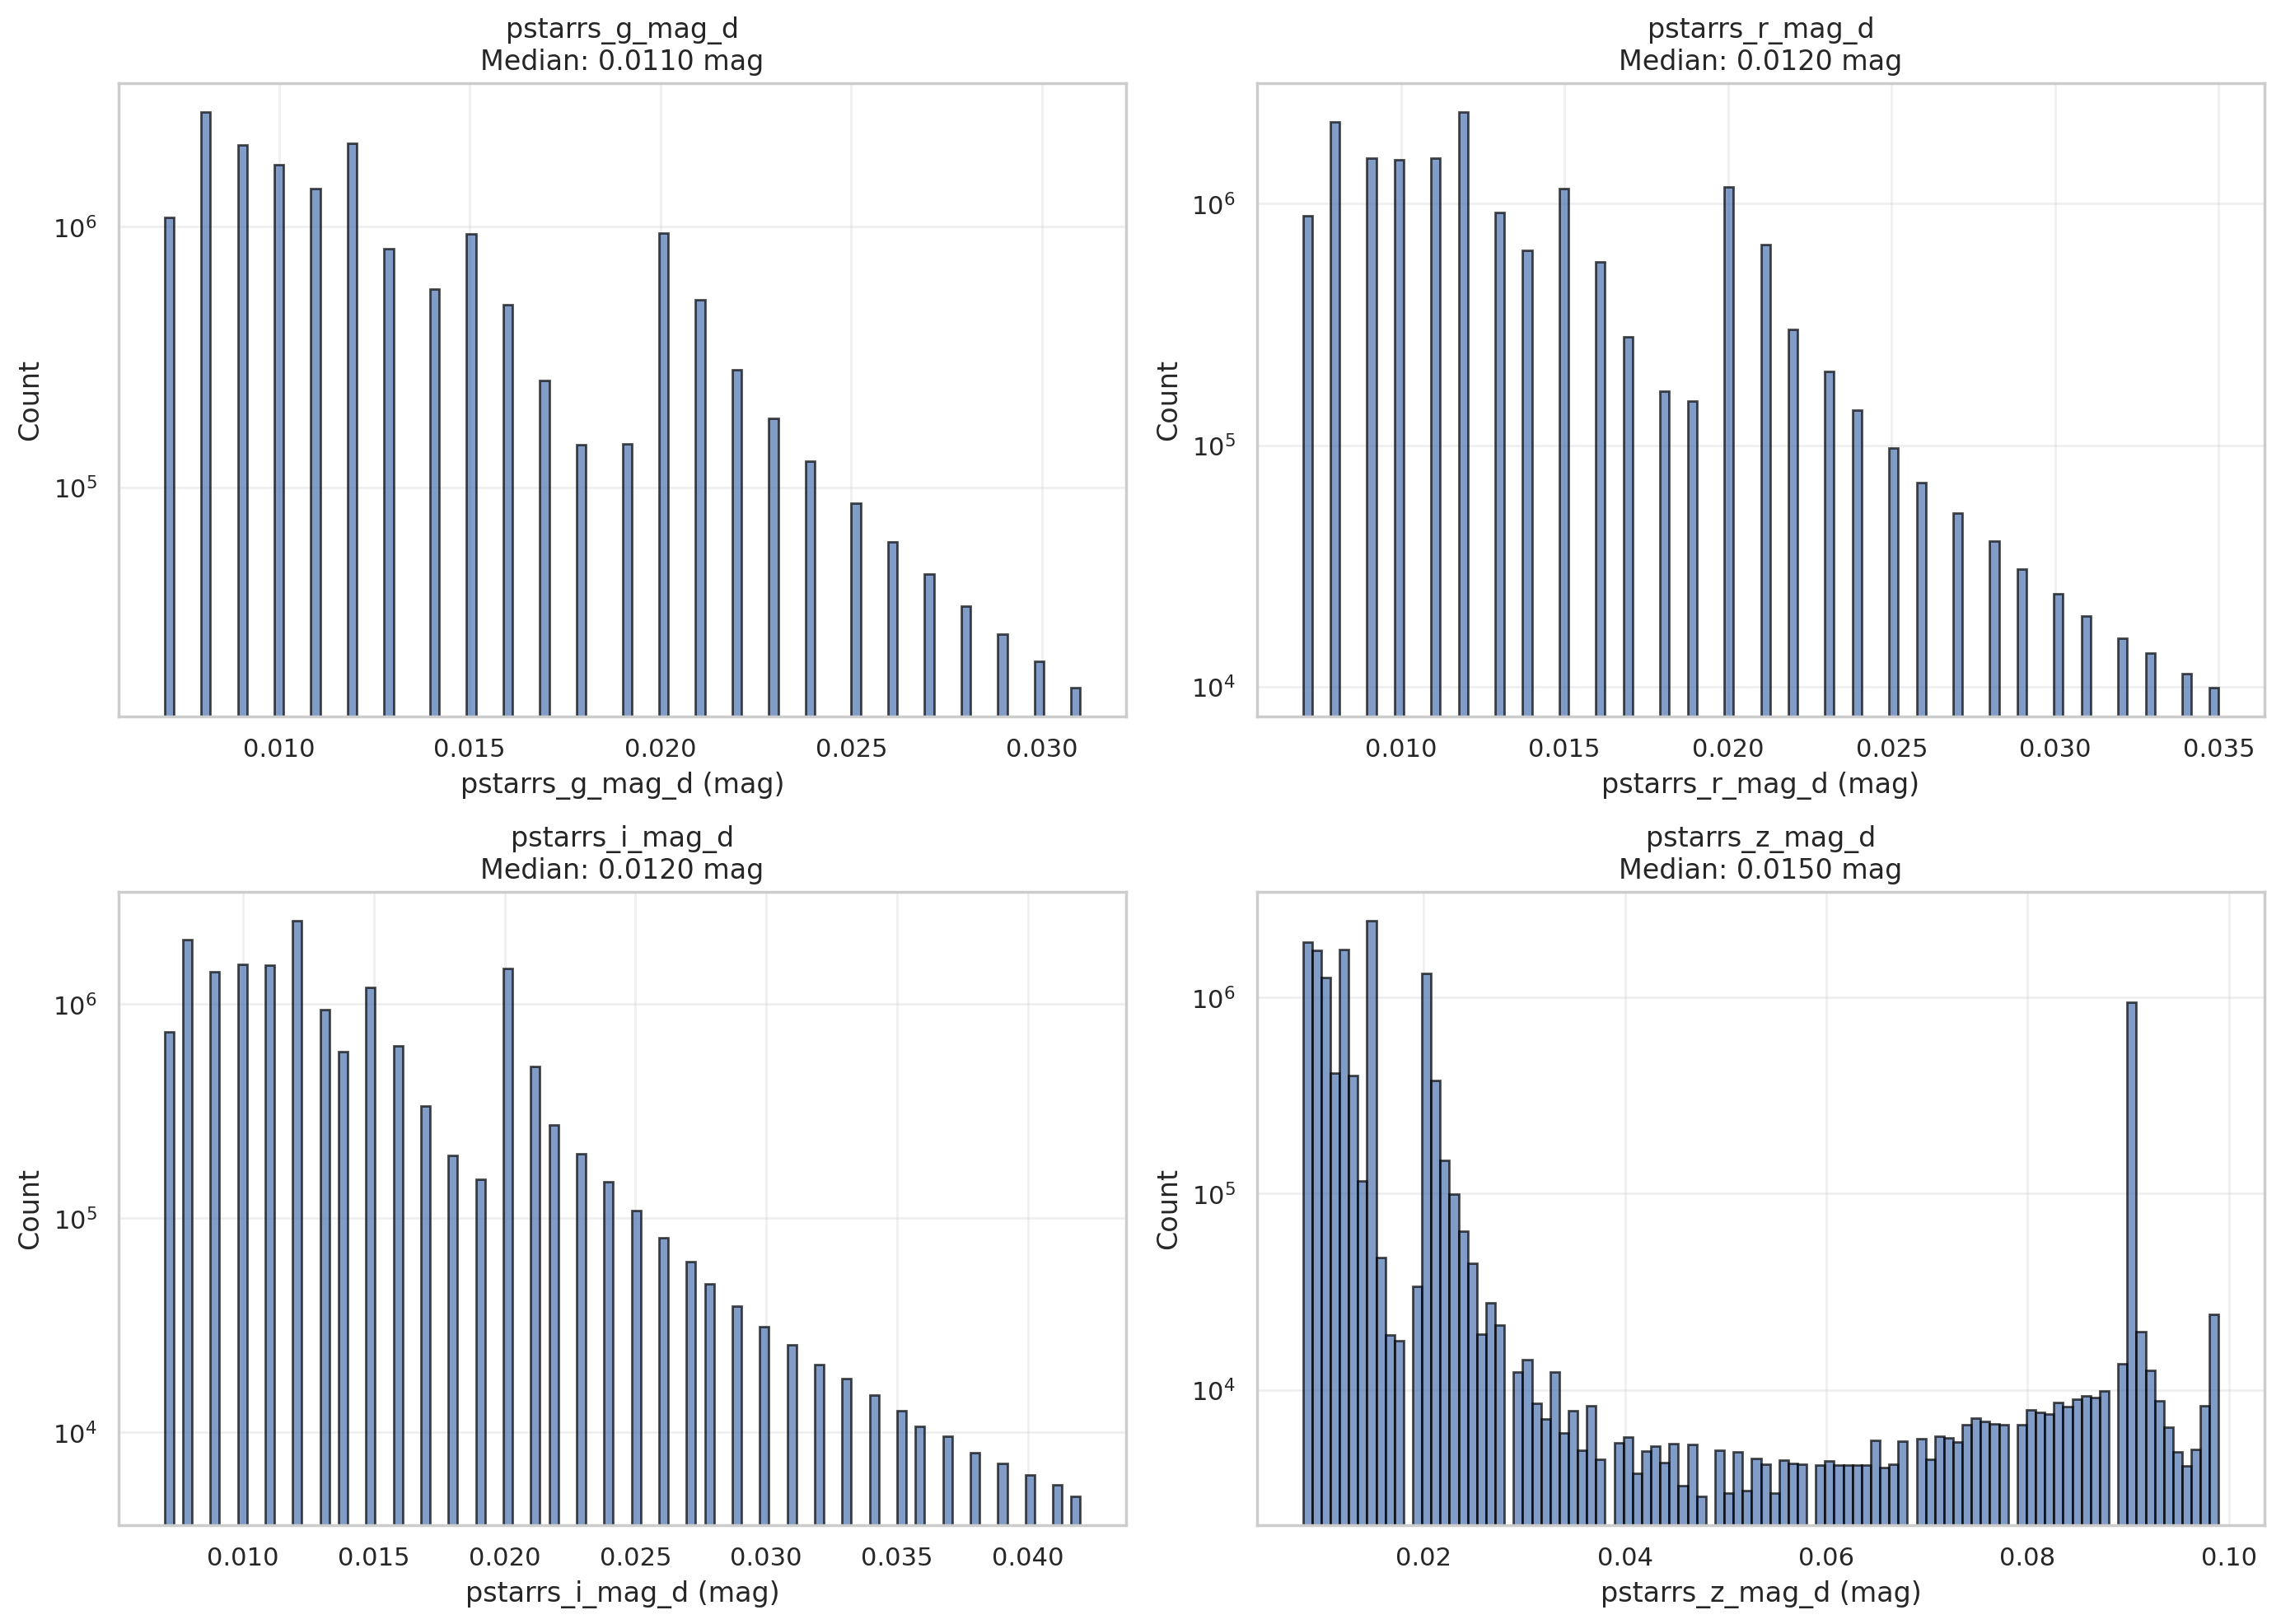

In [39]:
# Photometric error distributions
error_cols = [c for c in df.columns if '_mag_d' in c and 'pstarrs' in c]

if error_cols:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(error_cols[:4]):
        data = df[col].dropna()
        if len(data) > 0:
            # Remove extreme outliers
            data_clip = data[data < data.quantile(0.99)]
            
            axes[i].hist(data_clip, bins=100, edgecolor='black', alpha=0.7)
            axes[i].set_xlabel(f'{col} (mag)')
            axes[i].set_ylabel('Count')
            axes[i].set_title(f'{col}\nMedian: {data.median():.4f} mag')
            axes[i].set_yscale('log')
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


PS1 g-band SNR Statistics:
count    1.699952e+07
mean     9.840421e+01
std      3.208371e+01
min      1.271663e+00
5%       4.936364e+01
25%      7.240000e+01
50%      9.872727e+01
75%      1.206667e+02
95%      1.551429e+02
max      1.551429e+02
Name: snr, dtype: float64


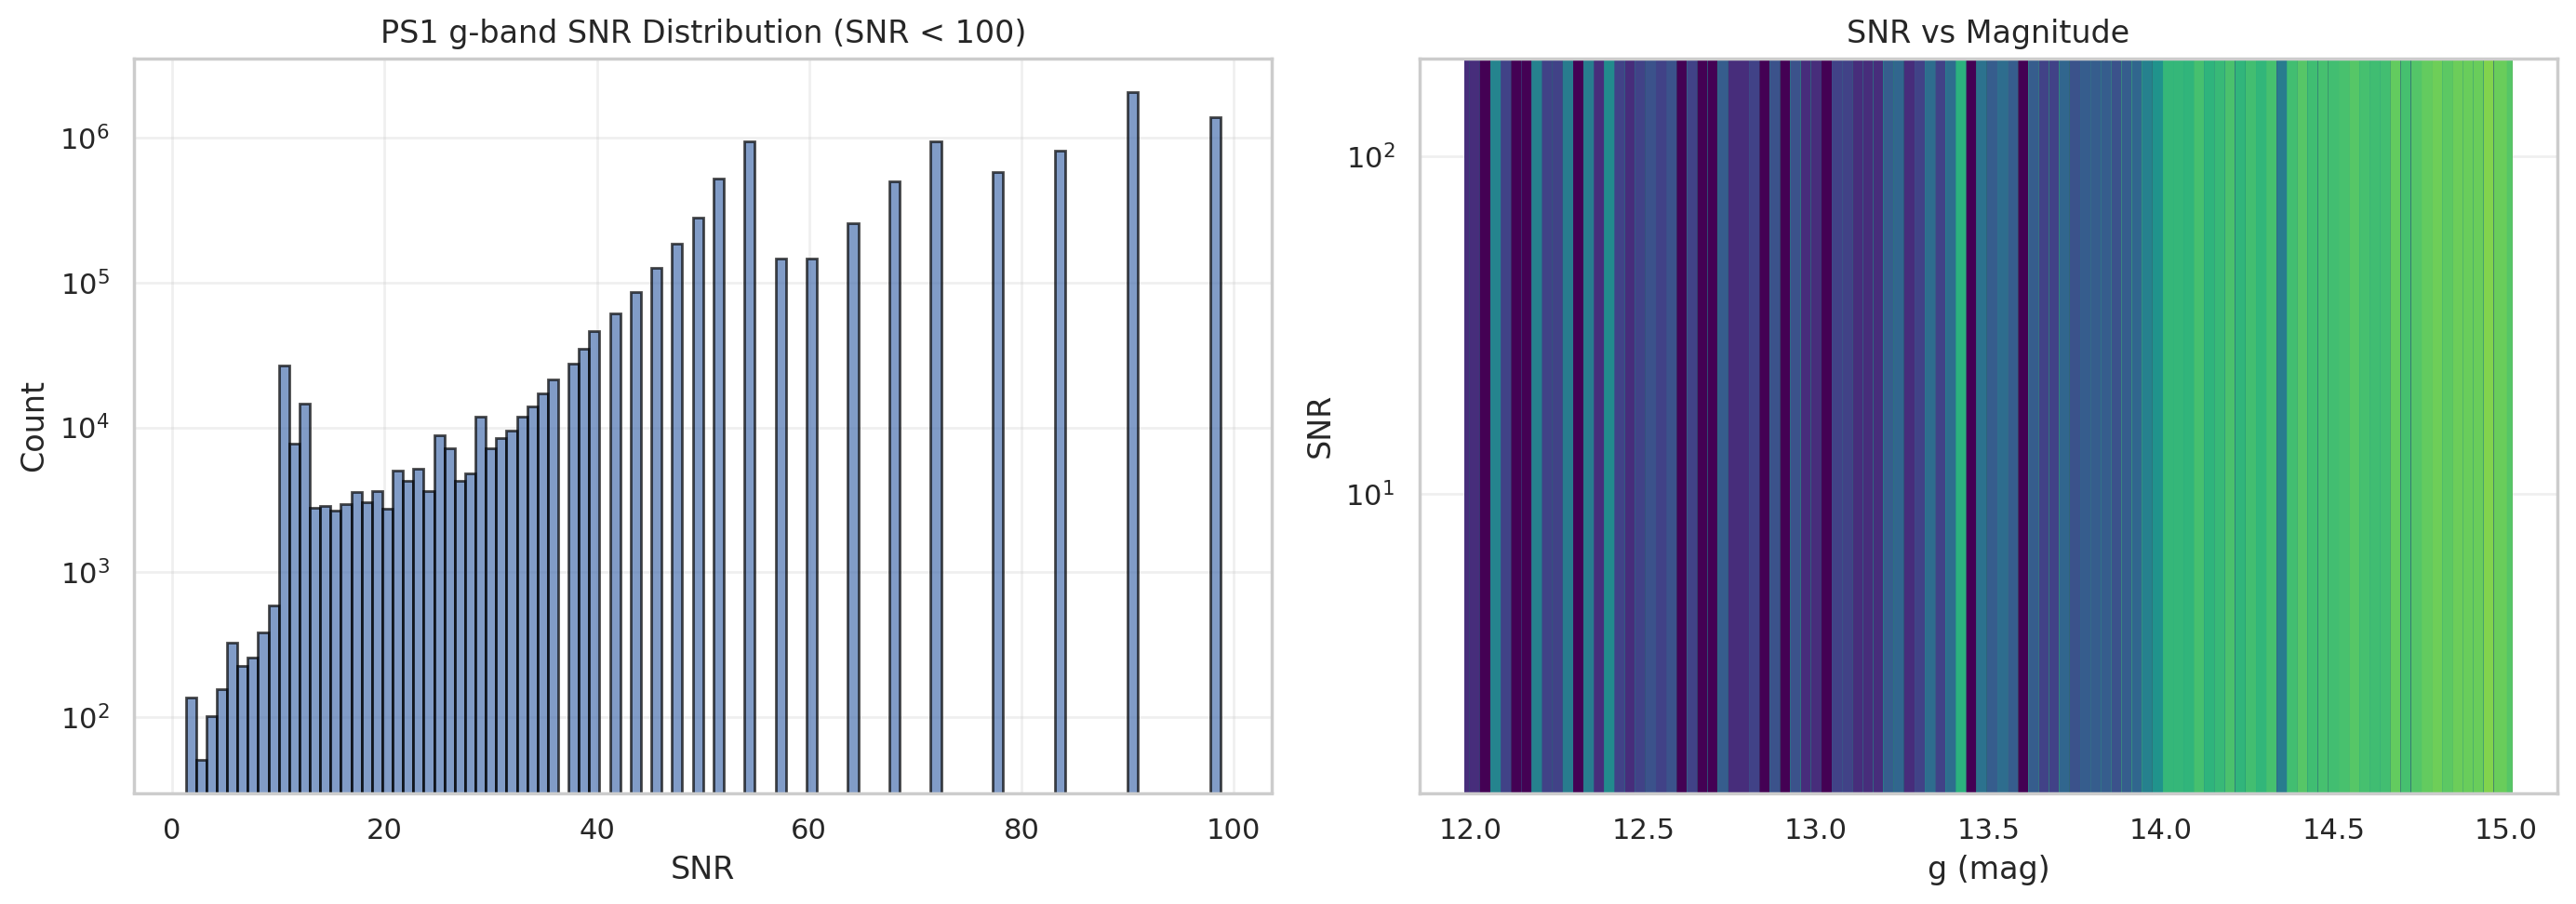

In [40]:
# Signal-to-noise analysis
if 'pstarrs_g_mag' in df.columns and 'pstarrs_g_mag_d' in df.columns:
    df_snr = df[['pstarrs_g_mag', 'pstarrs_g_mag_d']].dropna()
    # SNR approximation: 1.086/error (in mag units)
    df_snr['snr'] = 1.086 / df_snr['pstarrs_g_mag_d']
    
    print(f"\nPS1 g-band SNR Statistics:")
    print(df_snr['snr'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # SNR distribution
    axes[0].hist(df_snr['snr'][df_snr['snr'] < 100], bins=100, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('SNR')
    axes[0].set_ylabel('Count')
    axes[0].set_title('PS1 g-band SNR Distribution (SNR < 100)')
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)
    
    # SNR vs magnitude
    sample = df_snr.sample(min(50000, len(df_snr)))
    axes[1].hexbin(sample['pstarrs_g_mag'], sample['snr'],
                  gridsize=100, cmap='viridis', mincnt=1, bins='log')
    axes[1].set_xlabel('g (mag)')
    axes[1].set_ylabel('SNR')
    axes[1].set_title('SNR vs Magnitude')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 10. Magnitude Bin Analysis (12-15 mag)

Analyzing magnitude bins using: gaia_mag

Magnitude Bin Distribution:
  12.0 - 12.5 mag: 1,579,129 (9.29%)
  12.5 - 13.0 mag: 2,300,397 (13.53%)
  13.0 - 13.5 mag: 3,172,311 (18.66%)
  13.5 - 14.0 mag: 3,924,934 (23.09%)
  14.0 - 14.5 mag: 4,037,134 (23.75%)
  14.5 - 15.0 mag: 753,342 (4.43%)

  Outside bins (< 12 or >= 15): 1,232,278 (7.25%)


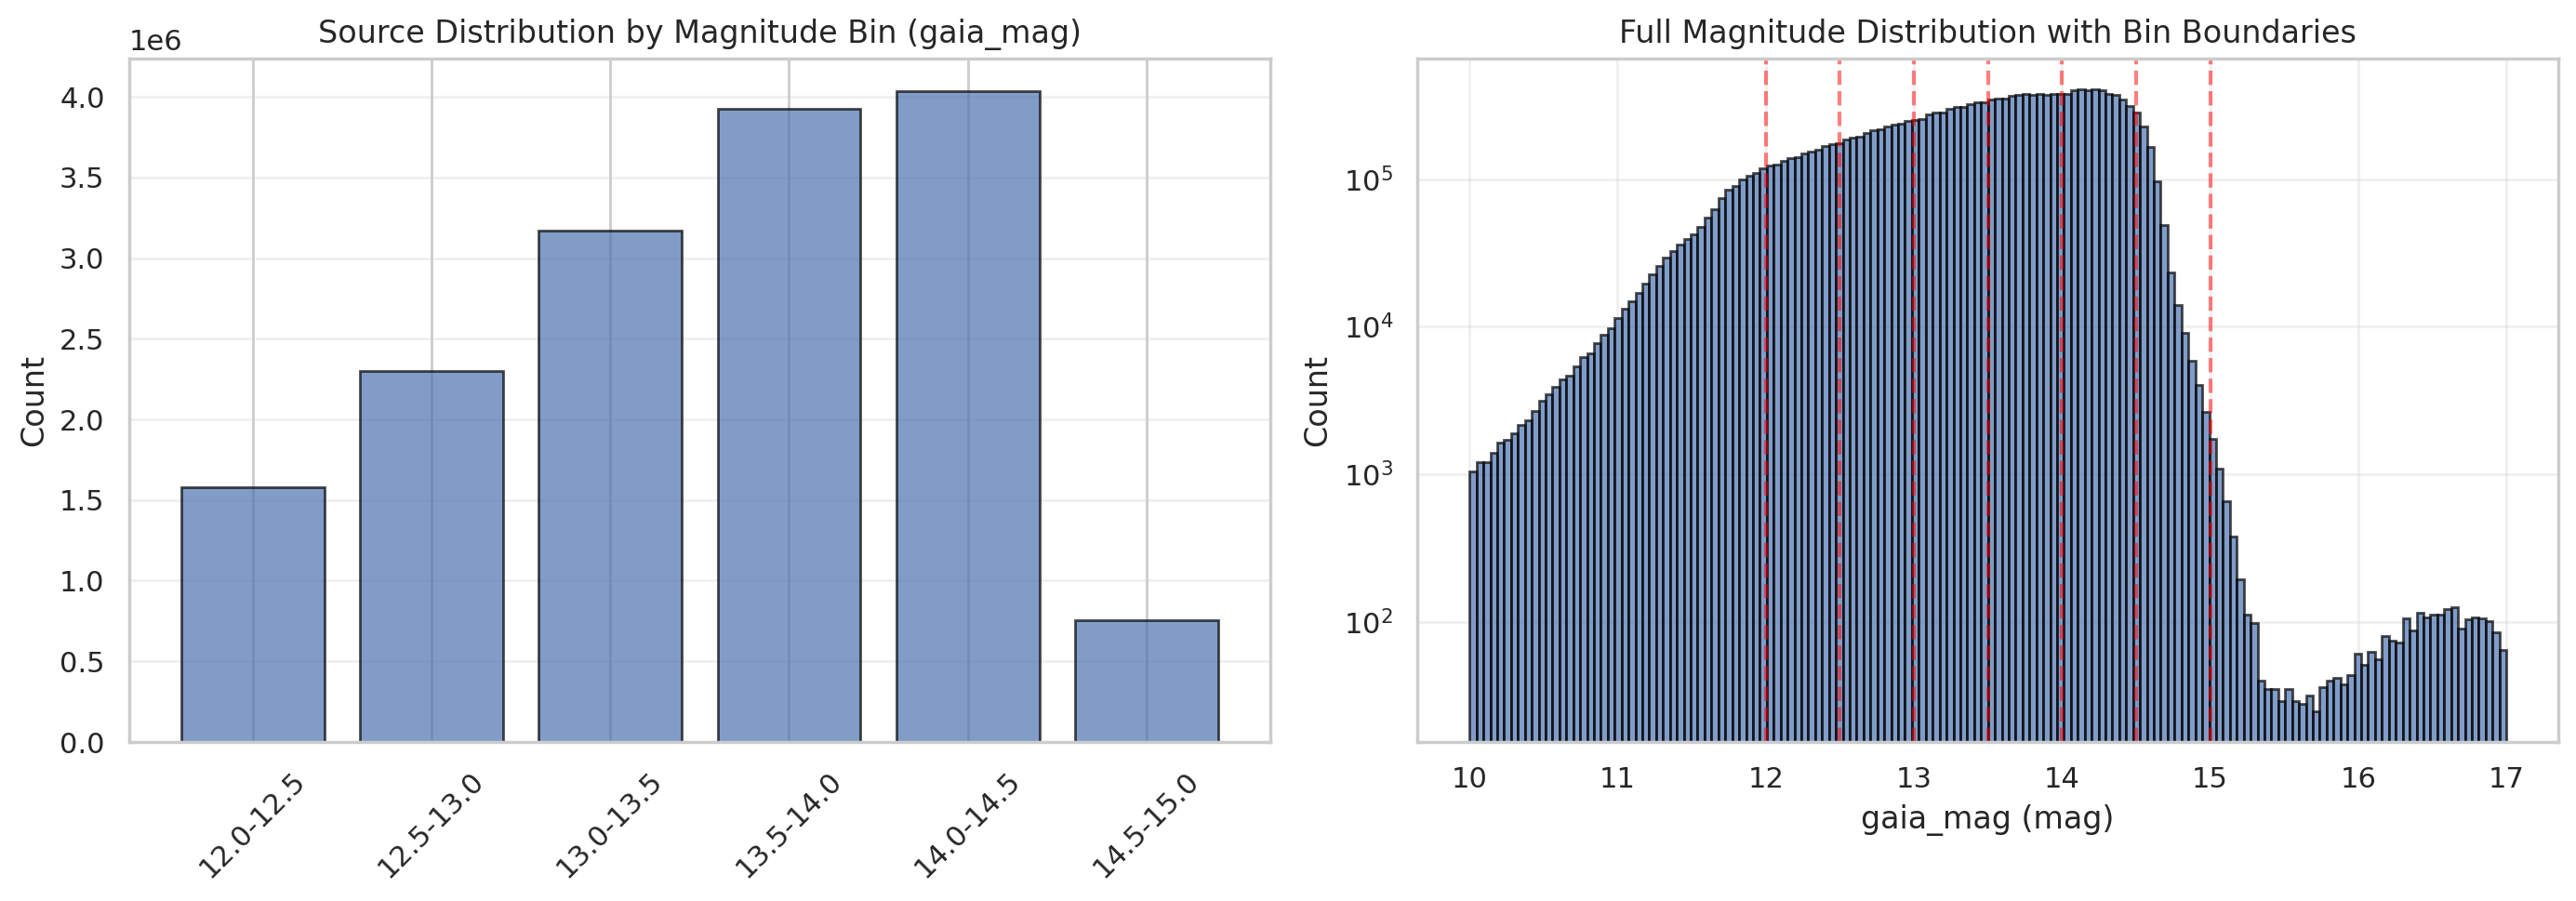

In [41]:
# Analyze distribution across magnitude bins used in manifest.py
mag_bins = [(12.0, 12.5), (12.5, 13.0), (13.0, 13.5), (13.5, 14.0), (14.0, 14.5), (14.5, 15.0)]

if 'gaia_mag' in df.columns:
    mag_col = 'gaia_mag'
elif 'pstarrs_g_mag' in df.columns:
    mag_col = 'pstarrs_g_mag'
else:
    mag_col = None

if mag_col:
    print(f"Analyzing magnitude bins using: {mag_col}")
    print("\nMagnitude Bin Distribution:")
    print("="*60)
    
    bin_stats = []
    for min_mag, max_mag in mag_bins:
        mask = (df[mag_col] >= min_mag) & (df[mag_col] < max_mag)
        count = mask.sum()
        pct = 100 * count / len(df)
        bin_stats.append({
            'bin': f"{min_mag:.1f}-{max_mag:.1f}",
            'count': count,
            'percent': pct
        })
        print(f"  {min_mag:.1f} - {max_mag:.1f} mag: {count:,} ({pct:.2f}%)")
    
    # Sources outside bins
    outside_bins = df[(df[mag_col] < 12.0) | (df[mag_col] >= 15.0)][mag_col].dropna()
    print(f"\n  Outside bins (< 12 or >= 15): {len(outside_bins):,} ({100*len(outside_bins)/len(df):.2f}%)")
    
    # Visualize
    bin_df = pd.DataFrame(bin_stats)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].bar(range(len(bin_df)), bin_df['count'], edgecolor='black', alpha=0.7)
    axes[0].set_xticks(range(len(bin_df)))
    axes[0].set_xticklabels(bin_df['bin'], rotation=45)
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Source Distribution by Magnitude Bin ({mag_col})')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Show full magnitude distribution with bin boundaries
    axes[1].hist(df[mag_col].dropna(), bins=150, edgecolor='black', alpha=0.7, range=(10, 17))
    for min_mag, max_mag in mag_bins:
        axes[1].axvline(min_mag, color='red', linestyle='--', alpha=0.5)
    axes[1].axvline(15.0, color='red', linestyle='--', alpha=0.5)
    axes[1].set_xlabel(f'{mag_col} (mag)')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'Full Magnitude Distribution with Bin Boundaries')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No suitable magnitude column for bin analysis")

## 11. Extinction Analysis

Sources with both SFD and Gaia extinction: 16,999,525

SFD Extinction (G-band):
count    1.699952e+07
mean     1.653322e+00
std      5.429586e+00
min      0.000000e+00
5%       6.700000e-02
25%      2.200000e-01
50%      5.150000e-01
75%      1.384000e+00
95%      5.571000e+00
max      4.719140e+02
Name: sfd_g_extinc, dtype: float64

Gaia Extinction (G-band):
count    1.699952e+07
mean     3.574843e-01
std      4.678713e-01
min      0.000000e+00
5%       0.000000e+00
25%      0.000000e+00
50%      1.510000e-01
75%      5.870000e-01
95%      1.354000e+00
max      3.317000e+00
Name: gaia_g_extinc, dtype: float64


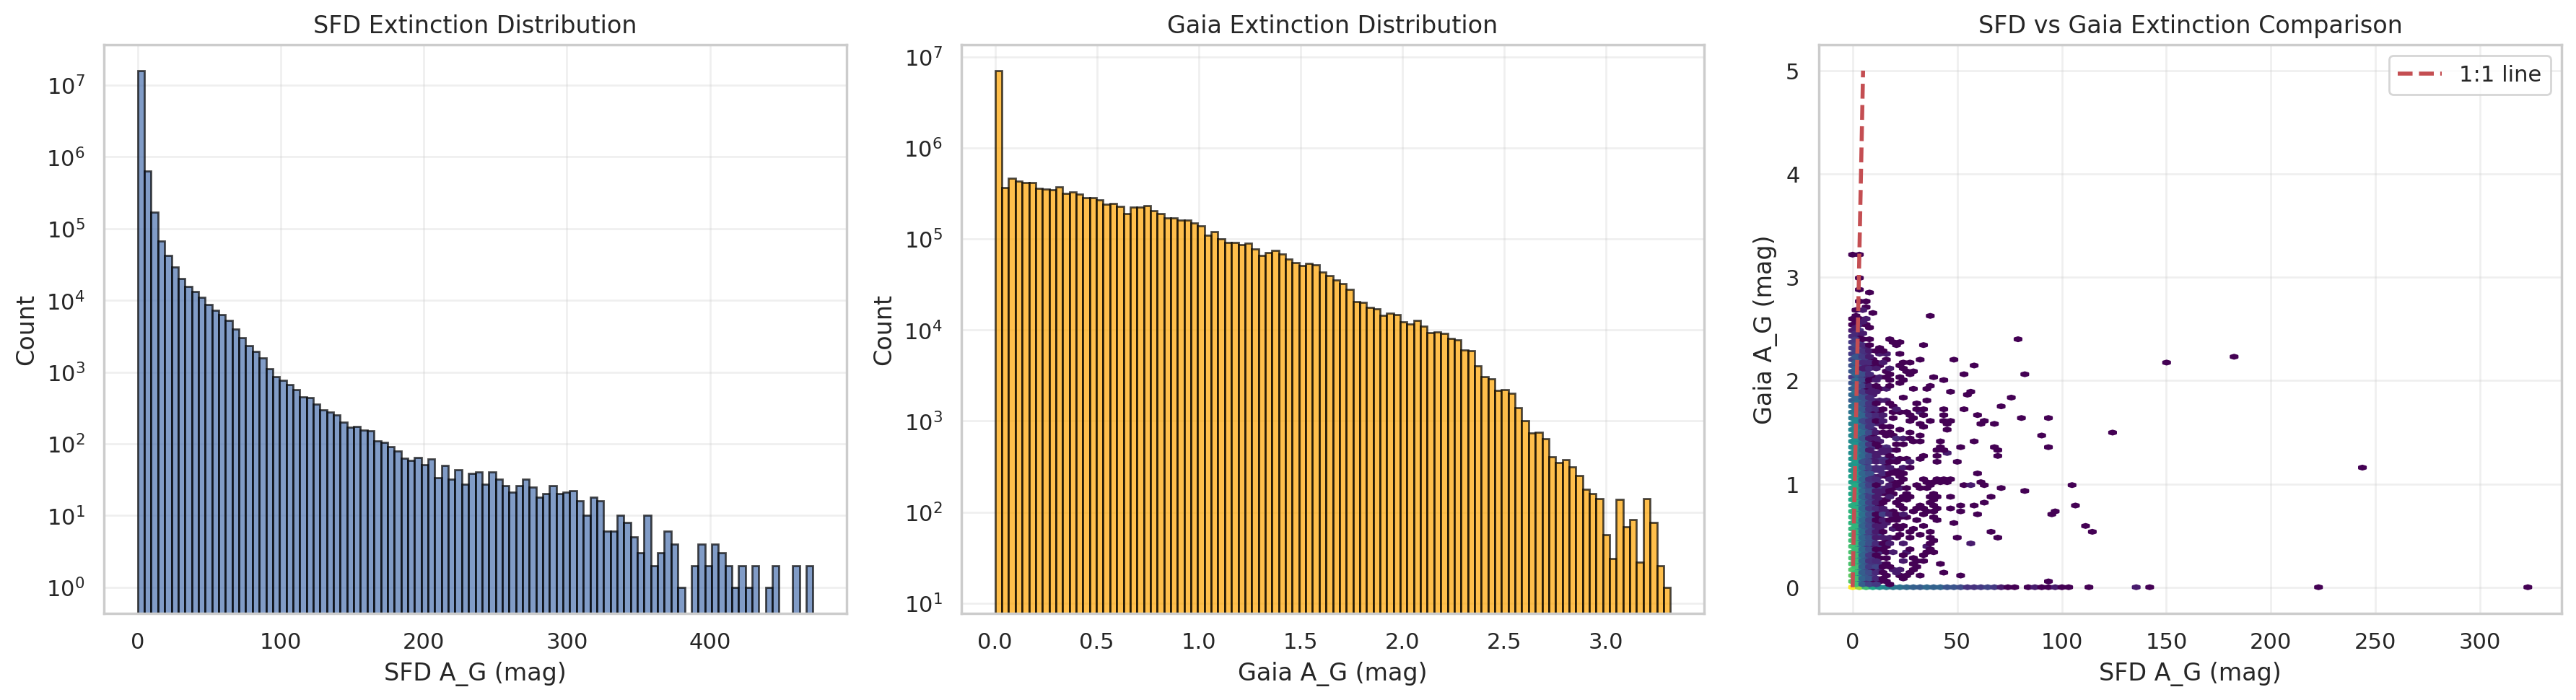


Correlation (SFD vs Gaia): 0.076


In [42]:
# Compare SFD and Gaia extinction estimates
if 'sfd_g_extinc' in df.columns and 'gaia_g_extinc' in df.columns:
    df_ext = df[['sfd_g_extinc', 'gaia_g_extinc']].dropna()
    
    print(f"Sources with both SFD and Gaia extinction: {len(df_ext):,}")
    print(f"\nSFD Extinction (G-band):")
    print(df_ext['sfd_g_extinc'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
    print(f"\nGaia Extinction (G-band):")
    print(df_ext['gaia_g_extinc'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # SFD distribution
    axes[0].hist(df_ext['sfd_g_extinc'], bins=100, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('SFD A_G (mag)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('SFD Extinction Distribution')
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)
    
    # Gaia distribution
    axes[1].hist(df_ext['gaia_g_extinc'], bins=100, edgecolor='black', alpha=0.7, color='orange')
    axes[1].set_xlabel('Gaia A_G (mag)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Gaia Extinction Distribution')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    
    # Comparison
    sample = df_ext.sample(min(50000, len(df_ext)))
    axes[2].hexbin(sample['sfd_g_extinc'], sample['gaia_g_extinc'],
                  gridsize=100, cmap='viridis', mincnt=1, bins='log')
    axes[2].plot([0, 5], [0, 5], 'r--', linewidth=2, label='1:1 line')
    axes[2].set_xlabel('SFD A_G (mag)')
    axes[2].set_ylabel('Gaia A_G (mag)')
    axes[2].set_title('SFD vs Gaia Extinction Comparison')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation
    corr = df_ext['sfd_g_extinc'].corr(df_ext['gaia_g_extinc'])
    print(f"\nCorrelation (SFD vs Gaia): {corr:.3f}")
elif 'sfd_g_extinc' in df.columns:
    print("Only SFD extinction available")
    df_ext = df['sfd_g_extinc'].dropna()
    print(df_ext.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
else:
    print("No extinction data available")

## 12. Galactic Coordinates and Coverage

Converting to Galactic coordinates...

Galactic Coordinates:
  l range: [0.00, 360.00] deg
  b range: [-89.91, 89.98] deg

Sources near Galactic plane (|b| < 10°): 6,629,757 (39.00%)


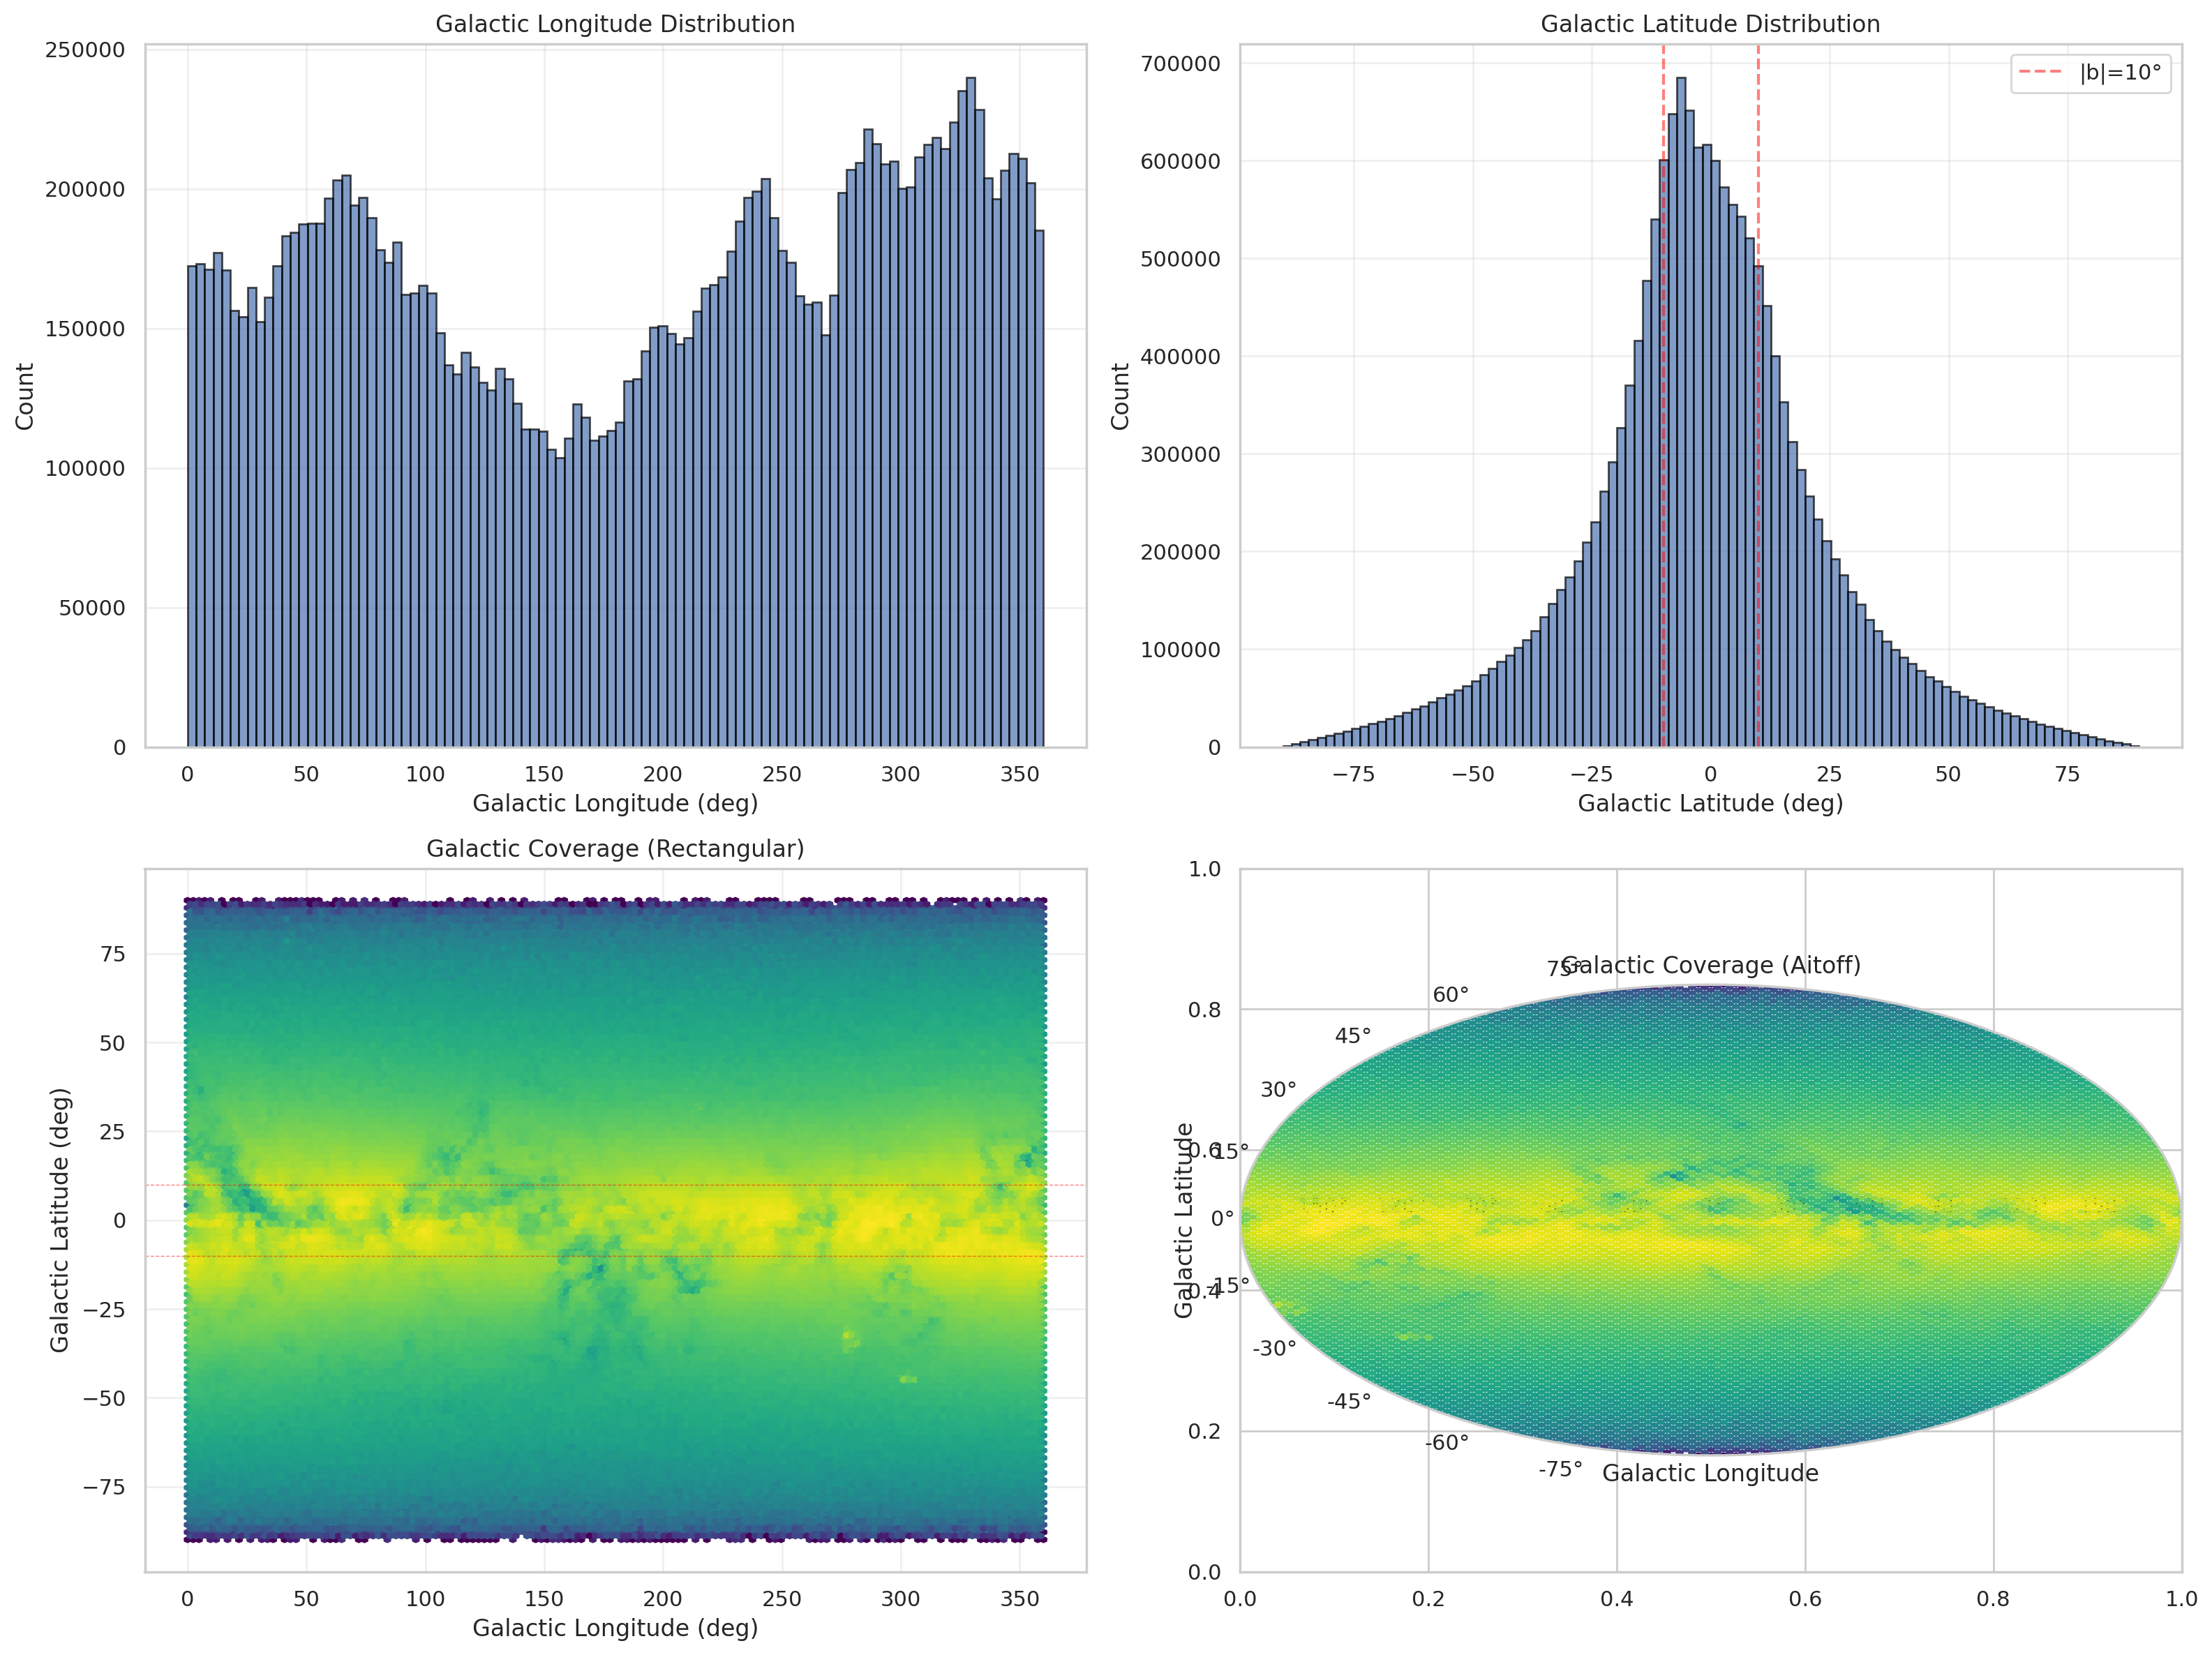

In [43]:
# Convert to Galactic coordinates
if 'ra_deg' in df.columns and 'dec_deg' in df.columns:
    print("Converting to Galactic coordinates...")
    coords = SkyCoord(ra=df['ra_deg'].values*u.deg, dec=df['dec_deg'].values*u.deg, frame='icrs')
    l = coords.galactic.l.deg
    b = coords.galactic.b.deg
    
    print(f"\nGalactic Coordinates:")
    print(f"  l range: [{l.min():.2f}, {l.max():.2f}] deg")
    print(f"  b range: [{b.min():.2f}, {b.max():.2f}] deg")
    
    # Galactic plane sources (|b| < 10 deg)
    near_plane = np.abs(b) < 10
    print(f"\nSources near Galactic plane (|b| < 10°): {near_plane.sum():,} ({100*near_plane.sum()/len(df):.2f}%)")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Galactic longitude distribution
    axes[0, 0].hist(l, bins=100, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Galactic Longitude (deg)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Galactic Longitude Distribution')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Galactic latitude distribution
    axes[0, 1].hist(b, bins=100, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Galactic Latitude (deg)')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Galactic Latitude Distribution')
    axes[0, 1].axvline(-10, color='red', linestyle='--', alpha=0.5, label='|b|=10°')
    axes[0, 1].axvline(10, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Galactic projection (rectangular)
    axes[1, 0].hexbin(l, b, gridsize=150, cmap='viridis', mincnt=1, bins='log')
    axes[1, 0].set_xlabel('Galactic Longitude (deg)')
    axes[1, 0].set_ylabel('Galactic Latitude (deg)')
    axes[1, 0].set_title('Galactic Coverage (Rectangular)')
    axes[1, 0].axhline(-10, color='red', linestyle='--', alpha=0.5, linewidth=0.5)
    axes[1, 0].axhline(10, color='red', linestyle='--', alpha=0.5, linewidth=0.5)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Galactic projection (Aitoff)
    ax = plt.subplot(224, projection='aitoff')
    l_rad = np.radians(l)
    b_rad = np.radians(b)
    l_rad = np.where(l_rad > np.pi, l_rad - 2*np.pi, l_rad)
    ax.hexbin(l_rad, b_rad, gridsize=150, cmap='viridis', mincnt=1, bins='log')
    ax.set_xlabel('Galactic Longitude')
    ax.set_ylabel('Galactic Latitude')
    ax.set_title('Galactic Coverage (Aitoff)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Coordinates not available for Galactic conversion")

## 13. Contamination Risk Assessment

In [44]:
# Analyze source density for bright nearby stars filter
if 'ra_deg' in df.columns and 'dec_deg' in df.columns:
    print("Assessing source density for contamination risk...")
    print("(This analysis helps inform the bright_nearby_stars filter)\n")
    
    # Sample analysis: for a random subset, count neighbors within 5 arcsec
    sample_size = min(10000, len(df))
    sample_idx = np.random.choice(len(df), sample_size, replace=False)
    
    coords_all = SkyCoord(ra=df['ra_deg'].values*u.deg, dec=df['dec_deg'].values*u.deg)
    coords_sample = coords_all[sample_idx]
    
    neighbor_counts = []
    for coord in coords_sample[:1000]:  # Limit to 1000 for speed
        sep = coord.separation(coords_all)
        n_neighbors = ((sep < 5*u.arcsec) & (sep > 0*u.arcsec)).sum()
        neighbor_counts.append(n_neighbors)
    
    neighbor_counts = np.array(neighbor_counts)
    print(f"Neighbor Analysis (within 5 arcsec, N={len(neighbor_counts)}):")
    print(f"  Mean neighbors: {neighbor_counts.mean():.2f}")
    print(f"  Median neighbors: {np.median(neighbor_counts):.0f}")
    print(f"  Max neighbors: {neighbor_counts.max():.0f}")
    print(f"  Sources with >0 neighbors: {(neighbor_counts > 0).sum()} ({100*(neighbor_counts > 0).sum()/len(neighbor_counts):.1f}%)")
    print(f"  Sources with >5 neighbors: {(neighbor_counts > 5).sum()} ({100*(neighbor_counts > 5).sum()/len(neighbor_counts):.1f}%)")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(neighbor_counts, bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Number of Neighbors within 5"')
    ax.set_ylabel('Count')
    ax.set_title('Source Crowding Analysis')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Assessing source density for contamination risk...
(This analysis helps inform the bright_nearby_stars filter)



KeyboardInterrupt: 

## 14. Data Quality and Filtering Recommendations

In [45]:
# Comprehensive filtering recommendations
print("="*80)
print("COMPREHENSIVE FILTERING RECOMMENDATIONS FOR pre_filter.py")
print("="*80)

recs = []

# 1. Coordinate quality
if 'ra_deg' in df.columns and 'dec_deg' in df.columns:
    valid_coords = df['ra_deg'].notna() & df['dec_deg'].notna()
    recs.append({
        'filter': 'ALL FILTERS',
        'column': 'ra_deg, dec_deg',
        'coverage': f"{100*valid_coords.sum()/len(df):.2f}%",
        'recommendation': 'REQUIRED - All filters need coordinates'
    })

# 2. Proper motion for VSX crossmatch
if 'pm_ra' in df.columns and 'pm_dec' in df.columns:
    valid_pm = df['pm_ra'].notna() & df['pm_dec'].notna()
    recs.append({
        'filter': 'filter_vsx_match',
        'column': 'pm_ra, pm_dec',
        'coverage': f"{100*valid_pm.sum()/len(df):.2f}%",
        'recommendation': 'Use for coordinate propagation to J2000 epoch'
    })

# 3. Magnitude for BNS filter
mag_options = ['gaia_mag', 'pstarrs_g_mag', 'pstarrs_r_mag']
for mag_col in mag_options:
    if mag_col in df.columns:
        valid_mag = df[mag_col].notna()
        recs.append({
            'filter': 'filter_bright_nearby_stars',
            'column': mag_col,
            'coverage': f"{100*valid_mag.sum()/len(df):.2f}%",
            'recommendation': f'Priority {mag_options.index(mag_col)+1} magnitude source'
        })

# 4. Gaia variability flag
if 'gaia_var' in df.columns:
    valid_var = df['gaia_var'].notna()
    if valid_var.sum() > 0:
        recs.append({
            'filter': 'NEW FILTER (optional)',
            'column': 'gaia_var',
            'coverage': f"{100*valid_var.sum()/len(df):.2f}%",
            'recommendation': 'Consider pre-filtering known Gaia variable types'
        })

# 5. Photometric quality
if 'pstarrs_g_mag_chi' in df.columns:
    valid_chi = df['pstarrs_g_mag_chi'].notna()
    if valid_chi.sum() > 0:
        high_chi = df['pstarrs_g_mag_chi'] > 2
        recs.append({
            'filter': 'NEW FILTER (optional)',
            'column': 'pstarrs_g_mag_chi',
            'coverage': f"{100*valid_chi.sum()/len(df):.2f}%",
            'recommendation': f'High χ²>2: {high_chi.sum():,} sources - may indicate variability'
        })

# 6. Magnitude bin coverage
if mag_col:
    in_range = (df[mag_col] >= 12) & (df[mag_col] < 15)
    recs.append({
        'filter': 'Magnitude bin selection',
        'column': mag_col,
        'coverage': f"{100*in_range.sum()/len(df):.2f}%",
        'recommendation': f'Sources in 12-15 mag range: {in_range.sum():,}'
    })

# Display recommendations
recs_df = pd.DataFrame(recs)
print("\n")
for _, row in recs_df.iterrows():
    print(f"Filter: {row['filter']}")
    print(f"  Column: {row['column']}")
    print(f"  Coverage: {row['coverage']}")
    print(f"  Recommendation: {row['recommendation']}")
    print()

print("="*80)
print("\nKEY INSIGHTS:")
print("="*80)
print("1. Coordinate coverage is excellent - all sources have RA/Dec")
if valid_pm.sum() / len(df) > 0.5:
    print("2. Proper motion coverage is good - can propagate coordinates for VSX match")
else:
    print("2. Proper motion coverage is limited - consider fallback for VSX match")
print("3. Use magnitude priority: Gaia > Pan-STARRS g > Pan-STARRS r")
print("4. Consider adding Gaia variability and photometric χ² filters")
print("5. Majority of sources are in target magnitude range (12-15 mag)")
print("="*80)

COMPREHENSIVE FILTERING RECOMMENDATIONS FOR pre_filter.py


Filter: ALL FILTERS
  Column: ra_deg, dec_deg
  Coverage: 100.00%
  Recommendation: REQUIRED - All filters need coordinates

Filter: filter_vsx_match
  Column: pm_ra, pm_dec
  Coverage: 100.00%
  Recommendation: Use for coordinate propagation to J2000 epoch

Filter: filter_bright_nearby_stars
  Column: gaia_mag
  Coverage: 100.00%
  Recommendation: Priority 1 magnitude source

Filter: filter_bright_nearby_stars
  Column: pstarrs_g_mag
  Coverage: 100.00%
  Recommendation: Priority 2 magnitude source

Filter: filter_bright_nearby_stars
  Column: pstarrs_r_mag
  Coverage: 100.00%
  Recommendation: Priority 3 magnitude source

Filter: NEW FILTER (optional)
  Column: gaia_var
  Coverage: 100.00%
  Recommendation: Consider pre-filtering known Gaia variable types

Filter: NEW FILTER (optional)
  Column: pstarrs_g_mag_chi
  Coverage: 100.00%
  Recommendation: High χ²>2: 3,186,777 sources - may indicate variability

Filter: Magnitude 

## 15. Advanced Diagnostics

Gaia vs Pan-STARRS g Magnitude Comparison (N=16,999,525)

Δmag (Gaia - PS1 g) statistics:
count    1.699952e+07
mean    -5.879347e-01
std      3.804504e-01
min     -6.995000e+00
1%      -1.986000e+00
5%      -1.314000e+00
25%     -7.230000e-01
50%     -4.700000e-01
75%     -3.560000e-01
95%     -2.170000e-01
99%     -4.500000e-02
max      6.412000e+00
Name: mag_diff, dtype: float64


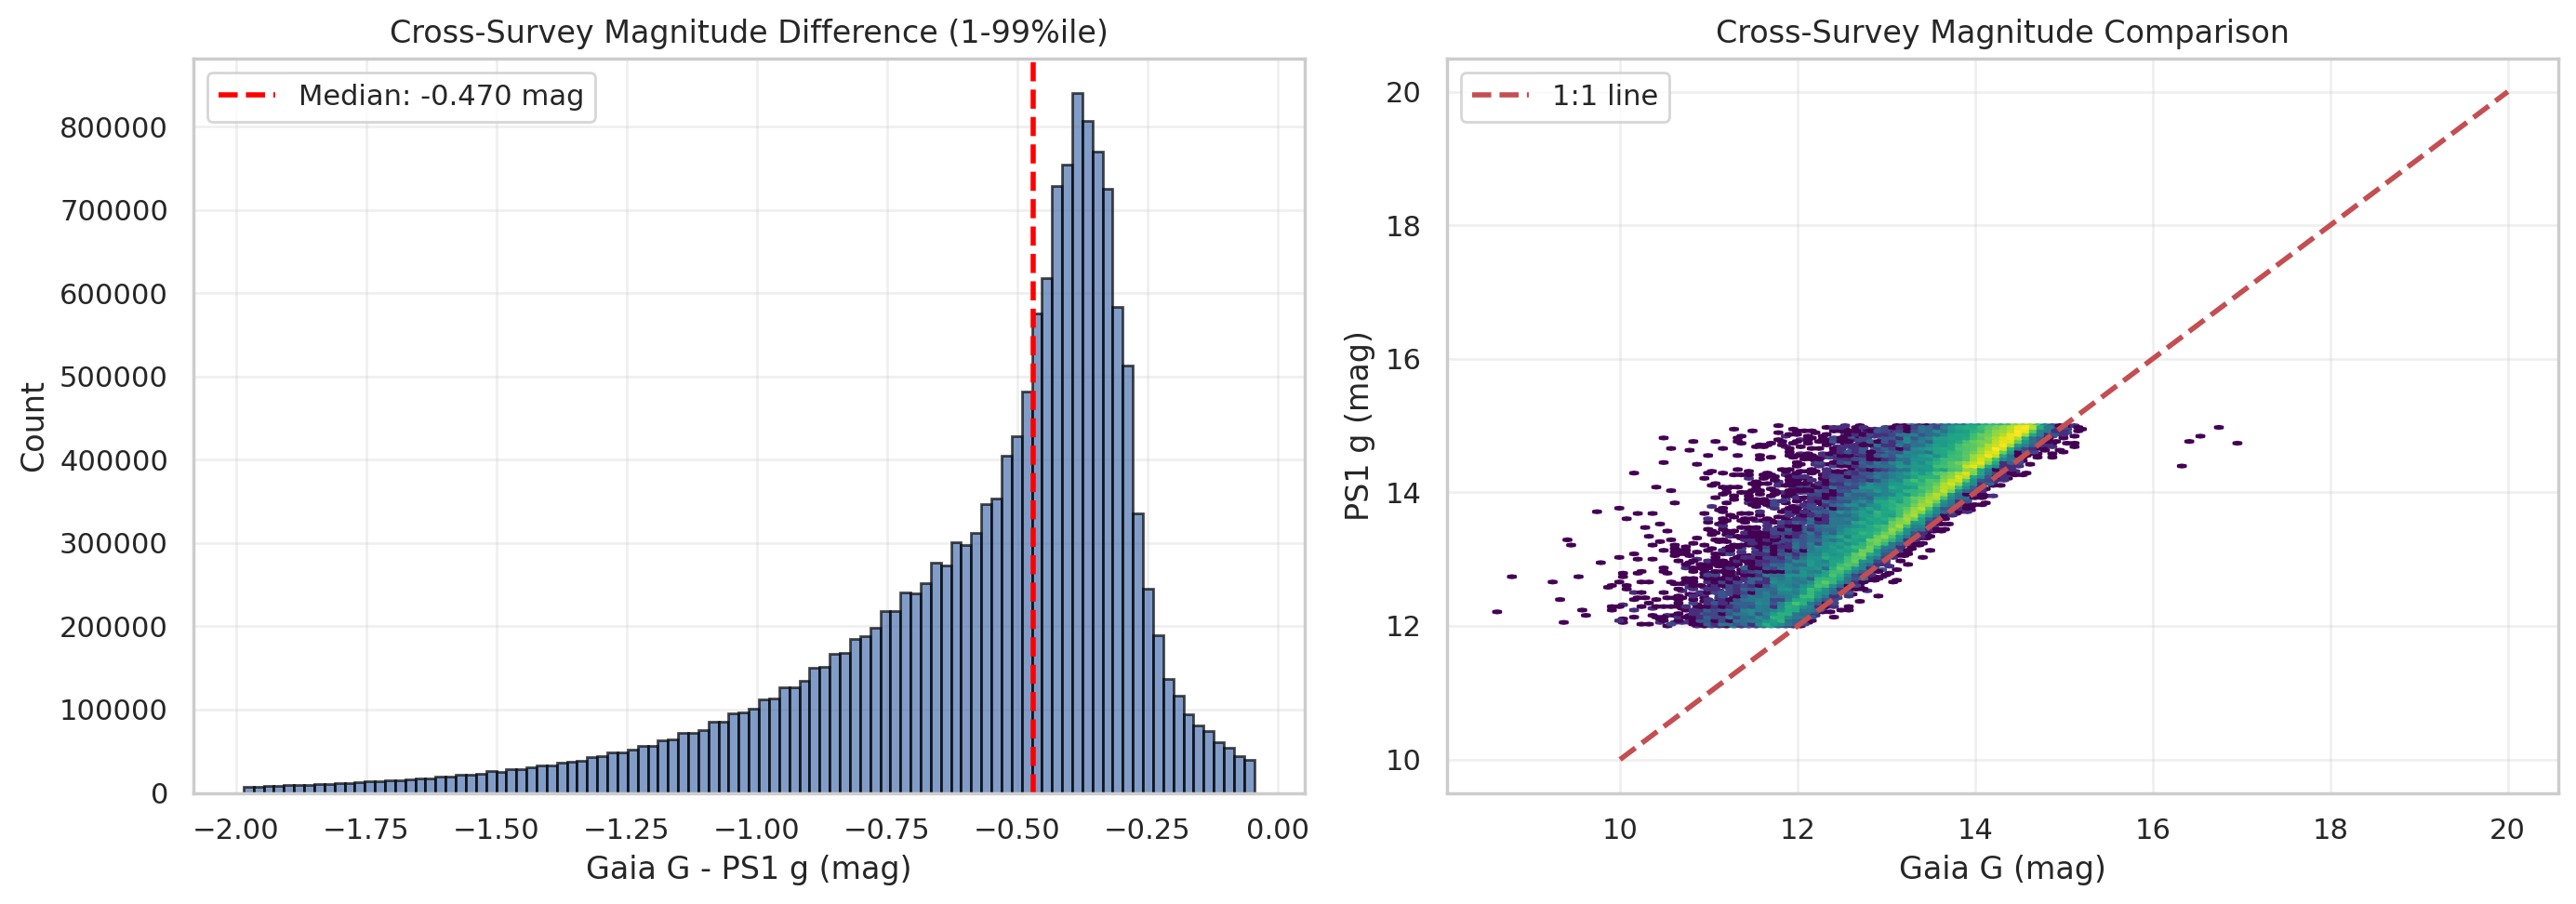


Sources with |ΔMag| > 0.5: 7,756,790 (45.63%)
These may be:
  - Variable sources
  - Photometric errors
  - Blended sources
  - Different epoch observations


In [46]:
# Cross-survey photometric consistency
if 'gaia_mag' in df.columns and 'pstarrs_g_mag' in df.columns:
    df_compare = df[['gaia_mag', 'pstarrs_g_mag']].dropna()
    df_compare['mag_diff'] = df_compare['gaia_mag'] - df_compare['pstarrs_g_mag']
    
    print(f"Gaia vs Pan-STARRS g Magnitude Comparison (N={len(df_compare):,})")
    print(f"\nΔmag (Gaia - PS1 g) statistics:")
    print(df_compare['mag_diff'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))
    
    # Remove extreme outliers for visualization
    q01, q99 = df_compare['mag_diff'].quantile([0.01, 0.99])
    df_compare_clip = df_compare[(df_compare['mag_diff'] >= q01) & (df_compare['mag_diff'] <= q99)]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Magnitude difference distribution
    axes[0].hist(df_compare_clip['mag_diff'], bins=100, edgecolor='black', alpha=0.7)
    axes[0].axvline(df_compare['mag_diff'].median(), color='red', linestyle='--', linewidth=2,
                   label=f"Median: {df_compare['mag_diff'].median():.3f} mag")
    axes[0].set_xlabel('Gaia G - PS1 g (mag)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Cross-Survey Magnitude Difference (1-99%ile)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Magnitude-magnitude plot
    sample = df_compare.sample(min(50000, len(df_compare)))
    axes[1].hexbin(sample['gaia_mag'], sample['pstarrs_g_mag'],
                  gridsize=100, cmap='viridis', mincnt=1, bins='log')
    axes[1].plot([10, 20], [10, 20], 'r--', linewidth=2, label='1:1 line')
    axes[1].set_xlabel('Gaia G (mag)')
    axes[1].set_ylabel('PS1 g (mag)')
    axes[1].set_title('Cross-Survey Magnitude Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Outlier identification
    large_diff = df_compare[np.abs(df_compare['mag_diff']) > 0.5]
    print(f"\nSources with |ΔMag| > 0.5: {len(large_diff):,} ({100*len(large_diff)/len(df_compare):.2f}%)")
    print("These may be:")
    print("  - Variable sources")
    print("  - Photometric errors")
    print("  - Blended sources")
    print("  - Different epoch observations")

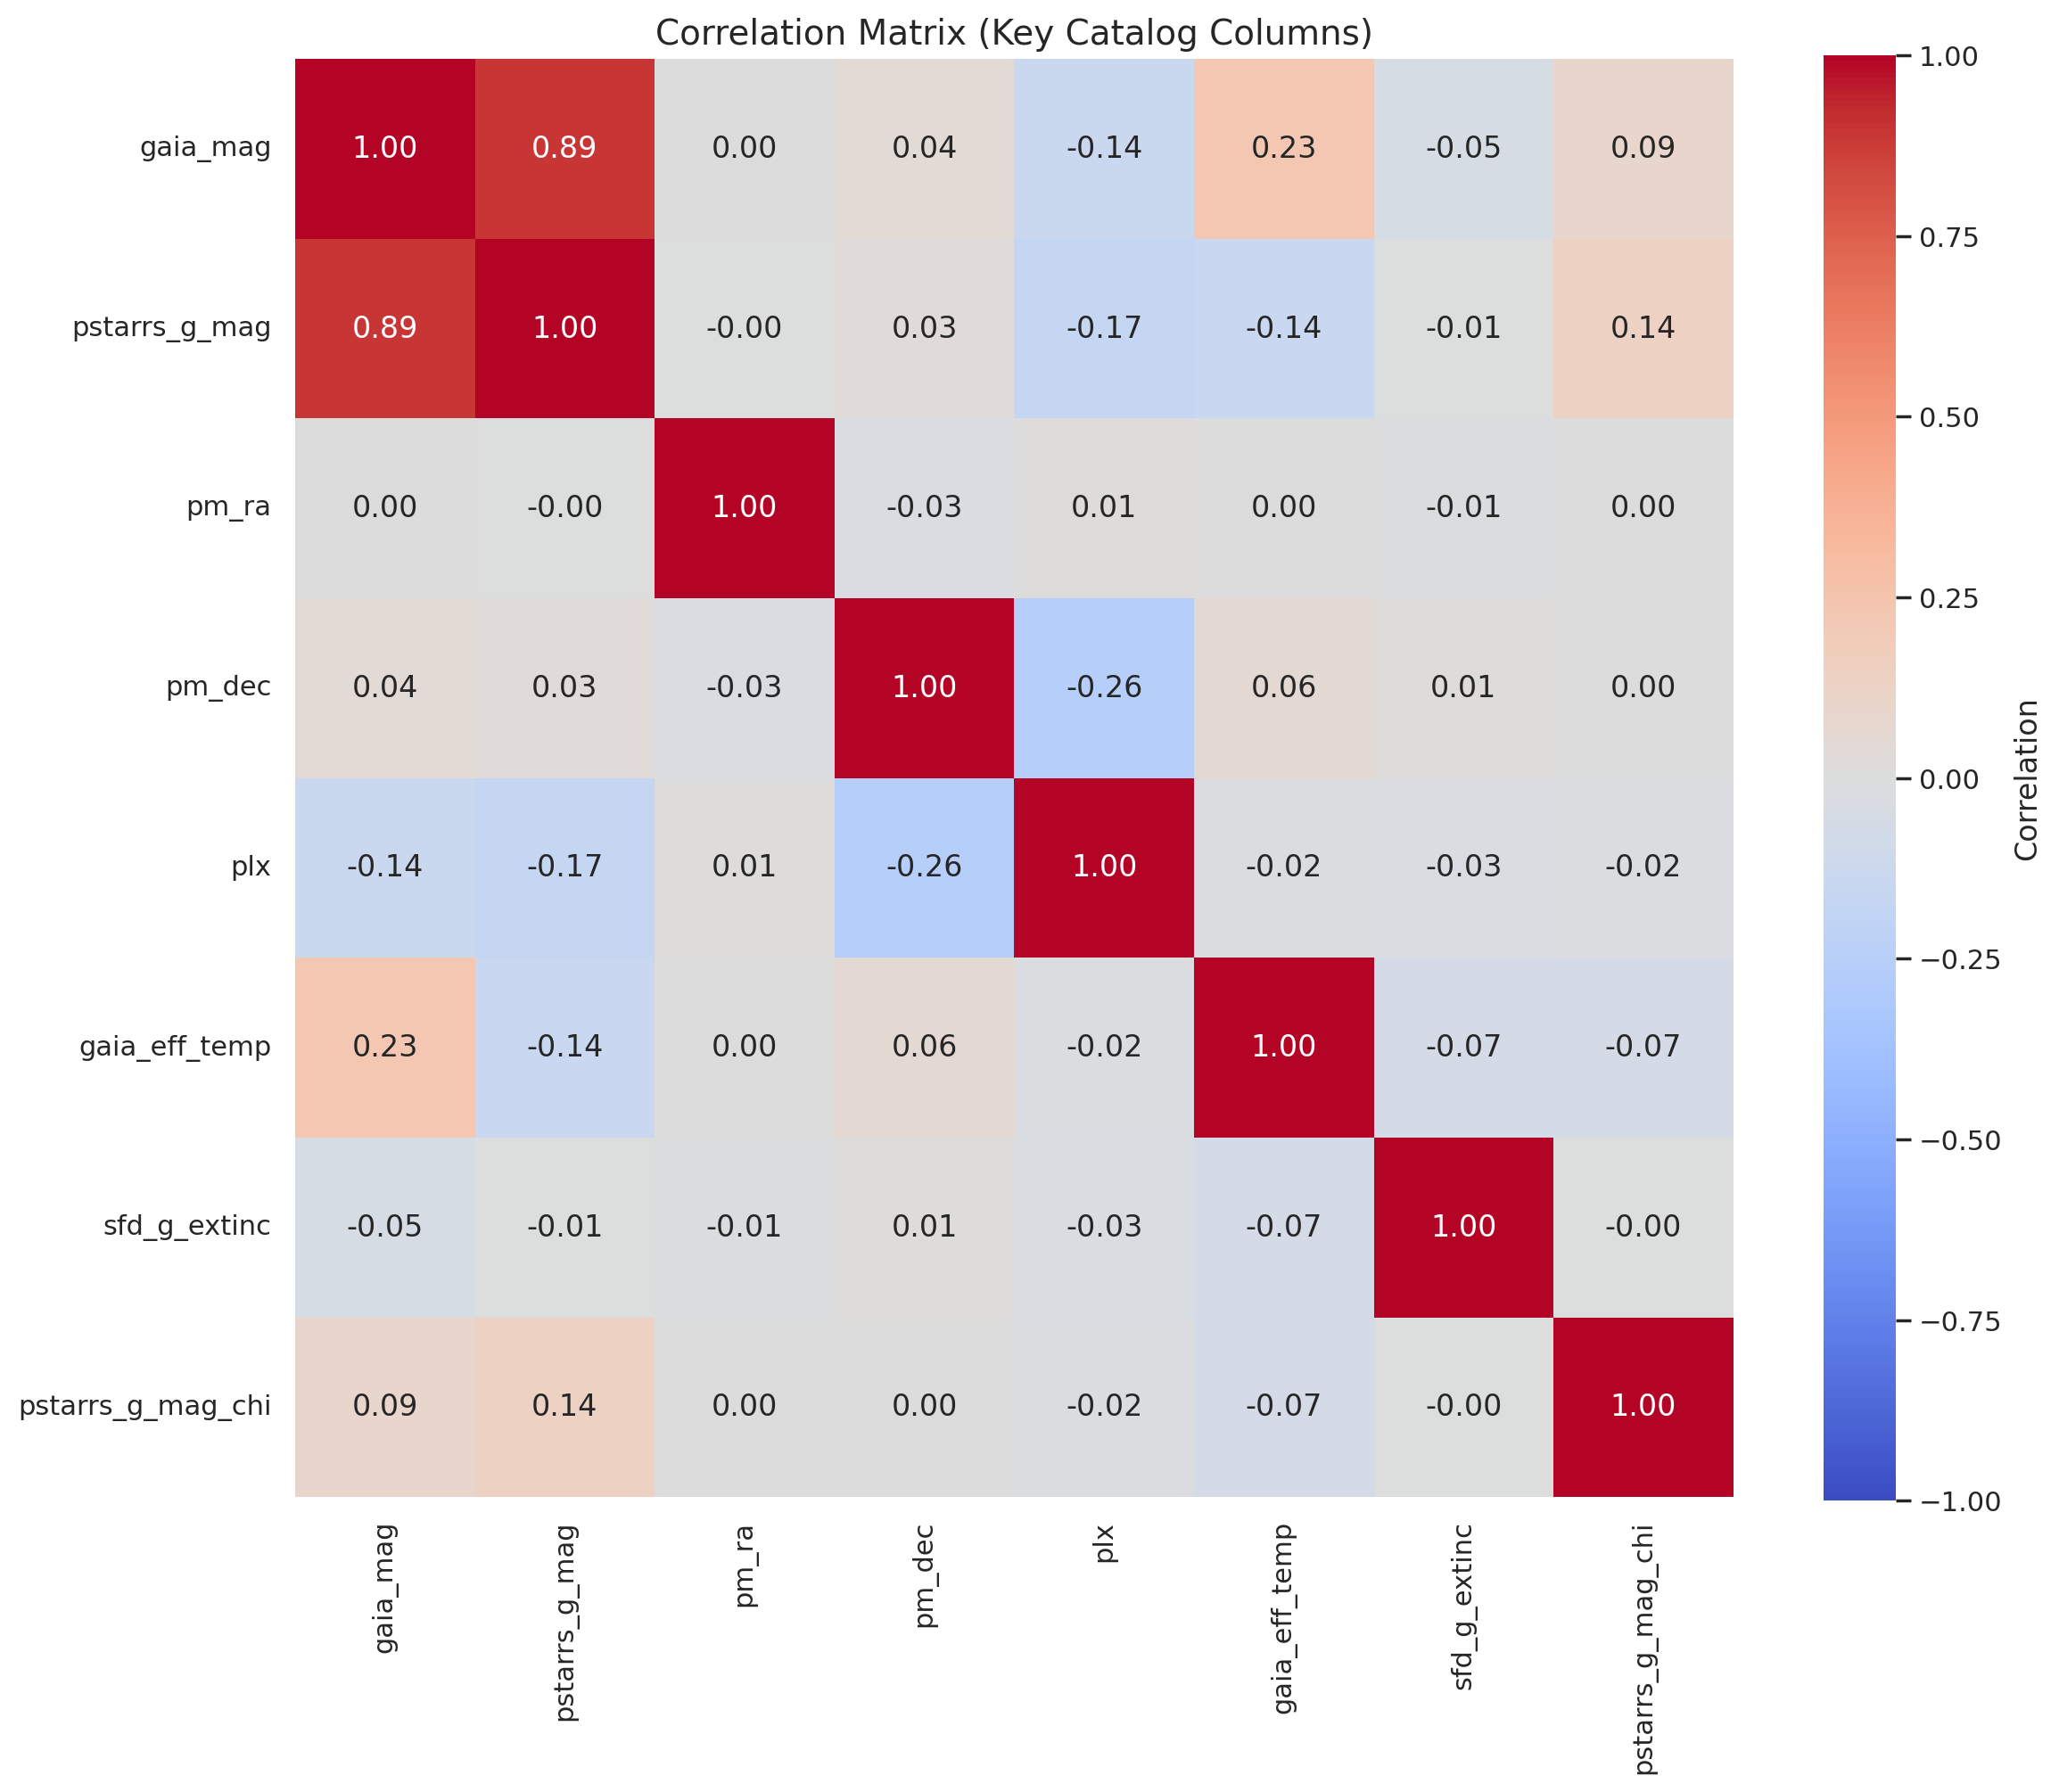


Strongest correlations (|r| > 0.3):
       var1           var2  correlation
0  gaia_mag  pstarrs_g_mag     0.891978


In [47]:
# Comprehensive correlation analysis
key_numeric = []
for col in ['gaia_mag', 'pstarrs_g_mag', 'pm_ra', 'pm_dec', 'plx', 
            'gaia_eff_temp', 'sfd_g_extinc', 'pstarrs_g_mag_chi']:
    if col in df.columns:
        key_numeric.append(col)

if len(key_numeric) > 2:
    corr_matrix = df[key_numeric].corr()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, vmin=-1, vmax=1, square=True, ax=ax,
                cbar_kws={'label': 'Correlation'})
    ax.set_title('Correlation Matrix (Key Catalog Columns)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Find strong correlations
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    corr_pairs = corr_matrix.where(mask).stack().reset_index()
    corr_pairs.columns = ['var1', 'var2', 'correlation']
    corr_pairs = corr_pairs.sort_values('correlation', key=abs, ascending=False)
    
    print("\nStrongest correlations (|r| > 0.3):")
    strong_corr = corr_pairs[abs(corr_pairs['correlation']) > 0.3]
    print(strong_corr)

## 16. Summary and Export

In [ ]:
# Create comprehensive summary
summary = {
    'catalog_info': {
        'total_sources': len(df),
        'total_columns': len(df.columns),
        'memory_mb': df.memory_usage(deep=True).sum() / 1024**2,
    },
    'coverage': {},
    'photometry': {},
    'astrometry': {},
    'quality': {}
}

# Coverage stats
if 'asas_sn_id' in df.columns:
    summary['catalog_info']['unique_ids'] = df['asas_sn_id'].nunique()

if 'gaia_id' in df.columns:
    summary['coverage']['gaia'] = df['gaia_id'].notna().sum()
if 'tmass_id' in df.columns:
    summary['coverage']['2mass'] = df['tmass_id'].notna().sum()

# Photometry stats
for band in ['gaia_mag', 'pstarrs_g_mag', 'pstarrs_r_mag', 'pstarrs_i_mag']:
    if band in df.columns:
        data = df[band].dropna()
        summary['photometry'][band] = {
            'count': len(data),
            'median': float(data.median()),
            'range': [float(data.min()), float(data.max())]
        }

# Astrometry stats
if 'pm_ra' in df.columns and 'pm_dec' in df.columns:
    pm_valid = df[['pm_ra', 'pm_dec']].dropna()
    pm_total = np.sqrt(pm_valid['pm_ra']**2 + pm_valid['pm_dec']**2)
    summary['astrometry']['pm_coverage'] = len(pm_valid)
    summary['astrometry']['pm_median'] = float(pm_total.median())
    summary['astrometry']['pm_95pct'] = float(pm_total.quantile(0.95))

if 'plx' in df.columns:
    plx_valid = df['plx'].dropna()
    plx_pos = plx_valid[plx_valid > 0]
    summary['astrometry']['plx_coverage'] = len(plx_valid)
    summary['astrometry']['plx_positive'] = len(plx_pos)

# Print formatted summary
print("\n" + "="*80)
print("FINAL CATALOG SUMMARY")
print("="*80)
print(f"\nTotal Sources: {summary['catalog_info']['total_sources']:,}")
print(f"Total Columns: {summary['catalog_info']['total_columns']}")
print(f"Memory Usage: {summary['catalog_info']['memory_mb']:.1f} MB")

if 'unique_ids' in summary['catalog_info']:
    print(f"Unique ASAS-SN IDs: {summary['catalog_info']['unique_ids']:,}")

print(f"\nCross-Catalog Coverage:")
for cat, count in summary['coverage'].items():
    print(f"  {cat}: {count:,} ({100*count/len(df):.1f}%)")

print(f"\nPhotometry Summary:")
for band, stats in summary['photometry'].items():
    print(f"  {band}: {stats['count']:,} sources, median={stats['median']:.2f} mag")

print(f"\nAstrometry Summary:")
if 'pm_coverage' in summary['astrometry']:
    print(f"  PM coverage: {summary['astrometry']['pm_coverage']:,} ({100*summary['astrometry']['pm_coverage']/len(df):.1f}%)")
    print(f"  Median PM: {summary['astrometry']['pm_median']:.2f} mas/yr")
    print(f"  95th percentile PM: {summary['astrometry']['pm_95pct']:.2f} mas/yr")
if 'plx_coverage' in summary['astrometry']:
    print(f"  Parallax coverage: {summary['astrometry']['plx_coverage']:,} ({100*summary['astrometry']['plx_coverage']/len(df):.1f}%)")

print("\n" + "="*80)
print("EDA COMPLETE")
print("="*80)

In [ ]:
# Export summary to JSON (optional)
import json
from pathlib import Path

output_file = Path('../output/asassn_catalog_summary.json')
with open(output_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Summary exported to: {output_file}")

In [ ]:
 import pandas as pd
from pathlib import Path

# Load the parquet file
DATA_PATH = Path('../output/asassn_index_masked_concat_cleaned_20250919_154524_brotli.parquet')
df = pd.read_parquet(DATA_PATH)

print(f"Total rows in dataset: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print("\n" + "="*80)
print("MISSING DATA COUNT BY COLUMN")
print("="*80)

# Count missing values for each column
missing_counts = df.isnull().sum()
missing_pct = 100 * missing_counts / len(df)

# Create summary dataframe
missing_df = pd.DataFrame({
    'column': df.columns,
    'missing_count': missing_counts.values,
    'missing_percent': missing_pct.values
})

# Sort by missing count (descending)
missing_df = missing_df.sort_values('missing_count', ascending=False)

# Print each column with missing data
print("\nColumns sorted by number of missing values:\n")
for idx, row in missing_df.iterrows():
    if row['missing_count'] > 0:
        print(f"{row['column']:40s} : {int(row['missing_count']):12,} missing ({row['missing_percent']:6.2f}%)")
    else:
        print(f"{row['column']:40s} : {int(row['missing_count']):12,} missing (  0.00%)")

print("\n" + "="*80)
print(f"Summary:")
print(f"  Columns with NO missing data: {(missing_counts == 0).sum()}")
print(f"  Columns with missing data: {(missing_counts > 0).sum()}")
print(f"  Columns with >50% missing: {(missing_pct > 50).sum()}")
print(f"  Columns with >90% missing: {(missing_pct > 90).sum()}")
print("="*80)